In [1]:
import re
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from openbabel import pybel
from tempfile import NamedTemporaryFile
import os


In [2]:
from openbabel import pybel
from tempfile import NamedTemporaryFile
import os
import re
import pandas as pd

# ---------- Helper Function for Scientific Notation ----------
def parse_float(value):
    """Convert a string to float, handling scientific notation."""
    try:
        return float(value)
    except ValueError:
        return None    

# ---------- SMILES Generation Function ----------
def coords_to_smiles(mol_coords):
    """
    Convert (symbol, x, y, z) coordinates into a SMILES string using OpenBabel (pybel).
    """
    if not mol_coords:
        return None
        
    # Write coords to a temporary XYZ file
    with NamedTemporaryFile("w", suffix=".xyz", delete=False) as tmp:
        tmp.write(f"{len(mol_coords)}\n")
        tmp.write("Generated from dataframe\n")
        for atom, x, y, z in mol_coords:
            tmp.write(f"{atom} {x:.6f} {y:.6f} {z:.6f}\n")
        tmp_path = tmp.name

    try:
        # Read with pybel
        mol = next(pybel.readfile("xyz", tmp_path))
        
        # Convert to SMILES
        smi = mol.write("smi").strip()
        return smi.split()[0]
    except Exception as e:
        return None
    finally:
        # Clean up temporary file
        try:
            os.unlink(tmp_path)
        except:
            pass

# ---------- Geometry Info ----------
def parse_geometry_info(text):
    """Parse geometry file name, charge, and multiplicity from ORCA output."""
    geometry_info = {"filename": None, "charge": None, "multiplicity": None}

    # Try to find geometry file from "The coordinates will be read from file" line
    coords_match = re.search(
        r"The coordinates will be read from file:\s*(\S+)",
        text
    )
    if coords_match:
        geometry_file = coords_match.group(1)
        # Strip extension to get base name (e.g., "phs0" from "phs0.xyz")
        geometry_info["filename"] = os.path.splitext(geometry_file)[0]

    # Try to find geometry file, charge, and multiplicity from input section
    input_section_match = re.search(
        r"={10,}\s*(INPUT FILE|INPUT)\s*\n={10,}\n(.*?)\*{4}END OF INPUT\*{4}",
        text, flags=re.S | re.I
    )
    if input_section_match:
        input_section = input_section_match.group(2)
        # Look for * xyzfile charge multiplicity filename
        xyzfile_match = re.search(
            r"\*\s*xyzfile\s+(\d+)\s+(\d+)\s+(\S+)",
            input_section, flags=re.I
        )
        if xyzfile_match:
            geometry_info["charge"] = int(xyzfile_match.group(1))
            geometry_info["multiplicity"] = int(xyzfile_match.group(2))
            geometry_file = xyzfile_match.group(3)
            # Strip extension to get base name
            geometry_info["filename"] = os.path.splitext(geometry_file)[0]
    
    # If filename is still None, fallback to using the input filename without extension
    if geometry_info["filename"] is None:
        return None
    
    return geometry_info

# ---------- Cartesian ----------
def parse_last_cartesian(text):
    """Parse the last Cartesian coordinates block from ORCA output."""
    blocks = re.findall(
        r"CARTESIAN COORDINATES \(ANGSTROEM\)\n-+\n(.*?)\n\n",
        text, flags=re.S
    )
    if not blocks:
        return None
    last_block = blocks[-1].strip().splitlines()
    coords = []
    for line in last_block:
        parts = line.split()
        if len(parts) < 4:
            continue
        atom = parts[0]
        x, y, z = map(parse_float, parts[1:4])
        if None in (x, y, z):
            continue
        coords.append((atom, x, y, z))
    return coords

# ---------- Internal ----------
def parse_last_internal(text):
    """Parse the last internal coordinates block from ORCA output."""
    blocks = re.findall(
        r"INTERNAL COORDINATES \(ANGSTROEM\)\n-+\n(.*?)\n\n",
        text, flags=re.S
    )
    if not blocks:
        return None
    last_block = blocks[-1].strip().splitlines()
    coords = []
    for line in last_block:
        parts = line.split()
        if len(parts) < 7:
            continue
        atom = parts[0]
        bond, angle, dihedral = map(parse_float, parts[4:7])
        if None in (bond, angle, dihedral):
            continue
        coords.append((atom, bond, angle, dihedral))
    return coords

# ---------- Orbitals ----------
def parse_last_orbitals(text, as_df=False):
    """Parse the last orbital energies block from ORCA output.
    Handles both closed-shell and open-shell (spin-polarized) cases.
    """
    # --- Case 1: Open-shell (spin up / spin down blocks) ---
    spin_blocks = re.findall(
        r"SPIN UP ORBITALS\n.*?\n(.*?)(?=\n\s*SPIN DOWN ORBITALS|\Z)",
        text, flags=re.S
    )
    spin_down_blocks = re.findall(
        r"SPIN DOWN ORBITALS\n.*?\n(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    
    if spin_blocks and spin_down_blocks:
        spins = [("up", spin_blocks[-1]), ("down", spin_down_blocks[-1])]
    else:
        # --- Case 2: Closed-shell (single ORBITAL ENERGIES block) ---
        blocks = re.findall(
            r"ORBITAL ENERGIES\n-+\n\s*NO.*?\n(.*?)(?:\n\n|\Z)",
            text, flags=re.S
        )
        if not blocks:
            return None
        spins = [("na", blocks[-1])]  # "na" = not applicable (closed shell)

    orbitals = []
    for spin, block in spins:
        lines = block.strip().splitlines()
        for line in lines:
            parts = line.split()
            if not parts or not parts[0].isdigit() or len(parts) < 4:
                continue
            
            occ = parse_float(parts[1])
            energy_h = parse_float(parts[2])
            energy_ev = parse_float(parts[3])
            
            if None in (occ, energy_h, energy_ev):
                continue
            
            # Filter out fake test data - ORCA only produces OCC values of 0.0, 1.0, or 2.0
            if occ not in [0.0, 1.0, 2.0]:
                continue
                
            # Additional check for obvious fake data patterns
            if energy_h == occ + 1.0 and energy_ev == occ + 2.0:
                continue
            
            orbitals.append({
                "OCC": occ,
                "Eh": energy_h,
                "eV": energy_ev,
                "spin": spin
            })
    
    if not orbitals:
        return None

    # Separate occupied and virtual orbitals
    occupied = [orb for orb in orbitals if orb["OCC"] > 0.0]
    virtual = [orb for orb in orbitals if orb["OCC"] == 0.0]
    
    # Sort occupied orbitals by energy (descending - highest energy first)
    # HOMO is the highest energy occupied orbital
    occupied.sort(key=lambda x: x["Eh"], reverse=True)
    
    # Sort virtual orbitals by energy (ascending - lowest energy first)
    # LUMO is the lowest energy virtual orbital
    virtual.sort(key=lambda x: x["Eh"])
    
    # Assign levels for occupied orbitals
    for i, orb in enumerate(occupied):
        orb["lvl"] = i  # HOMO = 0, HOMO-1 = 1, HOMO-2 = 2, etc.
    
    # Assign levels for virtual orbitals
    for i, orb in enumerate(virtual):
        orb["lvl"] = i  # LUMO = 0, LUMO+1 = 1, LUMO+2 = 2, etc.
    
    # Combine back into original order (by energy)
    all_orbitals = occupied + virtual
    all_orbitals.sort(key=lambda x: x["Eh"])
    
    if as_df:
        return pd.DataFrame(all_orbitals)
    
    return all_orbitals

# ---------- Vibrations ----------
def parse_last_vibrations(text):
    blocks = re.findall(
        r"VIBRATIONAL FREQUENCIES\n-+\n.*?\n\n(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    if not blocks:
        return None
    
    last_block = blocks[-1].strip().splitlines()
    vib_data = []
    for line in last_block:
        parts = line.split()
        if not parts or not parts[0].rstrip(":").isdigit():
            continue
        idx = int(parts[0].rstrip(":"))
        freq = float(parts[1])
        
        # check imaginary
        img = 1 if freq < 0 else 0
        
        vib_data.append({
            "freq_cm-1": freq,
            "img": img
        })
    
    return vib_data

# ---------- IR Spectrum ----------
def parse_ir_spectrum(text):
    match = re.search(
        r"-{5,}\nIR SPECTRUM\n-+\n.*?\n-+\n(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    if not match:
        return None
    
    block = match.group(1).strip().splitlines()
    ir_data = []
    for line in block:
        parts = line.split()
        if not parts or not parts[0].rstrip(":").isdigit():
            continue
        
        idx = int(parts[0].rstrip(":"))
        freq = float(parts[1])
        eps = float(parts[2])
        intensity = float(parts[3])
        t2 = float(parts[4])
        
        ir_data.append({
            "freq_cm-1": freq,
            "eps": eps,
            "intensity_km/mol": intensity,
            "t2": t2
        })
    
    return ir_data

# ---------- Raman Spectrum ----------
def parse_raman_spectrum(text, as_df=True):
    match = re.search(
        r"RAMAN SPECTRUM\s*-+\s*Mode.*?-+\s*(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    if not match:
        return None
    
    block = match.group(1).strip().splitlines()
    raman_data = []
    for line in block:
        parts = line.split()
        if len(parts) < 4:
            continue
        
        freq = float(parts[1])
        activity = float(parts[2])
        depol = float(parts[3])
        
        raman_data.append({
            "freq_cm-1": freq,
            "activity": activity,
            "depolarization": depol
        })
    
    if as_df:
        return pd.DataFrame(raman_data)
    return raman_data

# ---------- Gibbs Energy ----------
def parse_gibbs_energy(text):
    match = re.search(
        r"Final Gibbs free energy\s+\.{3,}\s+(-?\d+\.\d+)\s+Eh",
        text
    )
    if match:
        return float(match.group(1))
    return None

# ---------- Single Point Energy ----------
def parse_single_point_energy(text):
    matches = re.findall(r"FINAL SINGLE POINT ENERGY\s+(-?\d+\.\d+)", text)
    if matches:
        return float(matches[-1])  # last match = optimized
    return None

# ---------- TDDFT States ----------
def parse_tddft_states(text, orbitals=None):
    states = []
    state_block_pattern = re.compile(
        r"STATE\s+(\d+):\s+E=\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+au\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+eV\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+cm\*{1,2}-1([\s\S]+?)(?=STATE|\Z)"
    )
    transition_pattern = re.compile(
        r"(\d+)a\s*->\s*(\d+)a\s*:\s*([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s*\(c=\s*([-]?\d*\.?\d+[Ee]?[+-]?\d*)\)"
    )

    from_orbs = set()
    to_orbs = set()
    for state_match in state_block_pattern.finditer(text):
        for trans_match in transition_pattern.finditer(state_match.group(5)):
            from_orbs.add(int(trans_match.group(1)))
            to_orbs.add(int(trans_match.group(2)))

    homo_index = max(from_orbs) if from_orbs else None
    lumo_index = min(to_orbs) if to_orbs else None

    if (homo_index is None or lumo_index is None) and orbitals:
        try:
            max_occupied = max(i for i, o in enumerate(orbitals) if o["OCC"] > 0.0)
            if homo_index is None:
                homo_index = max_occupied + 1  # ORCA indices are 1-based
            if lumo_index is None:
                lumo_index = max_occupied + 2
        except ValueError:
            pass

    if homo_index is None or lumo_index is None:
        homo_index, lumo_index = float('inf'), float('inf')

    for state_match in state_block_pattern.finditer(text):
        state_num = int(state_match.group(1))
        energy_au = parse_float(state_match.group(2))
        energy_ev = parse_float(state_match.group(3))
        energy_cm1 = parse_float(state_match.group(4))
        transitions_block = state_match.group(5)

        for trans_match in transition_pattern.finditer(transitions_block):
            from_orb = int(trans_match.group(1))
            to_orb = int(trans_match.group(2))
            weight = parse_float(trans_match.group(3))
            coeff = parse_float(trans_match.group(4))

            homo = None
            lumo = None
            if from_orb <= homo_index:
                homo = from_orb - homo_index
            if to_orb >= lumo_index:
                lumo = to_orb - lumo_index

            states.append({
                "state": state_num,
                "energy_au": energy_au,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "homo": homo,
                "lumo": lumo,
                "weight": weight,
                "coeff": coeff,
                "from_orb": from_orb,
                "to_orb": to_orb
            })

    df_states = pd.DataFrame(states) if states else pd.DataFrame()
    return df_states

# ---------- Electric Dipole Spectrum ----------
def parse_electric_dipole_spectrum(text, as_df=True):
    """Parse both regular and SOC-corrected absorption spectra via transition electric dipole moments from ORCA output."""
    dipole_data = {"abs": [], "soc": []}
    
    # Pattern for regular absorption spectrum
    abs_match = re.search(
        r"-+\n\s*ABSORPTION SPECTRUM VIA TRANSITION ELECTRIC DIPOLE MOMENTS\s*\n-+\n.*?Transition.*?\n-+\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )
    
    # Pattern for SOC-corrected absorption spectrum
    soc_match = re.search(
        r"-+\n\s*SOC CORRECTED ABSORPTION SPECTRUM VIA TRANSITION ELECTRIC DIPOLE MOMENTS\s*\n-+\n.*?Transition.*?\n-+\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )
    
    line_pattern = re.compile(
        r"^\s*(\S+\s*->\s*\S+)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s*$",
        re.M
    )
    
    # Parse regular absorption spectrum
    if abs_match:
        for line in abs_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_d2 = parse_float(match_line.group(5))
            d2 = parse_float(match_line.group(6))
            dx = parse_float(match_line.group(7))
            dy = parse_float(match_line.group(8))
            dz = parse_float(match_line.group(9))

            dipole_data["abs"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_d2": fosc_d2,
                "d2": d2,
                "dx": dx,
                "dy": dy,
                "dz": dz
            })
    
    # Parse SOC-corrected absorption spectrum
    if soc_match:
        for line in soc_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_d2 = parse_float(match_line.group(5))
            d2 = parse_float(match_line.group(6))
            dx = parse_float(match_line.group(7))
            dy = parse_float(match_line.group(8))
            dz = parse_float(match_line.group(9))

            dipole_data["soc"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_d2": fosc_d2,
                "d2": d2,
                "dx": dx,
                "dy": dy,
                "dz": dz
            })
    
    # Convert to DataFrame if as_df is True
    if as_df:
        dipole_data["abs"] = pd.DataFrame(dipole_data["abs"]) if dipole_data["abs"] else pd.DataFrame()
        dipole_data["soc"] = pd.DataFrame(dipole_data["soc"]) if dipole_data["soc"] else pd.DataFrame()
    
    return dipole_data

# ---------- Velocity Dipole Spectrum ----------
def parse_velocity_dipole_spectrum(text, as_df=True):
    """Parse both regular and SOC-corrected absorption spectra via transition velocity dipole moments from ORCA output."""
    dipole_data = {"abs": [], "soc": []}
    
    # Pattern for regular absorption spectrum
    abs_match = re.search(
        r"-+\n\s*ABSORPTION SPECTRUM VIA TRANSITION VELOCITY DIPOLE MOMENTS\s*\n-+\n.*?Transition.*?\n-+\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )
    
    # Pattern for SOC-corrected absorption spectrum
    soc_match = re.search(
        r"-+\n\s*SOC CORRECTED ABSORPTION SPECTRUM VIA TRANSITION VELOCITY DIPOLE MOMENTS\s*\n-+\n.*?Transition.*?\n-+\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )
    
    line_pattern = re.compile(
        r"^\s*(\S+\s*->\s*\S+)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s*$",
        re.M
    )
    
    # Parse regular absorption spectrum
    if abs_match:
        for line in abs_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_p2 = parse_float(match_line.group(5))
            p2 = parse_float(match_line.group(6))
            px = parse_float(match_line.group(7))
            py = parse_float(match_line.group(8))
            pz = parse_float(match_line.group(9))

            dipole_data["abs"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_p2": fosc_p2,
                "p2": p2,
                "px": px,
                "py": py,
                "pz": pz
            })
    
    # Parse SOC-corrected absorption spectrum
    if soc_match:
        for line in soc_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_p2 = parse_float(match_line.group(5))
            p2 = parse_float(match_line.group(6))
            px = parse_float(match_line.group(7))
            py = parse_float(match_line.group(8))
            pz = parse_float(match_line.group(9))

            dipole_data["soc"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_p2": fosc_p2,
                "p2": p2,
                "px": px,
                "py": py,
                "pz": pz
            })
    
    # Convert to DataFrame if as_df is True
    if as_df:
        dipole_data["abs"] = pd.DataFrame(dipole_data["abs"]) if dipole_data["abs"] else pd.DataFrame()
        dipole_data["soc"] = pd.DataFrame(dipole_data["soc"]) if dipole_data["soc"] else pd.DataFrame()
    
    return dipole_data

# ---------- Spectrum File Parser ----------
def parse_spectrum_file(filename, spectrum_type=None, as_df=True):
    """Parse a .spectrum file.

    Args:
        filename (str): Path to .spectrum file
        spectrum_type (str): Type of spectrum (AH, AHAS, VG, FLUOR, PHOSP)
        as_df (bool): Return DataFrame if True
    
    Returns:
        DataFrame or list of dict
    """
    try:
        with open(filename, "r") as f:
            lines = f.readlines()
    except FileNotFoundError:
        return pd.DataFrame() if as_df else []
    except Exception:
        return pd.DataFrame() if as_df else []

    spectrum_data = []
    for line in lines[1:]:  # Skip header
        parts = line.strip().split()
        if not parts:
            continue

        # Common energy column
        energy = parse_float(parts[0])

        if spectrum_type in ("AH", "AHAS", "VG"):  # Absorption
            if len(parts) < 4:
                continue
            total_spectrum = parse_float(parts[1])
            intensity_fc = parse_float(parts[2])
            intensity_ht = parse_float(parts[3])
            if None in (energy, total_spectrum, intensity_fc, intensity_ht):
                continue
            spectrum_data.append({
                "energy_cm1": energy,
                "total_spectrum": total_spectrum,
                "intensity_fc": intensity_fc,
                "intensity_ht": intensity_ht
            })

        elif spectrum_type in ("FLUOR", "PHOSP"):  # Emission
            if len(parts) < 2:
                continue
            total_spectrum = parse_float(parts[1])
            if None in (energy, total_spectrum):
                continue
            spectrum_data.append({
                "energy_cm1": energy,
                "total_spectrum": total_spectrum,
                "intensity_emission": total_spectrum
            })

    result = pd.DataFrame(spectrum_data) if as_df else spectrum_data
    return result

# ---------- ESD Flag Parser ----------
def parse_esd_flag(text):
    """Parse %ESD block in ORCA output (Absorption HESSFLAG or Emission ESDFlag)."""
    input_section_match = re.search(
        r"={10,}\s*INPUT FILE\s*\n={10,}\n(.*?)\*{4}END OF INPUT\*{4}",
        text, flags=re.S
    )
    if not input_section_match:
        return None

    input_section = input_section_match.group(1)

    # First check for ESDFlag (emission)
    match_emission = re.search(r"ESDFlag\s+(\w+)", input_section, flags=re.S | re.I)
    if match_emission:
        return match_emission.group(1).upper()

    # Fallback: check for HESSFLAG (absorption)
    match_absorption = re.search(r"HESSFLAG\s+(\w+)", input_section, flags=re.S | re.I)
    if match_absorption:
        return match_absorption.group(1).upper()

    return None

# ---------- NMR Data Parser ----------
def parse_nmr_data(text, as_df=True):
    nmr_data = {"shielding": [], "coupling": []}
    
    # Parse shielding
    shielding_match = re.search(
        r"CHEMICAL SHIELDING SUMMARY \(ppm\)\s*-+\s*Nucleus\s+Element\s+Isotropic\s+Anisotropy\s*-+\s*([\s\S]*?)(?=\n{2,}|\Z)",
        text, flags=re.S
    )
    if shielding_match:
        lines = shielding_match.group(1).strip().split('\n')
        for line in lines:
            parts = line.split()
            if len(parts) < 4:
                continue
            nucleus = parts[0]
            element = parts[1]
            isotropic = parse_float(parts[2])
            anisotropy = parse_float(parts[3])
            if None in (isotropic, anisotropy):
                continue
            nmr_data["shielding"].append({
                "Nucleus": nucleus,
                "Element": element,
                "Isotropic": isotropic,
                "Anisotropy": anisotropy
            })
    
    # Parse coupling
    coupling_match = re.search(
        r"SUMMARY OF ISOTROPIC COUPLING CONSTANTS\s*J\s*\(Hz\)\s*-+\s*([\s\S]*?)(?=\n{2,}|\Z)",
        text, flags=re.S
    )
    if coupling_match:
        lines = coupling_match.group(1).strip().split('\n')
        if not lines:
            return nmr_data
        
        # Find header line (contains nucleus labels)
        header = None
        data_start = 0
        for i, line in enumerate(lines):
            parts = line.split()
            if parts and ('H' in parts or 'C' in parts or 'N' in parts or 'O' in parts):
                header = parts
                data_start = i + 1
                break
        
        if header:
            # Process data lines
            for line in lines[data_start:]:
                parts = line.split()
                if len(parts) < len(header) + 2:
                    continue
                nucleus1 = f"{parts[0]} {parts[1]}"  # e.g., "7 H"
                for i, nucleus2 in enumerate(header):
                    j_hz = parse_float(parts[i + 2])
                    if j_hz is None:
                        continue
                    if abs(j_hz) > 1e-6:  # Only include non-zero couplings
                        nmr_data["coupling"].append({
                            "Nucleus1": nucleus1,
                            "Nucleus2": nucleus2,
                            "J_Hz": j_hz
                        })
    
    # Convert to DataFrame if as_df is True
    if as_df:
        nmr_data["shielding"] = pd.DataFrame(nmr_data["shielding"]) if nmr_data["shielding"] else pd.DataFrame()
        nmr_data["coupling"] = pd.DataFrame(nmr_data["coupling"]) if nmr_data["coupling"] else pd.DataFrame()
    
    return nmr_data

# ---------- Mulliken Charges Parser ----------
def parse_mulliken_charges(text, as_df=True):
    """Parse Mulliken population analysis (atomic charges) from ORCA output."""
    charges_data = []
    
    match = re.search(
        r"-+\n\s*MULLIKEN POPULATION ANALYSIS\s*\n-+\n\s*#\s*Atom\s*Element\s*Pop\s*Charge.*?\n\s*-+\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )
    
    if match:
        lines = match.group(1).strip().split('\n')
        for line in lines:
            parts = re.split(r'\s+', line.strip())
            if len(parts) < 4:
                continue
            nucleus = parts[0]
            element = parts[1]
            pop = parse_float(parts[2])
            charge = parse_float(parts[3])
            if None in (pop, charge):
                continue
            charges_data.append({
                "Nucleus": nucleus,
                "Element": element,
                "Population": pop,
                "Charge": charge
            })
    
    if as_df:
        return pd.DataFrame(charges_data) if charges_data else pd.DataFrame()
    return charges_data

def parse_internal(text, as_df=True):
    """Parse optimized bond lengths, angles, and dihedrals from ORCA output."""
    internal_data = {"bonds": [], "angles": [], "dihedrals": []}
    
    # Split text into lines and find the start of internal coordinates data
    lines = text.split('\n')
    start_idx = None
    end_idx = None
    
    # Find the header line with "Definition"
    for i, line in enumerate(lines):
        if 'Definition' in line and 'OldVal' in line and 'dE/dq' in line and 'FinalVal' in line:
            start_idx = i + 2  # Skip the header and separator line
            break
    
    if start_idx is None:
        if as_df:
            return {
                "bonds": pd.DataFrame(),
                "angles": pd.DataFrame(),
                "dihedrals": pd.DataFrame()
            }
        return internal_data
    
    # Find the end of the data (next dashed line or end of file)
    for i in range(start_idx, len(lines)):
        line = lines[i].strip()
        if line.startswith('---') or (line == '' and i > start_idx + 5):
            end_idx = i
            break
    
    if end_idx is None:
        end_idx = len(lines)
    
    # Process each data line
    for i in range(start_idx, end_idx):
        line = lines[i].strip()
        if not line:
            continue
        
        # Split by whitespace and process
        parts = line.split()
        if len(parts) < 6:
            continue
            
        try:
            # Extract the index and coordinate type
            index_part = parts[0]  # e.g., "1."
            coord_part = parts[1]  # e.g., "B(C"
            
            # Get the index number
            index = int(index_part.rstrip('.'))
            
            # Extract coordinate type (B, A, or D)
            coord_type = coord_part[0]
            if coord_type not in ['B', 'A', 'D']:
                continue
            
            # Find the definition by looking for parentheses
            definition_start = line.find('(')
            definition_end = line.find(')')
            if definition_start == -1 or definition_end == -1:
                continue
                
            definition = line[definition_start+1:definition_end]
            
            # Extract the numerical values (last 4 columns)
            # Find all floating point numbers in the line
            numbers = re.findall(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', line)
            if len(numbers) < 4:
                continue
                
            # Take the last 4 numbers as OldVal, dE/dq, Step, FinalVal
            old_val = parse_float(numbers[-4])
            dedq = parse_float(numbers[-3])
            step = parse_float(numbers[-2])
            final_val = parse_float(numbers[-1])
            
            if None in (old_val, dedq, step, final_val):
                continue
            
            # Clean up the atom definition
            atoms = definition.replace(' ', '').replace(',', '-')
            
            # Categorize by coordinate type
            if coord_type == 'B':
                key = "bonds"
                unit = "Angstrom"
            elif coord_type == 'A':
                key = "angles"
                unit = "Degrees"
            else:  # coord_type == 'D'
                key = "dihedrals"
                unit = "Degrees"
            
            internal_data[key].append({
                "Index": index,
                "Type": coord_type,
                "Definition": f"{coord_type}({definition})",
                "Atoms": atoms,
                "OldVal": old_val,
                "dE_dq": dedq,
                "Step": step,
                "FinalVal": final_val,
                "Unit": unit
            })
            
        except (ValueError, IndexError) as e:
            continue
    
    # Convert to DataFrames if requested
    if as_df:
        return {
            "bonds": pd.DataFrame(internal_data["bonds"]),
            "angles": pd.DataFrame(internal_data["angles"]),
            "dihedrals": pd.DataFrame(internal_data["dihedrals"])
        }
    
    return internal_data

# ---------- Master Parser ----------
def parse_orca_output(filename, as_df=False):
    try:
        with open(filename, "r") as f:
            text = f.read()
    except FileNotFoundError:
        # Return minimal result with just filename if file not found
        return {
            "filename": filename,
            "geometry": None,
            "cart_coords": pd.DataFrame(columns=["atom", "x", "y", "z", "smiles"]) if as_df else None,
            "smiles": None,
            "int_coords": pd.DataFrame(columns=["atom", "bond", "angle", "dihedral"]) if as_df else None,
            "orbitals": pd.DataFrame() if as_df else None,
            "vibrations": pd.DataFrame(columns=["freq_cm-1", "img"]) if as_df else None,
            "ir_spectrum": pd.DataFrame(columns=["freq_cm-1", "eps", "intensity_km/mol", "t2"]) if as_df else None,
            "raman_spectrum": pd.DataFrame() if as_df else None,
            "gibbs_energy_Eh": None,
            "single_point_energy_Eh": None,
            "tddft_states": pd.DataFrame() if as_df else None,
            "electric_dipole_spectrum": {"abs": pd.DataFrame(), "soc": pd.DataFrame()} if as_df else {"abs": [], "soc": []},
            "velocity_dipole_spectrum": {"abs": pd.DataFrame(), "soc": pd.DataFrame()} if as_df else {"abs": [], "soc": []},
            "nmr_data": {"shielding": pd.DataFrame(), "coupling": pd.DataFrame()} if as_df else {"shielding": [], "coupling": []},
            "mulliken_charges": pd.DataFrame() if as_df else None,
            "internal": {"bonds": pd.DataFrame(), "angles": pd.DataFrame(), "dihedrals": pd.DataFrame()} if as_df else {"bonds": [], "angles": [], "dihedrals": []},
            "spectrum_file": {}
        }
    except Exception as e:
        raise IOError(f"Error reading ORCA output file '{filename}': {str(e)}")

    # Absorption / Emission type
    esd_flag = parse_esd_flag(text)

    # Fallback from filename if missing
    if esd_flag is None:
        if 'ahas' in filename.lower():
            esd_flag = 'AHAS'
        elif 'ah' in filename.lower():
            esd_flag = 'AH'
        elif 'vg' in filename.lower():
            esd_flag = 'VG'
        elif 'phosp' in filename.lower():
            esd_flag = 'PHOSP'
        elif 'fluor' in filename.lower():
            esd_flag = 'FLUOR'

    # Parse geometry
    geometry_info = parse_geometry_info(text)
    cart_coords = parse_last_cartesian(text)
    smiles = coords_to_smiles(cart_coords) if cart_coords else None

    # Cartesian output
    if as_df and cart_coords:
        cart_df = pd.DataFrame(cart_coords, columns=["atom", "x", "y", "z"])
        if smiles:
            cart_df["smiles"] = smiles
        cart_coords_output = cart_df
    elif cart_coords:
        cart_coords_output = cart_coords
    else:
        cart_coords_output = pd.DataFrame(columns=["atom", "x", "y", "z", "smiles"]) if as_df else None

    # Enhanced spectrum file search
    spectrum_file = {}
    base_filename = os.path.splitext(filename)[0]  # Remove .out extension
    
    # Create comprehensive list of potential spectrum file patterns
    spectrum_file_patterns = []
    
    # 1. Direct filename match (e.g., cbzs0p.spectrum for cbzs0p.out)
    spectrum_file_patterns.append(f"{base_filename}.spectrum")
    
    # 2. Filename with detected ESD flag (e.g., cbzs0p_vg.spectrum)
    if esd_flag:
        spectrum_file_patterns.append(f"{base_filename}_{esd_flag.lower()}.spectrum")
    
    # 3. If geometry info is available, use that base name
    if geometry_info and geometry_info.get("filename"):
        geom_base = geometry_info["filename"]
        spectrum_file_patterns.append(f"{geom_base}.spectrum")
        if esd_flag:
            spectrum_file_patterns.append(f"{geom_base}_{esd_flag.lower()}.spectrum")
    
    # 4. Special handling for files that might contain known ESD flags in their name
    filename_base = os.path.basename(filename).lower()
    if any(flag in filename_base for flag in ['vg', 'ah', 'ahas', 'phosp', 'fluor']):
        calc_type = esd_flag
        if 'vg' in filename_base:
            calc_type = 'VG'
        elif 'ahas' in filename_base:
            calc_type = 'AHAS'
        elif 'ah' in filename_base:
            calc_type = 'AH'
        elif 'phosp' in filename_base:
            calc_type = 'PHOSP'
        elif 'fluor' in filename_base:
            calc_type = 'FLUOR'
        
        if calc_type:
            spectrum_file_patterns.append(f"{base_filename}.spectrum")
            esd_flag = calc_type  # Update esd_flag for proper parsing

    # Try each pattern until we find a valid spectrum file
    for pattern in spectrum_file_patterns:
        if os.path.exists(pattern):
            spectrum_data = parse_spectrum_file(pattern, spectrum_type=esd_flag, as_df=as_df)
            if (as_df and not spectrum_data.empty) or (not as_df and spectrum_data):
                spectrum_file[esd_flag if esd_flag else "UNKNOWN"] = spectrum_data
                break

    return {
        "filename": filename,
        "geometry": geometry_info,
        "cart_coords": cart_coords_output,
        "smiles": smiles,
        "int_coords": parse_last_internal(text) if not as_df else pd.DataFrame(
            parse_last_internal(text) or [], columns=["atom", "bond", "angle", "dihedral"]),
        "orbitals": parse_last_orbitals(text, as_df=as_df),
        "vibrations": parse_last_vibrations(text) if not as_df else pd.DataFrame(
            parse_last_vibrations(text) or [], columns=["freq_cm-1", "img"]),
        "ir_spectrum": parse_ir_spectrum(text) if not as_df else pd.DataFrame(
            parse_ir_spectrum(text) or [], columns=["freq_cm-1", "eps", "intensity_km/mol", "t2"]),
        "raman_spectrum": parse_raman_spectrum(text, as_df=as_df),
        "gibbs_energy_Eh": parse_gibbs_energy(text),
        "single_point_energy_Eh": parse_single_point_energy(text),
        "tddft_states": parse_tddft_states(text, parse_last_orbitals(text)),
        "electric_dipole_spectrum": parse_electric_dipole_spectrum(text, as_df=as_df),
        "velocity_dipole_spectrum": parse_velocity_dipole_spectrum(text, as_df=as_df),
        "nmr_data": parse_nmr_data(text, as_df=as_df),
        "mulliken_charges": parse_mulliken_charges(text, as_df=as_df),
        "internal": parse_internal(text, as_df=as_df),
        "spectrum_file": spectrum_file
    }

In [3]:
molecules = []
for file in ["p1xs0p.out", "p2xs0p.out", "p3xs0p.out", "p4xs0p.out", "p5xs0p.out", "p6xs0p.out",
             "p1as0p.out", "p2as0p.out", "p3as0p.out", "p4as0p.out", "p5as0p.out", "p6as0p.out",
             "p1bs0p.out", "p2bs0p.out", "p3bs0p.out", "p4bs0p.out", "p5bs0p.out", "p6bs0p.out",
             "p1cs0p.out", "p2cs0p.out", "p3cs0p.out", "p4cs0p.out", "p5cs0p.out", "p6cs0p.out",
             "p1ds0p.out", "p2ds0p.out", "p3ds0p.out", "p4ds0p.out", "p5ds0p.out", "p6ds0p.out"
             ]:
    molecules.append(parse_orca_output(file))

df = pd.DataFrame(molecules)
df

filename                                           geometry  \
0   p1xs0p.out  {'filename': 'p1xs0', 'charge': 0, 'multiplici...   
1   p2xs0p.out  {'filename': 'p2xs0', 'charge': 0, 'multiplici...   
2   p3xs0p.out  {'filename': 'p3xs0', 'charge': 0, 'multiplici...   
3   p4xs0p.out  {'filename': 'p4xs0', 'charge': 0, 'multiplici...   
4   p5xs0p.out  {'filename': 'p5xs0', 'charge': 0, 'multiplici...   
5   p6xs0p.out  {'filename': 'p6xs0', 'charge': 0, 'multiplici...   
6   p1as0p.out  {'filename': 'p1as0', 'charge': 0, 'multiplici...   
7   p2as0p.out  {'filename': 'p2as0', 'charge': 0, 'multiplici...   
8   p3as0p.out  {'filename': 'p3as0', 'charge': 0, 'multiplici...   
9   p4as0p.out  {'filename': 'p4as0', 'charge': 0, 'multiplici...   
10  p5as0p.out  {'filename': 'p5as0', 'charge': 0, 'multiplici...   
11  p6as0p.out  {'filename': 'p6as0', 'charge': 0, 'multiplici...   
12  p1bs0p.out  {'filename': 'p1bs0', 'charge': 0, 'multiplici...   
13  p2bs0p.out  {'filename': 'p2bs0', 'charge': 0, 'multiplici...   
14  p3bs0p.out  {'filename': 'p3bs0', 'charge': 0, 'multiplici...   
15  p4bs0p.out  {'filename': 'p4bs0', 'charge': 0, 'multiplici...   
16  p5bs0p.out  {'filename': 'p5bs0', 'charge': 0, 'multiplici...   
17  p6bs0p.out  {'filename': 'p6bs0', 'charge': 0, 'multiplici...   
18  p1cs0p.out  {'filename': 'p1cs0', 'charge': 0, 'multiplici...   
19  p2cs0p.out  {'filename': 'p2cs0', 'charge': 0, 'multiplici...   
20  p3cs0p.out  {'filename': 'p3cs0', 'charge': 0, 'multiplici...   
21  p4cs0p.out  {'filename': 'p4cs0', 'charge': 0, 'multiplici...   
22  p5cs0p.out  {'filename': 'p5cs0', 'charge': 0, 'multiplici...   
23  p6cs0p.out  {'filename': 'p6cs0', 'charge': 0, 'multiplici...   
24  p1ds0p.out  {'filename': 'p1ds0', 'charge': 0, 'multiplici...   
25  p2ds0p.out  {'filename': 'p2ds0', 'charge': 0, 'multiplici...   
26  p3ds0p.out  {'filename': 'p3ds0', 'charge': 0, 'multiplici...   
27  p4ds0p.out  {'filename': 'p4ds0', 'charge': 0, 'multiplici...   
28  p5ds0p.out  {'filename': 'p5ds0', 'charge': 0, 'multiplici...   
29  p6ds0p.out  {'filename': 'p6ds0', 'charge': 0, 'multiplici...   

                                          cart_coords  \
0   [(C, 0.976427, 4.012579, -0.06833), (H, 0.9716...   
1   [(C, 1.170409, 2.059573, 1.077837), (H, 1.2798...   
2   [(C, 1.808659, 3.004621, -2.206055), (H, 2.352...   
3   [(C, 0.990498, 3.993501, -0.065755), (H, 0.986...   
4   [(C, 1.142702, 4.028188, -0.054857), (H, 1.177...   
5   [(C, 0.67885, 3.998277, 0.033132), (H, 0.45176...   
6   [(C, 0.995135, 4.018785, -0.050913), (O, 1.067...   
7   [(C, 1.171702, 2.059425, 1.07831), (O, 1.38918...   
8   [(C, 1.8101, 3.004885, -2.206382), (O, 2.56548...   
9   [(C, 0.990167, 3.994566, -0.066579), (O, 1.061...   
10  [(C, 1.138915, 4.019273, -0.055996), (O, 1.254...   
11  [(C, 0.676943, 3.999231, 0.033173), (O, 0.4681...   
12  [(C, 0.997563, 4.047334, -0.058332), (H, 0.988...   
13  [(C, 1.186647, 2.068106, 1.069286), (H, 1.2829...   
14  [(C, 1.820093, 3.006975, -2.187418), (H, 2.353...   
15  [(C, 1.009776, 3.983238, -0.06362), (H, 0.9919...   
16  [(C, 1.093218, 4.086518, -0.138726), (H, 1.123...   
17  [(C, 0.701409, 3.993128, 0.034074), (H, 0.4622...   
18  [(C, 0.971571, 4.006212, -0.038461), (H, 0.954...   
19  [(C, 1.180789, 2.056394, 1.08257), (H, 1.28011...   
20  [(C, 1.818023, 3.006599, -2.2073), (H, 2.35222...   
21  [(C, 1.002873, 4.000887, -0.066742), (H, 0.988...   
22  [(C, 0.987818, 3.924036, -0.353717), (H, 0.971...   
23  [(C, 0.695268, 4.010162, 0.033533), (H, 0.4597...   
24  [(C, 0.969559, 4.017989, -0.07558), (H, 0.9562...   
25  [(C, 1.168812, 2.044388, 1.107992), (H, 1.2746...   
26  [(C, 1.820056, 3.006364, -2.237756), (H, 2.360...   
27  [(C, 0.985645, 4.027458, -0.068357), (H, 0.978...   
28  [(C, 1.014217, 3.977674, -0.145325), (H, 1.010...   
29  [(C, 0.670074, 4.030993, 0.03313), (H, 0.44092...   

                                smiles  \
0           c1cccc2c1[nH]c(n2)NC(=O)OC   
1         c1cc

In [4]:
# Define file paths
files = {
    "ir": "./eksp/ir.xlsx",
    "raman": "./eksp/raman.xlsx",
    "ir_aist": "./eksp/AIST_ir.xlsx"
}

# Read and store in dictionary
# eks = {name: pd.read_excel(path) for name, path in files.items()}

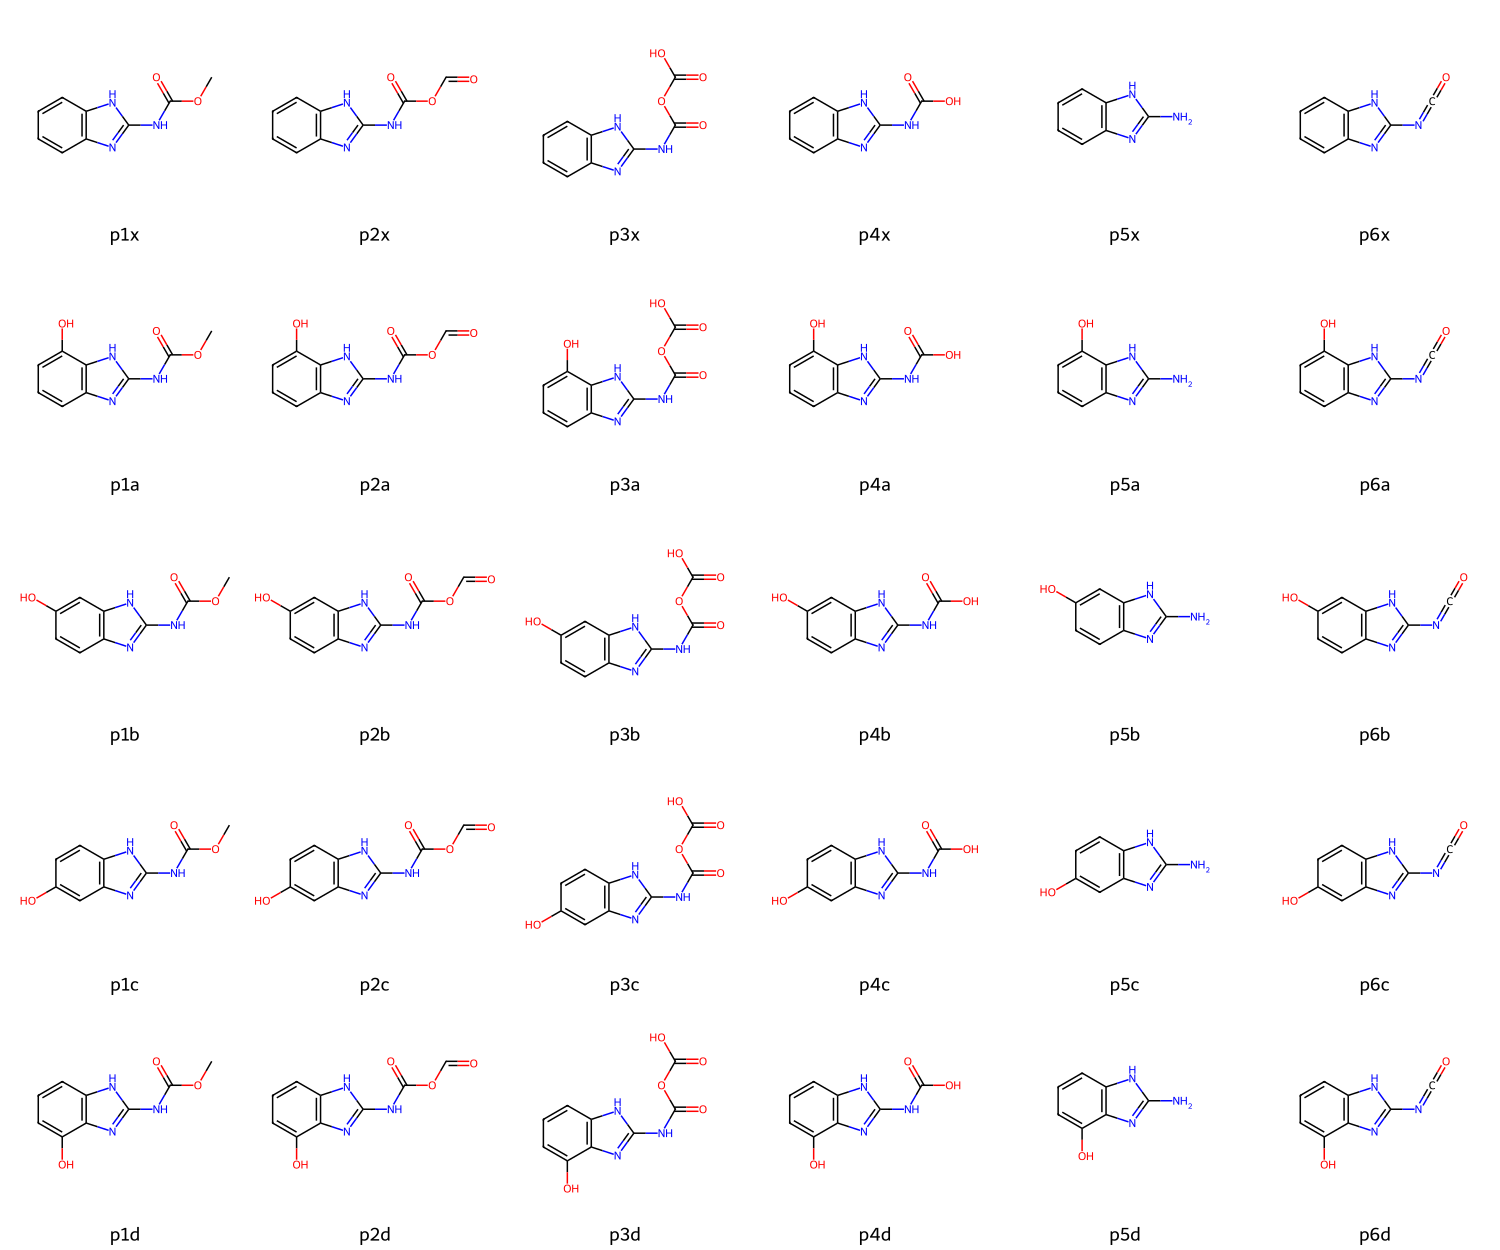

In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D

# -----------------------------------------------------------
# 1. Define your data input (same as before)
# -----------------------------------------------------------
datasets = [[0, 1, 2, 3, 4, 5],
            [6, 7, 8, 9, 10, 11],
            [12, 13, 14, 15, 16, 17],
            [18, 19, 20, 21, 22, 23],
            [24, 25, 26, 27, 28, 29]]

labels_input = [["p1x", "p2x", "p3x", "p4x", "p5x", "p6x"],
                ["p1a", "p2a", "p3a", "p4a", "p5a", "p6a"],
                ["p1b", "p2b", "p3b", "p4b", "p5b", "p6b"],
                ["p1c", "p2c", "p3c", "p4c", "p5c", "p6c"],
                ["p1d", "p2d", "p3d", "p4d", "p5d", "p6d"]]

# -----------------------------------------------------------
# 2. Prepare molecules and labels
# -----------------------------------------------------------
molsPerRow = max(len(row) for row in datasets)
molecules = []
labels_list = []

for i in range(len(datasets)):
    for j in range(len(datasets[i])):
        idx = datasets[i][j]
        if idx in df.index:
            mol = Chem.MolFromSmiles(df['smiles'][idx])
            if mol:
                AllChem.Compute2DCoords(mol)
                molecules.append(mol)
            else:
                molecules.append(None)
            labels_list.append(labels_input[i][j])
        else:
            molecules.append(None)
            labels_list.append("")

# -----------------------------------------------------------
# 3. Define and compute coordinates for the alignment core
# -----------------------------------------------------------
core = Chem.MolFromSmiles('c1cccc2c1[nH]c(n2)N')
AllChem.Compute2DCoords(core)

# -----------------------------------------------------------
# 4. Align and flip molecules
# -----------------------------------------------------------
for m in molecules:
    if m is not None:
        # Align to core if it matches
        if m.HasSubstructMatch(core):
            AllChem.GenerateDepictionMatching2DStructure(m, core)

        # --- Optional: flip across X-axis (mirror vertically) ---
        conf = m.GetConformer()
        for i in range(m.GetNumAtoms()):
            x, y, z = conf.GetAtomPosition(i)
            conf.SetAtomPosition(i, (x, -y, z))  # mirror vertically

# -----------------------------------------------------------
# 5. Configure drawing options (officially documented options)
# -----------------------------------------------------------
drawOptions = rdMolDraw2D.MolDrawOptions()
drawOptions.padding = 0.02               # tighter layout
drawOptions.legendFontSize = 18          # smaller labels
drawOptions.bondLineWidth = 1.5          # thicker bonds
drawOptions.fixedBondLength = 20.0       # zoom molecules slightly
drawOptions.dummiesAreAttachments = True # draw R groups cleanly

# -----------------------------------------------------------
# 6. Draw the aligned molecules as a grid image
# -----------------------------------------------------------
img = Draw.MolsToGridImage(
    molecules,
    molsPerRow=molsPerRow,
    subImgSize=(250, 250),
    legends=labels_list,
    drawOptions=drawOptions
)

img


# Workingspace

## Multi

### 1. Gibss

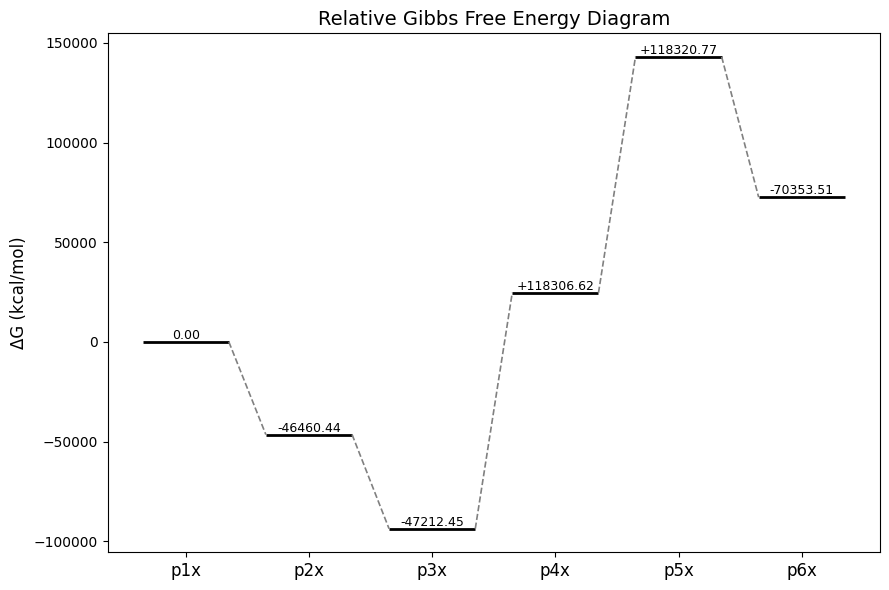

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# === Input datasets ===
datasets = [0, 1, 2, 3, 4, 5]
labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x"]

# Conversion factor: Hartree → kcal/mol
hartree_to_kcalmol = 627.503

# === Extract Gibbs energies ===
gibbs_data = []
for i, label in zip(datasets, labels_input):
    try:
        g = df["gibbs_energy_Eh"].iloc[i] * hartree_to_kcalmol
        gibbs_data.append((label, g))
    except Exception as e:
        print(f"⚠️ Skipped dataset {i} ({label}): {e}")

# === Convert to DataFrame ===
gibbs_df = pd.DataFrame(gibbs_data, columns=["Label", "Gibbs (kcal/mol)"])

# Reference = first dataset
ref_energy = gibbs_df["Gibbs (kcal/mol)"].iloc[0]
gibbs_df["DeltaG (kcal/mol)"] = gibbs_df["Gibbs (kcal/mol)"] - ref_energy

# Calculate step-by-step energy changes
gibbs_df["Step ΔG"] = gibbs_df["Gibbs (kcal/mol)"].diff().fillna(0)

# === Plot ===
n_datasets = len(gibbs_df)
fig_width = max(2, n_datasets * 1.5)
plt.figure(figsize=(fig_width, 6))

overaxis = 0.35  # half-width of each bar

x_positions = range(1, n_datasets + 1)
energies = gibbs_df["DeltaG (kcal/mol)"].values
step_changes = gibbs_df["Step ΔG"].values

# Plot horizontal bars (like orbital diagram)
for i, (x, energy, step_dg) in enumerate(zip(x_positions, energies, step_changes)):
    x_left = x - overaxis
    x_right = x + overaxis
    plt.hlines(energy, xmin=x_left, xmax=x_right, colors="black", lw=2)

    # Label with step-by-step ΔG (difference from previous)
    if i == 0:
        label_text = "0.00"  # First point is reference
    else:
        label_text = f"{step_dg:+.2f}"  # Show with +/- sign
    
    plt.text(x, energy + 0.5, label_text, ha="center", va="bottom", fontsize=9)

# Connect the bars with dashed lines
for i in range(n_datasets - 1):
    x1, x2 = (i + 1) + overaxis, (i + 2) - overaxis
    y1, y2 = energies[i], energies[i + 1]
    plt.plot([x1, x2], [y1, y2], "--", color="gray", lw=1.2)

# Labels & formatting
plt.xticks(x_positions, gibbs_df["Label"], fontsize=12)
plt.ylabel("ΔG (kcal/mol)", fontsize=12)
plt.title("Relative Gibbs Free Energy Diagram", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.show()

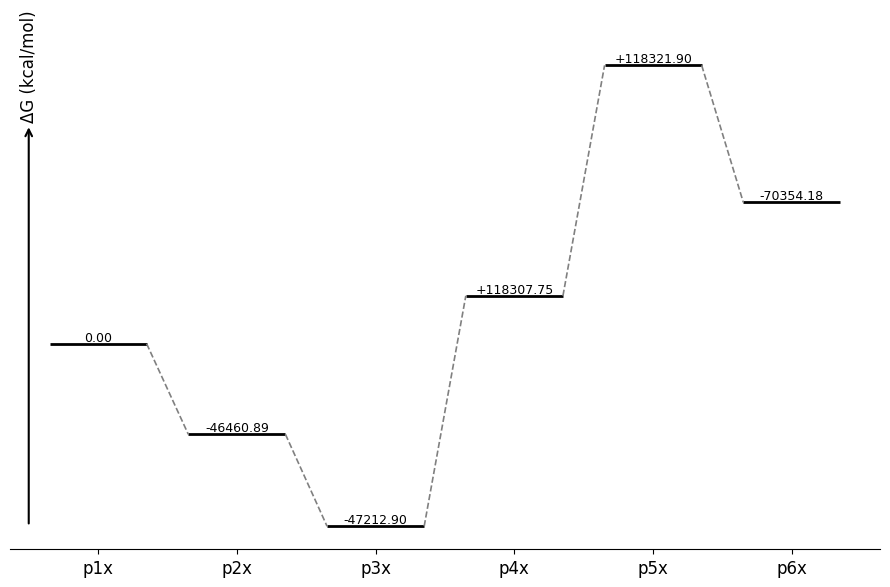

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# === Input datasets ===
datasets = [0, 1, 2, 3, 4, 5]
labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x"]

# Conversion factor: Hartree → kcal/mol
hartree_to_kcalmol = 627.509

# === Extract Gibbs energies ===
gibbs_data = []
for i, label in zip(datasets, labels_input):
    try:
        g = df["gibbs_energy_Eh"].iloc[i] * hartree_to_kcalmol
        gibbs_data.append((label, g))
    except Exception as e:
        print(f"⚠️ Skipped dataset {i} ({label}): {e}")

# === Convert to DataFrame ===
gibbs_df = pd.DataFrame(gibbs_data, columns=["Label", "Gibbs (kcal/mol)"])

# Reference = first dataset
ref_energy = gibbs_df["Gibbs (kcal/mol)"].iloc[0]
gibbs_df["DeltaG (kcal/mol)"] = gibbs_df["Gibbs (kcal/mol)"] - ref_energy

# Calculate step-by-step energy changes
gibbs_df["Step ΔG"] = gibbs_df["Gibbs (kcal/mol)"].diff().fillna(0)

# === Plot ===
n_datasets = len(gibbs_df)
fig_width = max(2, n_datasets * 1.5)
fig, ax = plt.subplots(figsize=(fig_width, 6))

overaxis = 0.35  # half-width of each bar

x_positions = range(1, n_datasets + 1)
energies = gibbs_df["DeltaG (kcal/mol)"].values
step_changes = gibbs_df["Step ΔG"].values

# Plot horizontal bars (like orbital diagram)
for i, (x, energy, step_dg) in enumerate(zip(x_positions, energies, step_changes)):
    x_left = x - overaxis
    x_right = x + overaxis
    ax.hlines(energy, xmin=x_left, xmax=x_right, colors="black", lw=2)

    # Label with step-by-step ΔG (difference from previous)
    if i == 0:
        label_text = "0.00"  # First point is reference
    else:
        label_text = f"{step_dg:+.2f}"  # Show with +/- sign
    
    ax.text(x, energy + 0.5, label_text,
            ha="center", va="bottom", fontsize=9)

# Connect the bars with dashed lines
for i in range(n_datasets - 1):
    x1, x2 = (i + 1) + overaxis, (i + 2) - overaxis
    y1, y2 = energies[i], energies[i + 1]
    ax.plot([x1, x2], [y1, y2], "--", color="gray", lw=1.2)

# Hide the y-axis completely
ax.get_yaxis().set_visible(False)
ax.spines["left"].set_visible(False)

# Add vertical arrow annotation for ΔG
ymin, ymax = min(energies) - 5, max(energies) + 5
arrow_x = 0.5  # place arrow at left margin inside the plot
ax.annotate("ΔG (kcal/mol)",
            xy=(arrow_x, ymin), xycoords="data",
            xytext=(arrow_x, ymax), textcoords="data",
            arrowprops=dict(arrowstyle="<-", lw=1.5, color="black"),
            ha="center", va="center", rotation=90, fontsize=12)

# Format x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(gibbs_df["Label"], fontsize=12)

# Remove top/right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.set_title("Relative Gibbs Free Energy Diagram", fontsize=14)
plt.tight_layout()
plt.show()

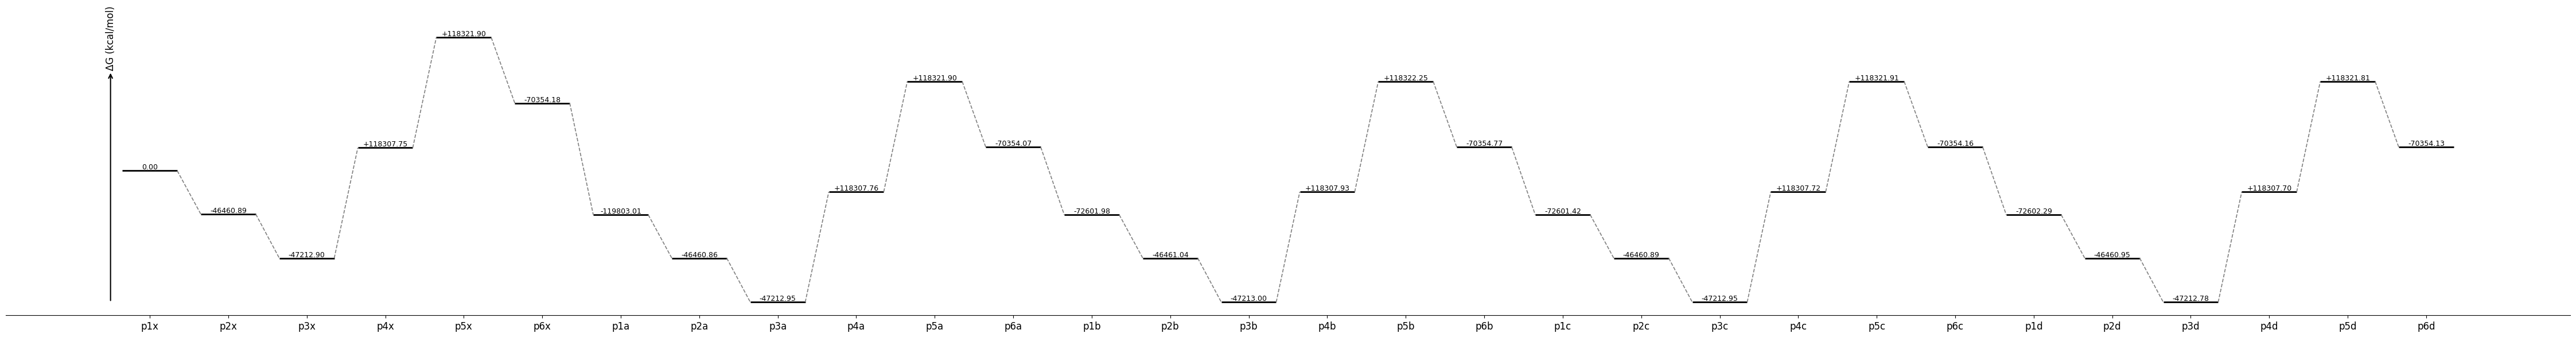

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# === Input datasets ===
datasets = [0, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10, 11, 
            12, 13, 14, 15, 16, 17, 
            18, 19, 20, 21, 22, 23, 
            24, 25, 26, 27, 28, 29]
labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x", 
                "p1a", "p2a", "p3a", "p4a", "p5a", "p6a",
                "p1b", "p2b", "p3b", "p4b", "p5b", "p6b",
                "p1c", "p2c", "p3c", "p4c", "p5c", "p6c",
                "p1d", "p2d", "p3d", "p4d", "p5d", "p6d"]

# Conversion factor: Hartree → kcal/mol
hartree_to_kcalmol = 627.509

# === Extract Gibbs energies ===
gibbs_data = []
for i, label in zip(datasets, labels_input):
    try:
        g = df["gibbs_energy_Eh"].iloc[i] * hartree_to_kcalmol
        gibbs_data.append((label, g))
    except Exception as e:
        print(f"⚠️ Skipped dataset {i} ({label}): {e}")

# === Convert to DataFrame ===
gibbs_df = pd.DataFrame(gibbs_data, columns=["Label", "Gibbs (kcal/mol)"])

# Reference = first dataset
ref_energy = gibbs_df["Gibbs (kcal/mol)"].iloc[0]
gibbs_df["DeltaG (kcal/mol)"] = gibbs_df["Gibbs (kcal/mol)"] - ref_energy

# Calculate step-by-step energy changes
gibbs_df["Step ΔG"] = gibbs_df["Gibbs (kcal/mol)"].diff().fillna(0)

# === Plot ===
n_datasets = len(gibbs_df)
fig_width = max(2, n_datasets * 1.5)
fig, ax = plt.subplots(figsize=(fig_width, 6))

overaxis = 0.35  # half-width of each bar

x_positions = range(1, n_datasets + 1)
energies = gibbs_df["DeltaG (kcal/mol)"].values
step_changes = gibbs_df["Step ΔG"].values

# Plot horizontal bars (like orbital diagram)
for i, (x, energy, step_dg) in enumerate(zip(x_positions, energies, step_changes)):
    x_left = x - overaxis
    x_right = x + overaxis
    ax.hlines(energy, xmin=x_left, xmax=x_right, colors="black", lw=2)

    # Label with step-by-step ΔG (difference from previous)
    if i == 0:
        label_text = "0.00"  # First point is reference
    else:
        label_text = f"{step_dg:+.2f}"  # Show with +/- sign
    
    ax.text(x, energy + 0.5, label_text,
            ha="center", va="bottom", fontsize=9)

# Connect the bars with dashed lines
for i in range(n_datasets - 1):
    x1, x2 = (i + 1) + overaxis, (i + 2) - overaxis
    y1, y2 = energies[i], energies[i + 1]
    ax.plot([x1, x2], [y1, y2], "--", color="gray", lw=1.2)

# Hide the y-axis completely
ax.get_yaxis().set_visible(False)
ax.spines["left"].set_visible(False)

# Add vertical arrow annotation for ΔG
ymin, ymax = min(energies) - 5, max(energies) + 5
arrow_x = 0.5  # place arrow at left margin inside the plot
ax.annotate("ΔG (kcal/mol)",
            xy=(arrow_x, ymin), xycoords="data",
            xytext=(arrow_x, ymax), textcoords="data",
            arrowprops=dict(arrowstyle="<-", lw=1.5, color="black"),
            ha="center", va="center", rotation=90, fontsize=12)

# Format x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(gibbs_df["Label"], fontsize=12)

# Remove top/right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.set_title("Relative Gibbs Free Energy Diagram", fontsize=14)
plt.tight_layout()
plt.show()

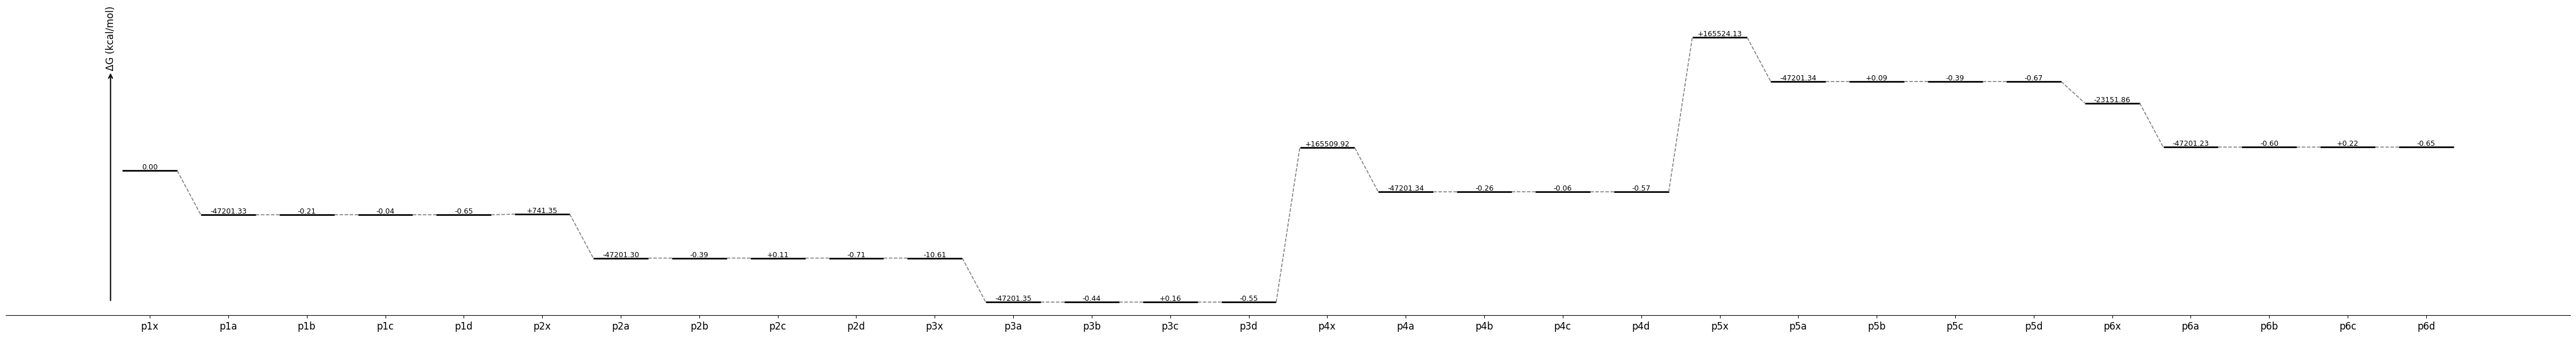

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# === Input datasets ===
datasets = [0, 6, 12, 18, 24,
            1, 7, 13, 19, 25,
            2, 8, 14, 20, 26,
            3, 9, 15, 21, 27,
            4, 10, 16, 22, 28,
            5, 11, 17, 23, 29]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d",
                "p2x", "p2a", "p2b", "p2c", "p2d",
                "p3x", "p3a", "p3b", "p3c", "p3d",
                "p4x", "p4a", "p4b", "p4c", "p4d",
                "p5x", "p5a", "p5b", "p5c", "p5d",
                "p6x", "p6a", "p6b", "p6c", "p6d"]

# Conversion factor: Hartree → kcal/mol
hartree_to_kcalmol = 627.509

# === Extract Gibbs energies ===
gibbs_data = []
for i, label in zip(datasets, labels_input):
    try:
        g = df["gibbs_energy_Eh"].iloc[i] * hartree_to_kcalmol
        gibbs_data.append((label, g))
    except Exception as e:
        print(f"⚠️ Skipped dataset {i} ({label}): {e}")

# === Convert to DataFrame ===
gibbs_df = pd.DataFrame(gibbs_data, columns=["Label", "Gibbs (kcal/mol)"])

# Reference = first dataset
ref_energy = gibbs_df["Gibbs (kcal/mol)"].iloc[0]
gibbs_df["DeltaG (kcal/mol)"] = gibbs_df["Gibbs (kcal/mol)"] - ref_energy

# Calculate step-by-step energy changes
gibbs_df["Step ΔG"] = gibbs_df["Gibbs (kcal/mol)"].diff().fillna(0)

# === Plot ===
n_datasets = len(gibbs_df)
fig_width = max(2, n_datasets * 1.5)
fig, ax = plt.subplots(figsize=(fig_width, 6))

overaxis = 0.35  # half-width of each bar

x_positions = range(1, n_datasets + 1)
energies = gibbs_df["DeltaG (kcal/mol)"].values
step_changes = gibbs_df["Step ΔG"].values

# Plot horizontal bars (like orbital diagram)
for i, (x, energy, step_dg) in enumerate(zip(x_positions, energies, step_changes)):
    x_left = x - overaxis
    x_right = x + overaxis
    ax.hlines(energy, xmin=x_left, xmax=x_right, colors="black", lw=2)

    # Label with step-by-step ΔG (difference from previous)
    if i == 0:
        label_text = "0.00"  # First point is reference
    else:
        label_text = f"{step_dg:+.2f}"  # Show with +/- sign
    
    ax.text(x, energy + 0.5, label_text,
            ha="center", va="bottom", fontsize=9)

# Connect the bars with dashed lines
for i in range(n_datasets - 1):
    x1, x2 = (i + 1) + overaxis, (i + 2) - overaxis
    y1, y2 = energies[i], energies[i + 1]
    ax.plot([x1, x2], [y1, y2], "--", color="gray", lw=1.2)

# Hide the y-axis completely
ax.get_yaxis().set_visible(False)
ax.spines["left"].set_visible(False)

# Add vertical arrow annotation for ΔG
ymin, ymax = min(energies) - 5, max(energies) + 5
arrow_x = 0.5  # place arrow at left margin inside the plot
ax.annotate("ΔG (kcal/mol)",
            xy=(arrow_x, ymin), xycoords="data",
            xytext=(arrow_x, ymax), textcoords="data",
            arrowprops=dict(arrowstyle="<-", lw=1.5, color="black"),
            ha="center", va="center", rotation=90, fontsize=12)

# Format x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(gibbs_df["Label"], fontsize=12)

# Remove top/right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.set_title("Relative Gibbs Free Energy Diagram", fontsize=14)
plt.tight_layout()
plt.show()

### 2. Energy Gap

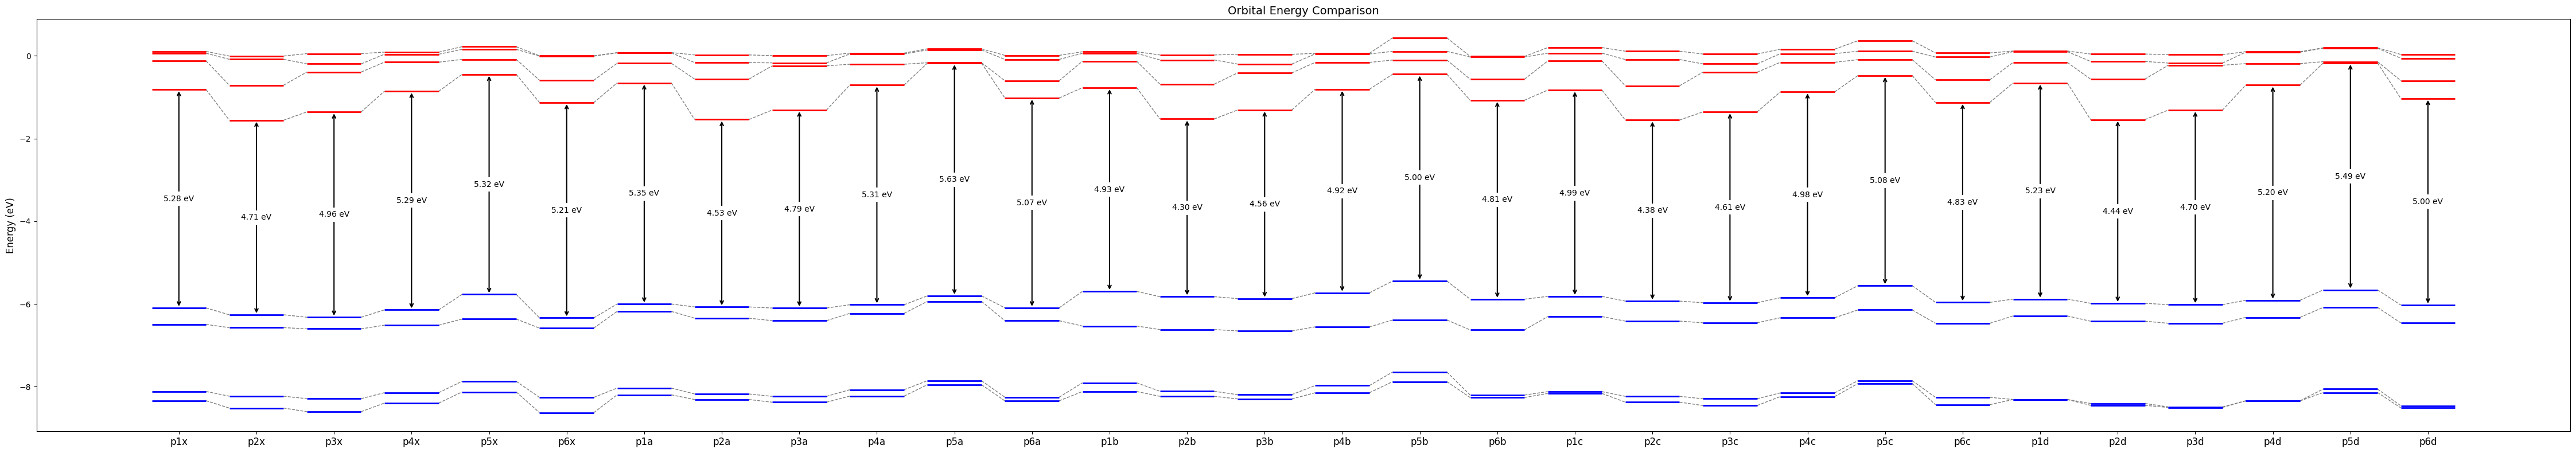

In [10]:
# Load orbital energies for multiple datasets
# Format options:
# datasets = [1, 2, 3]         - Simple list: connects all adjacent (1-2, 2-3)
# datasets = [[1, 2], [3, 4]]  - Nested list: connects within groups only (1-2, 3-4)
datasets = [0, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10, 11, 
            12, 13, 14, 15, 16, 17, 
            18, 19, 20, 21, 22, 23, 
            24, 25, 26, 27, 28, 29]


# Manual labels - must match the structure of datasets
# For flat datasets: ["Label1", "Label2", "Label3"]
# For nested datasets: [["Label1"], ["Label2", "Label3"]]
labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x",
                "p1a", "p2a", "p3a", "p4a", "p5a", "p6a",
                "p1b", "p2b", "p3b", "p4b", "p5b", "p6b",
                "p1c", "p2c", "p3c", "p4c", "p5c", "p6c",
                "p1d", "p2d", "p3d", "p4d", "p5d", "p6d"]

n_orbitals = 8  # Number of orbitals to display above and below the gap
overaxis = .35

# Handle both flat and nested list formats
if any(isinstance(item, list) for item in datasets):
    # Nested format: [[1,2], [3,4,6], [5]]
    flat_datasets = [item for sublist in datasets for item in (sublist if isinstance(sublist, list) else [sublist])]
    connection_groups = datasets
    # Flatten labels to match flat_datasets
    flat_labels = [item for sublist in labels_input for item in (sublist if isinstance(sublist, list) else [sublist])]
else:
    # Flat format: [1, 2, 3]
    flat_datasets = datasets
    connection_groups = [datasets]  # Treat all as one group
    flat_labels = labels_input

# Verify labels match datasets
if len(flat_labels) != len(flat_datasets):
    raise ValueError(f"Number of labels ({len(flat_labels)}) must match number of datasets ({len(flat_datasets)})")

df_oe_list = [pd.DataFrame(df["orbitals"][i]) for i in flat_datasets]

# Calculate data for all datasets
orbital_data = []
for i, df_oe in enumerate(df_oe_list):
    # Separate occupied and virtual orbitals
    occupied = df_oe[df_oe["OCC"] > 0].sort_values("eV")
    virtual  = df_oe[df_oe["OCC"] == 0].sort_values("eV")

    # Extract HOMO and LUMO
    homo = occupied["eV"].max()
    lumo = virtual["eV"].min()
    gap = lumo - homo

    # Select orbitals
    sel_occ = occupied.tail(int(n_orbitals*.5))
    sel_vir = virtual.head(int(n_orbitals*.5))
    selected_orbs = pd.concat([sel_occ, sel_vir])
    
    orbital_data.append({
        'selected_orbs': selected_orbs,
        'homo': homo,
        'lumo': lumo,
        'gap': gap,
        'label': flat_labels[i]
    })

# Plot
n_datasets = len(orbital_data)
fig_width = max(2, n_datasets * 1.5)  # Adjust width based on number of datasets
plt.figure(figsize=(fig_width, 8))

# Plot each dataset
for i, data in enumerate(orbital_data):
    x_center = i + 1
    x_left = x_center - overaxis
    x_right = x_center + overaxis
    
    # Orbital levels with different colors for HOMO/LUMO
    for _, row in data['selected_orbs'].iterrows():
        e = row["eV"]
        occ = row["OCC"]
        
        # Color based on occupation: blue for occupied (HOMO), red for virtual (LUMO)
        color = "blue" if occ > 0 else "red"
        plt.hlines(e, xmin=x_left, xmax=x_right, colors=color, lw=2)

    # Vertical arrow centered at x position
    plt.annotate("", xy=(x_center, data['lumo']), xytext=(x_center, data['homo']),
                 arrowprops=dict(arrowstyle="<->", lw=1.5, color="black"))

    # Gap label
    plt.text(x_center, (data['homo'] + data['lumo']) / 2, f"{data['gap']:.2f} eV",
             va="center", ha="center", color="black", fontsize=10,
             bbox=dict(facecolor="white", edgecolor="none", alpha=1))

# Add dashed lines connecting same orbital levels across datasets
if n_datasets > 1:
    # Get orbital energies for each dataset, sorted consistently
    all_occupied = []
    all_virtual = []
    
    for data in orbital_data:
        occupied = data['selected_orbs'][data['selected_orbs']["OCC"] > 0].sort_values("eV", ascending=False)
        virtual = data['selected_orbs'][data['selected_orbs']["OCC"] == 0].sort_values("eV")
        all_occupied.append(occupied["eV"].values)
        all_virtual.append(virtual["eV"].values)
    
    # Create connections based on grouping
    # Track position in the plot (not dataset index)
    plot_position = 0
    for group in connection_groups:
        if isinstance(group, list) and len(group) > 1:
            # Connect consecutive datasets within this group based on plot position
            group_positions = list(range(plot_position, plot_position + len(group)))
            
            # Connect occupied orbitals within this group
            max_occ = min(len(all_occupied[pos]) for pos in group_positions)
            for level in range(max_occ):
                for i in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[i], group_positions[i + 1]
                    x_start = (pos1 + 1) + overaxis  # Right edge of current bar
                    x_end = (pos2 + 1) - overaxis    # Left edge of next bar
                    y_start = all_occupied[pos1][level]
                    y_end = all_occupied[pos2][level]
                    plt.plot([x_start, x_end], [y_start, y_end], '--', color='gray', alpha=1, lw=1, zorder=0)
            
            # Connect virtual orbitals within this group
            max_vir = min(len(all_virtual[pos]) for pos in group_positions)
            for level in range(max_vir):
                for i in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[i], group_positions[i + 1]
                    x_start = (pos1 + 1) + overaxis  # Right edge of current bar
                    x_end = (pos2 + 1) - overaxis    # Left edge of next bar
                    y_start = all_virtual[pos1][level]
                    y_end = all_virtual[pos2][level]
                    plt.plot([x_start, x_end], [y_start, y_end], '--', color='gray', alpha=1, lw=1, zorder=0)
        
        # Update plot position for next group
        if isinstance(group, list):
            plot_position += len(group)
        else:
            plot_position += 1

# Labels and style
plt.ylabel("Energy (eV)", fontsize=12)
plt.xticks(range(1, n_datasets + 1), [data['label'] for data in orbital_data], fontsize=12)
plt.title("Orbital Energy Comparison", fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

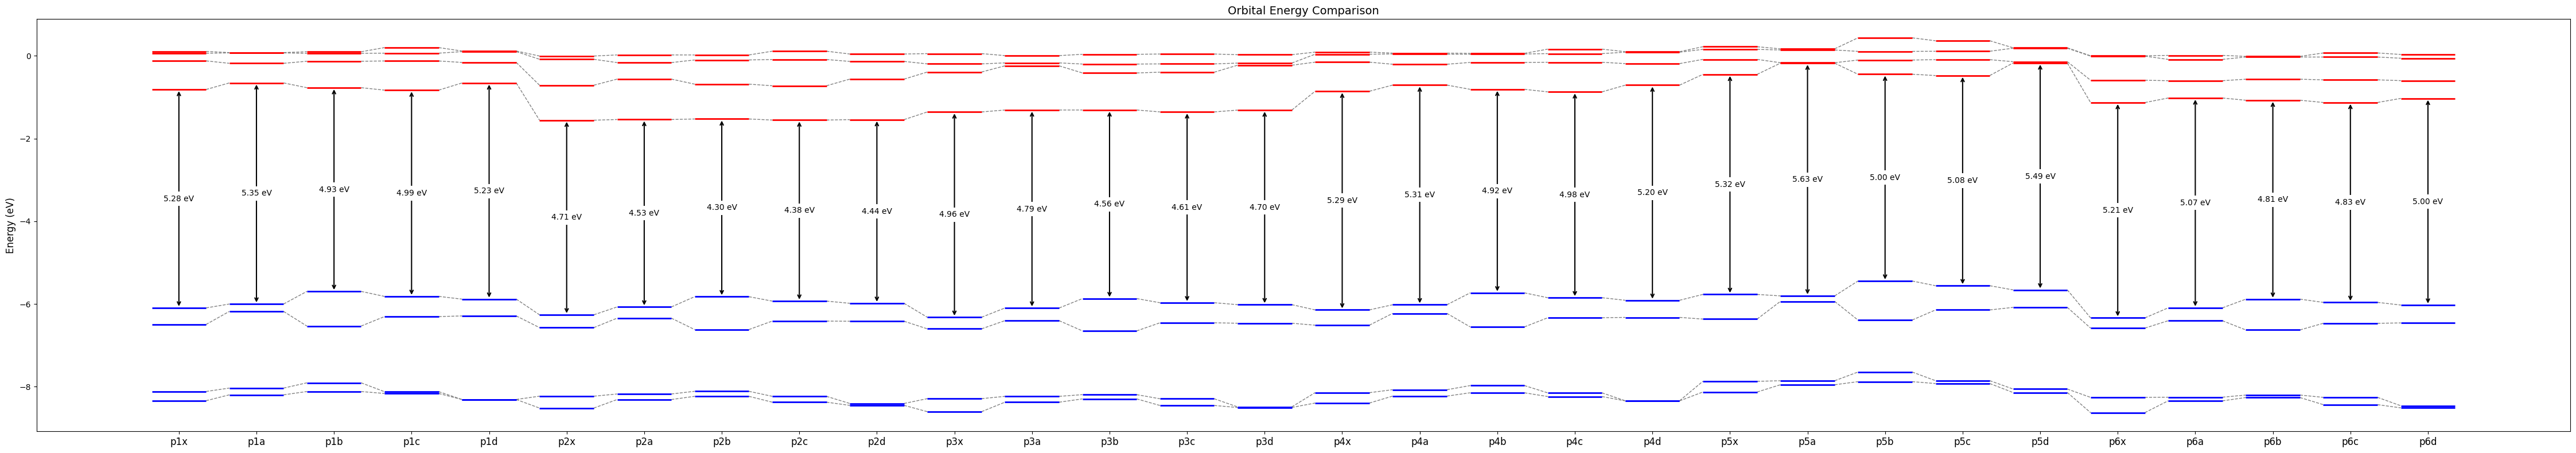

In [11]:
# Load orbital energies for multiple datasets
# Format options:
# datasets = [1, 2, 3]         - Simple list: connects all adjacent (1-2, 2-3)
# datasets = [[1, 2], [3, 4]]  - Nested list: connects within groups only (1-2, 3-4)
datasets = [0, 6, 12, 18, 24,
            1, 7, 13, 19, 25,
            2, 8, 14, 20, 26,
            3, 9, 15, 21, 27,
            4, 10, 16, 22, 28,
            5, 11, 17, 23, 29]


# Manual labels - must match the structure of datasets
# For flat datasets: ["Label1", "Label2", "Label3"]
# For nested datasets: [["Label1"], ["Label2", "Label3"]]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d",
                "p2x", "p2a", "p2b", "p2c", "p2d",
                "p3x", "p3a", "p3b", "p3c", "p3d",
                "p4x", "p4a", "p4b", "p4c", "p4d",
                "p5x", "p5a", "p5b", "p5c", "p5d",
                "p6x", "p6a", "p6b", "p6c", "p6d"]

n_orbitals = 8  # Number of orbitals to display above and below the gap
overaxis = .35

# Handle both flat and nested list formats
if any(isinstance(item, list) for item in datasets):
    # Nested format: [[1,2], [3,4,6], [5]]
    flat_datasets = [item for sublist in datasets for item in (sublist if isinstance(sublist, list) else [sublist])]
    connection_groups = datasets
    # Flatten labels to match flat_datasets
    flat_labels = [item for sublist in labels_input for item in (sublist if isinstance(sublist, list) else [sublist])]
else:
    # Flat format: [1, 2, 3]
    flat_datasets = datasets
    connection_groups = [datasets]  # Treat all as one group
    flat_labels = labels_input

# Verify labels match datasets
if len(flat_labels) != len(flat_datasets):
    raise ValueError(f"Number of labels ({len(flat_labels)}) must match number of datasets ({len(flat_datasets)})")

df_oe_list = [pd.DataFrame(df["orbitals"][i]) for i in flat_datasets]

# Calculate data for all datasets
orbital_data = []
for i, df_oe in enumerate(df_oe_list):
    # Separate occupied and virtual orbitals
    occupied = df_oe[df_oe["OCC"] > 0].sort_values("eV")
    virtual  = df_oe[df_oe["OCC"] == 0].sort_values("eV")

    # Extract HOMO and LUMO
    homo = occupied["eV"].max()
    lumo = virtual["eV"].min()
    gap = lumo - homo

    # Select orbitals
    sel_occ = occupied.tail(int(n_orbitals*.5))
    sel_vir = virtual.head(int(n_orbitals*.5))
    selected_orbs = pd.concat([sel_occ, sel_vir])
    
    orbital_data.append({
        'selected_orbs': selected_orbs,
        'homo': homo,
        'lumo': lumo,
        'gap': gap,
        'label': flat_labels[i]
    })

# Plot
n_datasets = len(orbital_data)
fig_width = max(2, n_datasets * 1.5)  # Adjust width based on number of datasets
plt.figure(figsize=(fig_width, 8))

# Plot each dataset
for i, data in enumerate(orbital_data):
    x_center = i + 1
    x_left = x_center - overaxis
    x_right = x_center + overaxis
    
    # Orbital levels with different colors for HOMO/LUMO
    for _, row in data['selected_orbs'].iterrows():
        e = row["eV"]
        occ = row["OCC"]
        
        # Color based on occupation: blue for occupied (HOMO), red for virtual (LUMO)
        color = "blue" if occ > 0 else "red"
        plt.hlines(e, xmin=x_left, xmax=x_right, colors=color, lw=2)

    # Vertical arrow centered at x position
    plt.annotate("", xy=(x_center, data['lumo']), xytext=(x_center, data['homo']),
                 arrowprops=dict(arrowstyle="<->", lw=1.5, color="black"))

    # Gap label
    plt.text(x_center, (data['homo'] + data['lumo']) / 2, f"{data['gap']:.2f} eV",
             va="center", ha="center", color="black", fontsize=10,
             bbox=dict(facecolor="white", edgecolor="none", alpha=1))

# Add dashed lines connecting same orbital levels across datasets
if n_datasets > 1:
    # Get orbital energies for each dataset, sorted consistently
    all_occupied = []
    all_virtual = []
    
    for data in orbital_data:
        occupied = data['selected_orbs'][data['selected_orbs']["OCC"] > 0].sort_values("eV", ascending=False)
        virtual = data['selected_orbs'][data['selected_orbs']["OCC"] == 0].sort_values("eV")
        all_occupied.append(occupied["eV"].values)
        all_virtual.append(virtual["eV"].values)
    
    # Create connections based on grouping
    # Track position in the plot (not dataset index)
    plot_position = 0
    for group in connection_groups:
        if isinstance(group, list) and len(group) > 1:
            # Connect consecutive datasets within this group based on plot position
            group_positions = list(range(plot_position, plot_position + len(group)))
            
            # Connect occupied orbitals within this group
            max_occ = min(len(all_occupied[pos]) for pos in group_positions)
            for level in range(max_occ):
                for i in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[i], group_positions[i + 1]
                    x_start = (pos1 + 1) + overaxis  # Right edge of current bar
                    x_end = (pos2 + 1) - overaxis    # Left edge of next bar
                    y_start = all_occupied[pos1][level]
                    y_end = all_occupied[pos2][level]
                    plt.plot([x_start, x_end], [y_start, y_end], '--', color='gray', alpha=1, lw=1, zorder=0)
            
            # Connect virtual orbitals within this group
            max_vir = min(len(all_virtual[pos]) for pos in group_positions)
            for level in range(max_vir):
                for i in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[i], group_positions[i + 1]
                    x_start = (pos1 + 1) + overaxis  # Right edge of current bar
                    x_end = (pos2 + 1) - overaxis    # Left edge of next bar
                    y_start = all_virtual[pos1][level]
                    y_end = all_virtual[pos2][level]
                    plt.plot([x_start, x_end], [y_start, y_end], '--', color='gray', alpha=1, lw=1, zorder=0)
        
        # Update plot position for next group
        if isinstance(group, list):
            plot_position += len(group)
        else:
            plot_position += 1

# Labels and style
plt.ylabel("Energy (eV)", fontsize=12)
plt.xticks(range(1, n_datasets + 1), [data['label'] for data in orbital_data], fontsize=12)
plt.title("Orbital Energy Comparison", fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

### 3. Raman

Skipping experimental Raman spectrum: name 'eks' is not defined


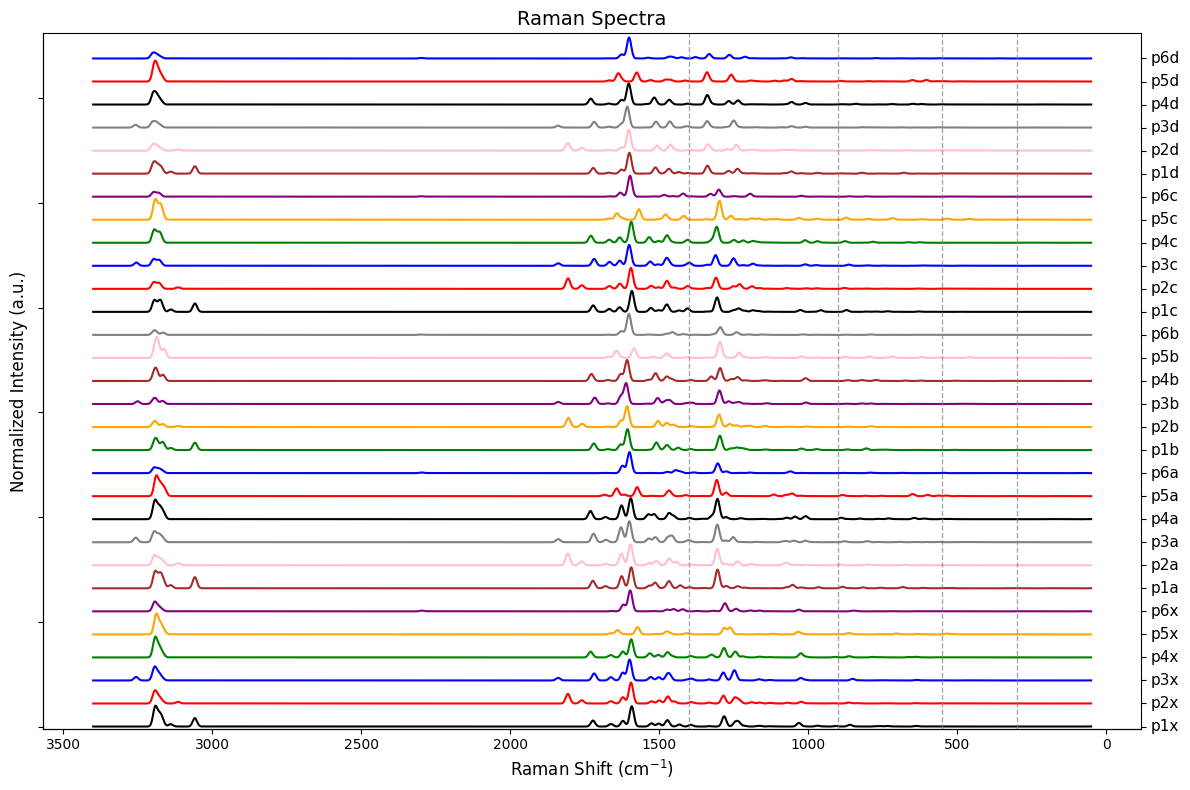

In [12]:
# === Input parameters ===
datasets = [0, 1, 2, 3, 4, 5,
            6, 7, 8, 9, 10, 11,
            12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23,
            24, 25, 26, 27, 28, 29]
labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x",
                "p1a", "p2a", "p3a", "p4a", "p5a", "p6a",
                "p1b", "p2b", "p3b", "p4b", "p5b", "p6b",
                "p1c", "p2c", "p3c", "p4c", "p5c", "p6c",
                "p1d", "p2d", "p3d", "p4d", "p5d", "p6d"]
y_space = 0.1  # Minimal vertical spacing between stacked spectra

# Define Raman shift grid
shifts = np.linspace(50, 3400, 5000)  # cm⁻¹

# Gaussian broadening width (FWHM in cm⁻¹)
fwhm = 17                                       # Full Width at Half Maximum
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))     # STD of the Gaussian

# Define colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Raman region boundaries
region_boundaries = [300, 550, 900, 1400]

# === Process multiple datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0  # track the top of stacked spectra

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    # Load dataframe for this dataset
    df_raman = pd.DataFrame(df["raman_spectrum"].iloc[dataset_idx])
    
    # Build continuous Raman spectrum
    spectrum = np.zeros_like(shifts)
    for _, row in df_raman.iterrows():
        nu0 = row["freq_cm-1"]
        inten = row["activity"]
        spectrum += inten * np.exp(-(shifts - nu0) ** 2 / (2 * sigma ** 2))
    
    # Normalize each spectrum to 1
    if spectrum.max() > 0:
        spectrum = spectrum / spectrum.max()
    
    spectra.append(spectrum)
    
    # === NEW offset system ===
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = spectrum.min()  # usually ~0
        # ensure minimal spacing
        y_offset = prev_top - this_bottom + y_space
    
    current_top = y_offset + spectrum.max()
    y_offsets.append(y_offset)
    
    # Plot spectrum with offset
    color = colors[i % len(colors)]
    ax.plot(shifts, spectrum + y_offset, color=color, lw=1.5)

# === Add experimental spectrum with position control ===
plot_position = 0  # choose index where exp should be placed UNDER

try:
    # Access Raman dataframe
    raman_df = eks["raman"]

    if raman_df is not None and len(raman_df) > 0:
        # Interpolate and normalize
        eks_interp = np.interp(
            shifts,
            raman_df["raman_freq"],
            raman_df["intensity"]
        )
        eks_interp = eks_interp / eks_interp.max()

        # Offset: place under the spectrum at plot_position
        ref_offset = y_offsets[plot_position]
        exp_offset = ref_offset - (eks_interp.max() + y_space)

        # Plot experimental spectrum
        ax.plot(shifts, eks_interp + exp_offset,
                color="black", lw=1.5, linestyle="--")

        # Insert into offsets and labels
        y_offsets.insert(plot_position, exp_offset)
        labels_input.insert(plot_position, "ph Exp")

except Exception as e:
    print(f"Skipping experimental Raman spectrum: {e}")

# === Formatting ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

ax.set_xlabel("Raman Shift (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Intensity (a.u.)", fontsize=12)

# Auto y-limit based on stacking
ax.set_ylim(min(y_offsets) - 0.1, max(y_offsets) + 1.2)

# Hide spines and ticks
ax.spines["right"].set_visible(False)
ax.set_yticklabels([])

# Create right y-axis for dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(y_offsets)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (like experimental Raman spectra)
ax.invert_xaxis()

plt.title("Raman Spectra", fontsize=14)
plt.tight_layout()
plt.show()


Skipping experimental Raman spectrum: name 'eks' is not defined


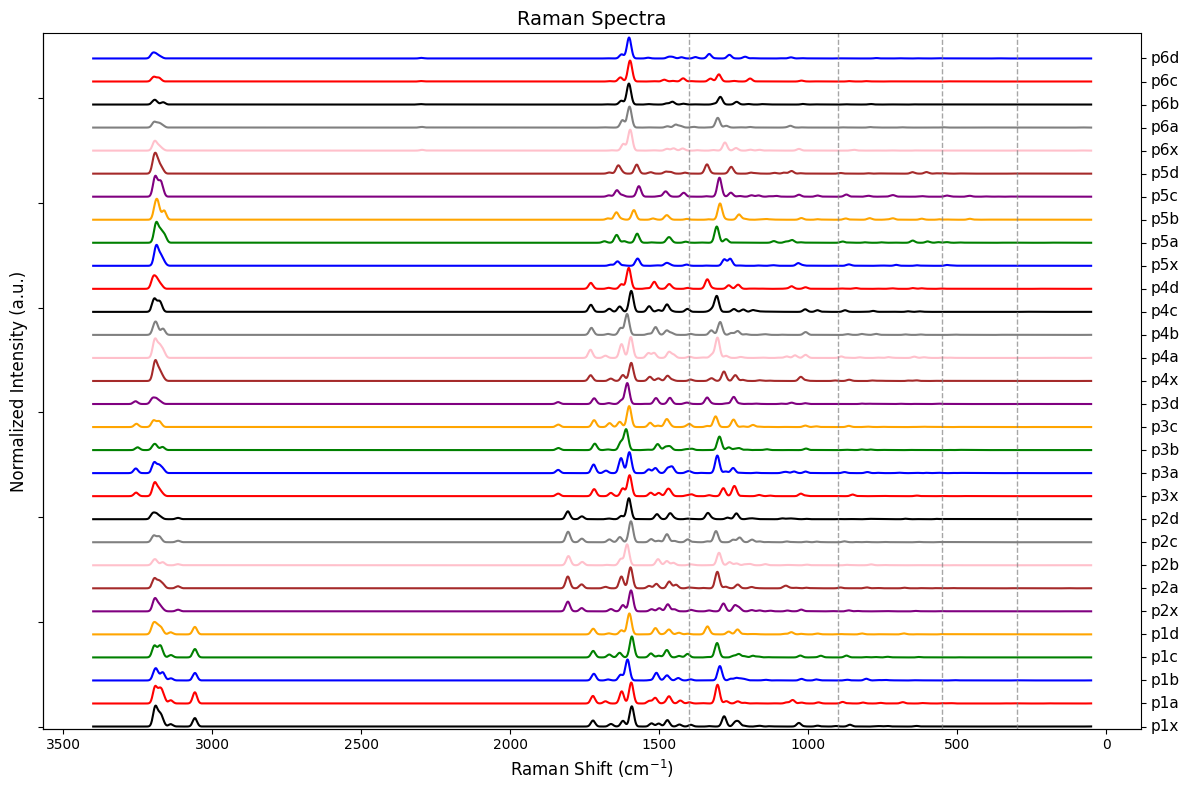

In [13]:
# === Input parameters ===
datasets = [0, 6, 12, 18, 24,
            1, 7, 13, 19, 25,
            2, 8, 14, 20, 26,
            3, 9, 15, 21, 27,
            4, 10, 16, 22, 28,
            5, 11, 17, 23, 29]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d",
                "p2x", "p2a", "p2b", "p2c", "p2d",
                "p3x", "p3a", "p3b", "p3c", "p3d",
                "p4x", "p4a", "p4b", "p4c", "p4d",
                "p5x", "p5a", "p5b", "p5c", "p5d",
                "p6x", "p6a", "p6b", "p6c", "p6d"]
y_space = 0.1  # Minimal vertical spacing between stacked spectra

# Define Raman shift grid
shifts = np.linspace(50, 3400, 5000)  # cm⁻¹

# Gaussian broadening width (FWHM in cm⁻¹)
fwhm = 17                                       # Full Width at Half Maximum
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))     # STD of the Gaussian

# Define colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Raman region boundaries
region_boundaries = [300, 550, 900, 1400]

# === Process multiple datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0  # track the top of stacked spectra

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    # Load dataframe for this dataset
    df_raman = pd.DataFrame(df["raman_spectrum"].iloc[dataset_idx])
    
    # Build continuous Raman spectrum
    spectrum = np.zeros_like(shifts)
    for _, row in df_raman.iterrows():
        nu0 = row["freq_cm-1"]
        inten = row["activity"]
        spectrum += inten * np.exp(-(shifts - nu0) ** 2 / (2 * sigma ** 2))
    
    # Normalize each spectrum to 1
    if spectrum.max() > 0:
        spectrum = spectrum / spectrum.max()
    
    spectra.append(spectrum)
    
    # === NEW offset system ===
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = spectrum.min()  # usually ~0
        # ensure minimal spacing
        y_offset = prev_top - this_bottom + y_space
    
    current_top = y_offset + spectrum.max()
    y_offsets.append(y_offset)
    
    # Plot spectrum with offset
    color = colors[i % len(colors)]
    ax.plot(shifts, spectrum + y_offset, color=color, lw=1.5)

# === Add experimental spectrum with position control ===
plot_position = 0  # choose index where exp should be placed UNDER

try:
    # Access Raman dataframe
    raman_df = eks["raman"]

    if raman_df is not None and len(raman_df) > 0:
        # Interpolate and normalize
        eks_interp = np.interp(
            shifts,
            raman_df["raman_freq"],
            raman_df["intensity"]
        )
        eks_interp = eks_interp / eks_interp.max()

        # Offset: place under the spectrum at plot_position
        ref_offset = y_offsets[plot_position]
        exp_offset = ref_offset - (eks_interp.max() + y_space)

        # Plot experimental spectrum
        ax.plot(shifts, eks_interp + exp_offset,
                color="black", lw=1.5, linestyle="--")

        # Insert into offsets and labels
        y_offsets.insert(plot_position, exp_offset)
        labels_input.insert(plot_position, "ph Exp")

except Exception as e:
    print(f"Skipping experimental Raman spectrum: {e}")

# === Formatting ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

ax.set_xlabel("Raman Shift (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Intensity (a.u.)", fontsize=12)

# Auto y-limit based on stacking
ax.set_ylim(min(y_offsets) - 0.1, max(y_offsets) + 1.2)

# Hide spines and ticks
ax.spines["right"].set_visible(False)
ax.set_yticklabels([])

# Create right y-axis for dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(y_offsets)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (like experimental Raman spectra)
ax.invert_xaxis()

plt.title("Raman Spectra", fontsize=14)
plt.tight_layout()
plt.show()


![](https://www.researchgate.net/publication/331500406/figure/fig3/AS:11431281212235055@1702568598624/a-Spectra-of-carbendazim-CBZ-A-Raman-spectrum-and-B-SERS-spectrum-of-10-M-CBZ.tif)

Skipping experimental Raman spectrum: name 'eks' is not defined


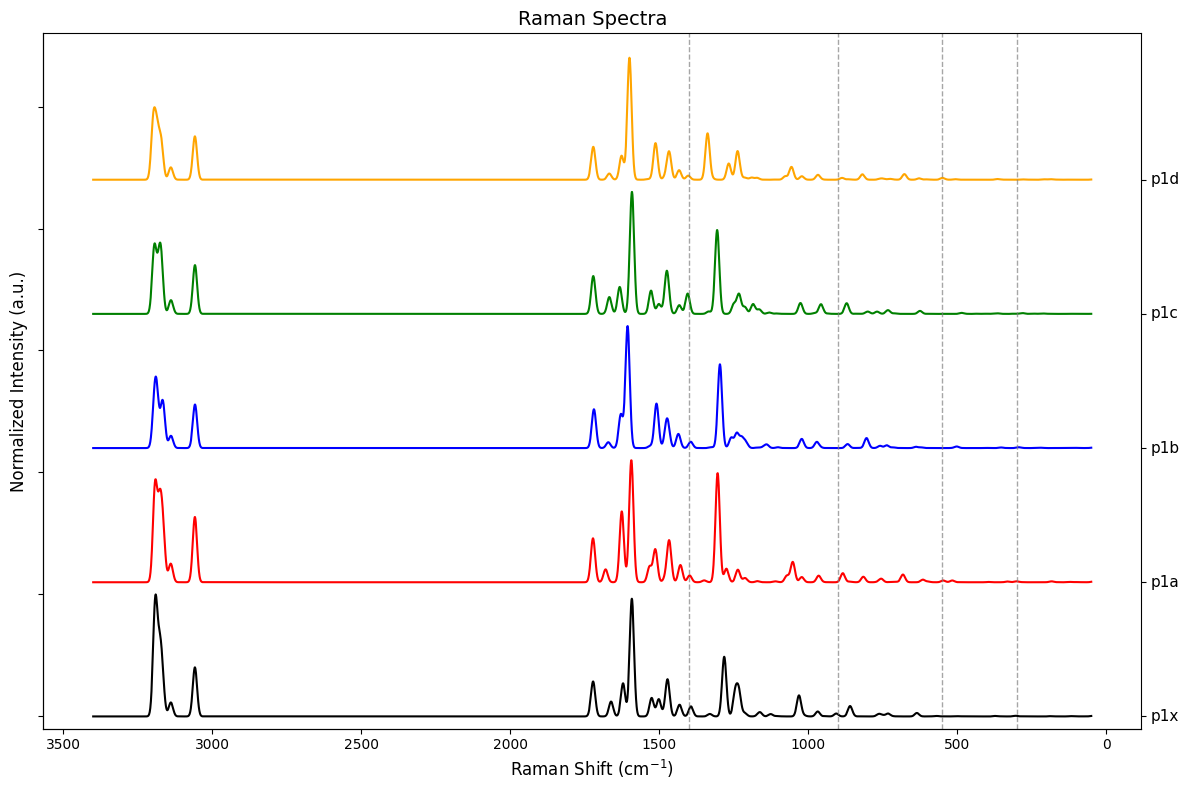

In [14]:
# === Input parameters ===
datasets = [0, 6, 12, 18, 24]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d"]
y_space = 0.1  # Minimal vertical spacing between stacked spectra

# Define Raman shift grid
shifts = np.linspace(50, 3400, 5000)  # cm⁻¹

# Gaussian broadening width (FWHM in cm⁻¹)
fwhm = 17  # Full Width at Half Maximum
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # STD of the Gaussian

# Define colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Raman region boundaries
region_boundaries = [300, 550, 900, 1400]

# === Process multiple datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0  # track the top of stacked spectra

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    # Load dataframe for this dataset
    df_raman = pd.DataFrame(df["raman_spectrum"].iloc[dataset_idx])
    
    # Build continuous Raman spectrum
    spectrum = np.zeros_like(shifts)
    for _, row in df_raman.iterrows():
        nu0 = row["freq_cm-1"]
        inten = row["activity"]
        spectrum += inten * np.exp(-(shifts - nu0) ** 2 / (2 * sigma ** 2))
    
    # Normalize each spectrum to 1
    if spectrum.max() > 0:
        spectrum = spectrum / spectrum.max()
    
    spectra.append(spectrum)
    
    # === NEW offset system ===
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = spectrum.min()  # usually ~0
        # ensure minimal spacing
        y_offset = prev_top - this_bottom + y_space
    
    current_top = y_offset + spectrum.max()
    y_offsets.append(y_offset)
    
    # Plot spectrum with offset
    color = colors[i % len(colors)]
    ax.plot(shifts, spectrum + y_offset, color=color, lw=1.5)

# === Add experimental spectrum with position control ===
plot_position = 0  # choose index where exp should be placed UNDER

try:
    # Access Raman dataframe
    raman_df = eks["raman"]

    if raman_df is not None and len(raman_df) > 0:
        # Interpolate and normalize
        eks_interp = np.interp(
            shifts,
            raman_df["raman_freq"],
            raman_df["intensity"]
        )
        eks_interp = eks_interp / eks_interp.max()

        # Offset: place under the spectrum at plot_position
        ref_offset = y_offsets[plot_position]
        exp_offset = ref_offset - (eks_interp.max() + y_space)

        # Plot experimental spectrum
        ax.plot(shifts, eks_interp + exp_offset,
                color="black", lw=1.5, linestyle="--")

        # Insert into offsets and labels
        y_offsets.insert(plot_position, exp_offset)
        labels_input.insert(plot_position, "ph Exp")

except Exception as e:
    print(f"Skipping experimental Raman spectrum: {e}")

# === Formatting ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

ax.set_xlabel("Raman Shift (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Intensity (a.u.)", fontsize=12)

# Auto y-limit based on stacking
ax.set_ylim(min(y_offsets) - 0.1, max(y_offsets) + 1.2)

# Hide spines and ticks
ax.spines["right"].set_visible(False)
ax.set_yticklabels([])

# Create right y-axis for dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(y_offsets)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (like experimental Raman spectra)
ax.invert_xaxis()

plt.title("Raman Spectra", fontsize=14)
plt.tight_layout()
plt.show()


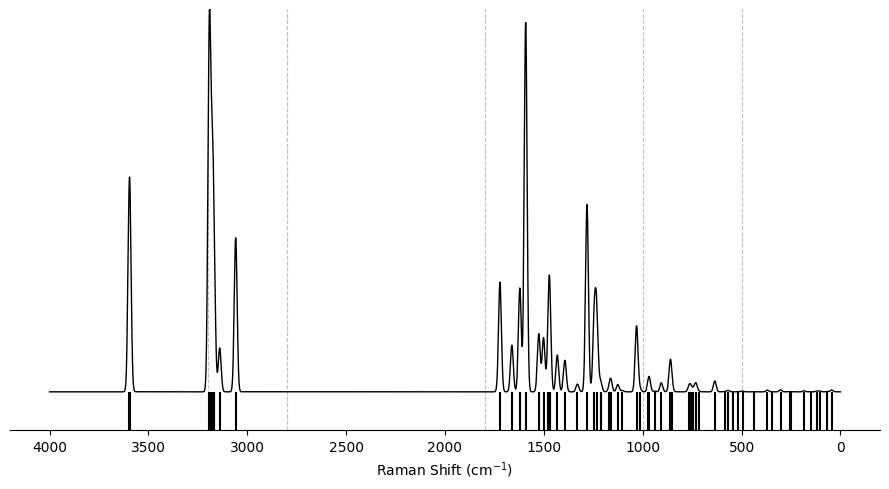

In [15]:
# Example dataframe
df_raman = pd.DataFrame(df["raman_spectrum"].iloc[0])

# Define Raman shift grid (adjust as needed)
shifts = np.linspace(0, 4000, 8000)  # cm⁻¹

# Gaussian broadening width (FWHM in cm⁻¹)
fwhm = 17  # Full Width at Half Maximum - Broadening
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # STD of the Gaussian function

# Build continuous Raman spectrum
spectrum = np.zeros_like(shifts)
for _, row in df_raman.iterrows():
    nu0 = row["freq_cm-1"]
    inten = row["activity"]
    spectrum += inten * np.exp(-(shifts - nu0) ** 2 / (2 * sigma ** 2))

# === Define regional boundaries ===
# Common Raman spectroscopy regions
region_boundaries = [
    500,   # Low frequency / lattice vibrations boundary
    1000,  # Fingerprint region start
    1800,  # C=O, C=C stretch region
    2800,  # C-H stretch region start
    3200   # O-H, N-H stretch region
]

# === Plot Raman figure ===
fig, ax = plt.subplots(figsize=(9, 5))

# Add regional boundaries first (so they appear behind the spectrum)
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)

# Continuous spectrum
ax.plot(shifts, spectrum, color="black", lw=1)

# Restrict dataframe to the same range as shifts
df_raman_filtered = df_raman[(df_raman["freq_cm-1"] >= shifts.min()) &
                              (df_raman["freq_cm-1"] <= shifts.max())]

# Stick spectrum (below baseline)
stick_height = spectrum.max() * 0.1
for _, row in df_raman_filtered.iterrows():
    ax.vlines(row["freq_cm-1"], -stick_height, 0, color="black")

# Formatting
ax.set_xlabel("Raman Shift (cm$^{-1}$)")
ax.set_ylabel("Intensity (a.u.)")

# Extend y so sticks visible
ax.set_ylim(-stick_height * 1, spectrum.max())

# Hide all spines except bottom
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)

# Hide y ticks and labels
ax.yaxis.set_visible(False)
ax.invert_xaxis()  # Raman shift decreases to the right

plt.tight_layout()
plt.show()

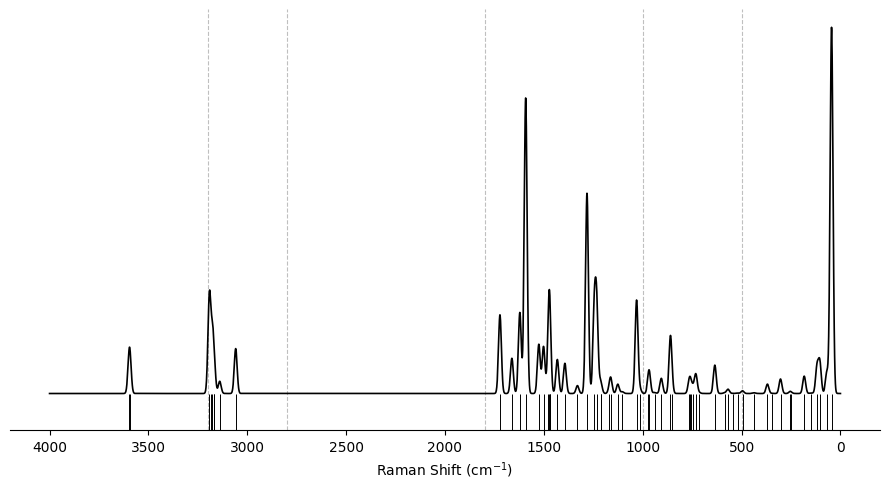

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Load Raman data ===
# Example dataframe structure: Mode, freq_cm-1, activity, depolarization
df_raman = pd.DataFrame(df["raman_spectrum"].iloc[0])

# === Physical constants ===
h = 6.62607015e-34      # Planck constant (J·s)
c = 2.99792458e10       # Speed of light (cm/s)
kB = 1.380649e-23       # Boltzmann constant (J/K)
T = 298.15              # Temperature (K)
laser_wavelength_nm = 532  # Laser wavelength (nm)
laser_wavenumber = 1e7 / laser_wavelength_nm  # cm⁻¹

# === Step 1. Convert Raman activity → Raman intensity ===
# I ∝ (ν0 - νi)^4 * S / [νi * (1 - exp(-h*c*νi / (kB*T)))]
df_raman["intensity"] = (
    (laser_wavenumber - df_raman["freq_cm-1"])**4
    * df_raman["activity"]
    / (
        df_raman["freq_cm-1"]
        * (1 - np.exp(-h * c * df_raman["freq_cm-1"] / (kB * T)))
    )
)

# === Step 2. Apply frequency scaling factor (optional) ===
# Adjust this according to your functional/basis set
scale_factor = 1
df_raman["freq_scaled"] = df_raman["freq_cm-1"] * scale_factor

# === Step 3. Define Raman shift grid (interpolation domain) ===
shifts = np.linspace(0, 4000, 8000)  # cm⁻¹

# === Step 4. Gaussian broadening ===
fwhm = 17  # cm⁻¹
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Standard deviation

spectrum = np.zeros_like(shifts)
for _, row in df_raman.iterrows():
    nu0 = row["freq_scaled"]
    inten = row["intensity"]
    spectrum += inten * np.exp(-(shifts - nu0)**2 / (2 * sigma**2))

# === Step 5. Normalize spectrum ===
spectrum /= spectrum.max()

# === Step 6. Define regional boundaries (for interpretation) ===
region_boundaries = [
    500,   # Low-frequency / lattice vibrations
    1000,  # Fingerprint region
    1800,  # C=O, C=C stretch
    2800,  # C-H stretch
    3200   # O-H, N-H stretch
]

# === Step 7. Plot ===
fig, ax = plt.subplots(figsize=(9, 5))

# Regional boundary markers
for boundary in region_boundaries:
    ax.axvline(x=boundary, color="gray", linestyle="--", alpha=0.5, linewidth=0.8)

# Continuous spectrum
ax.plot(shifts, spectrum, color="black", lw=1.2)

# Restrict dataframe to plotted range
df_raman_filtered = df_raman[
    (df_raman["freq_scaled"] >= shifts.min()) &
    (df_raman["freq_scaled"] <= shifts.max())
]

# Add stick spectrum
stick_height = 0.1  # relative to normalized intensity
for _, row in df_raman_filtered.iterrows():
    ax.vlines(row["freq_scaled"], -stick_height, 0, color="black", lw=0.7)

# Formatting
ax.set_xlabel("Raman Shift (cm$^{-1}$)")
ax.set_ylabel("Normalized Intensity (a.u.)")
ax.set_ylim(-stick_height, 1.05)
ax.invert_xaxis()  # Raman convention: high freq on left

# Simplify appearance
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)
ax.yaxis.set_visible(False)

plt.tight_layout()
plt.show()


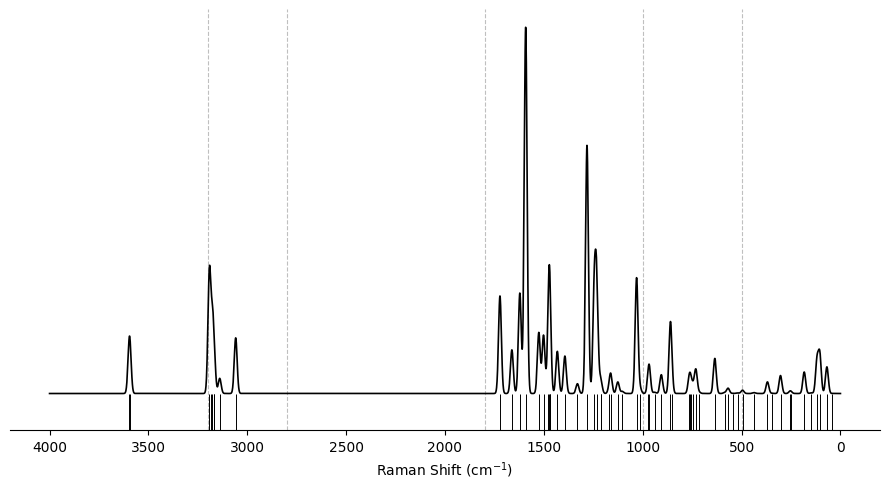

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Load Raman data ===
# Example dataframe structure: Mode, freq_cm-1, activity, depolarization
df_raman = pd.DataFrame(df["raman_spectrum"].iloc[0])

# === Physical constants ===
h = 6.62607015e-34      # Planck constant (J·s)
c = 2.99792458e10       # Speed of light (cm/s)
kB = 1.380649e-23       # Boltzmann constant (J/K)
T = 298.15              # Temperature (K)
laser_wavelength_nm = 532  # Laser wavelength (nm)
laser_wavenumber = 1e7 / laser_wavelength_nm  # cm⁻¹

# === Step 1. Convert Raman activity → Raman intensity ===
# I ∝ (ν0 - νi)^4 * S / [νi * (1 - exp(-h*c*νi / (kB*T)))]
df_raman["intensity_raw"] = (
    (laser_wavenumber - df_raman["freq_cm-1"])**4
    * df_raman["activity"]
    / (
        df_raman["freq_cm-1"]
        * (1 - np.exp(-h * c * df_raman["freq_cm-1"] / (kB * T)))
    )
)

# === Step 1.5. Apply threshold to avoid unphysical low-frequency spikes ===
# Threshold in cm⁻¹, adjustable between 0–100 (recommended 20–50)
intensity_threshold = 50

df_raman["intensity"] = np.where(
    df_raman["freq_cm-1"] < intensity_threshold, 
    0,  # suppress intensity near 0 cm⁻¹ (elastic scattering / baseline)
    df_raman["intensity_raw"]
)

# === Step 2. Apply frequency scaling factor (optional) ===
scale_factor = 1
df_raman["freq_scaled"] = df_raman["freq_cm-1"] * scale_factor

# === Step 3. Define Raman shift grid (interpolation domain) ===
shifts = np.linspace(0, 4000, 8000)  # cm⁻¹

# === Step 4. Gaussian broadening ===
fwhm = 17  # cm⁻¹
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Standard deviation

spectrum = np.zeros_like(shifts)
for _, row in df_raman.iterrows():
    nu0 = row["freq_scaled"]
    inten = row["intensity"]
    spectrum += inten * np.exp(-(shifts - nu0)**2 / (2 * sigma**2))

# === Step 5. Normalize spectrum ===
spectrum /= spectrum.max()

# === Step 6. Define regional boundaries (for interpretation) ===
region_boundaries = [500, 1000, 1800, 2800, 3200]

# === Step 7. Plot ===
fig, ax = plt.subplots(figsize=(9, 5))

# Regional boundary markers
for boundary in region_boundaries:
    ax.axvline(x=boundary, color="gray", linestyle="--", alpha=0.5, linewidth=0.8)

# Continuous spectrum
ax.plot(shifts, spectrum, color="black", lw=1.2)

# Restrict dataframe to plotted range
df_raman_filtered = df_raman[
    (df_raman["freq_scaled"] >= shifts.min()) &
    (df_raman["freq_scaled"] <= shifts.max())
]

# Add stick spectrum
stick_height = 0.1
for _, row in df_raman_filtered.iterrows():
    ax.vlines(row["freq_scaled"], -stick_height, 0, color="black", lw=0.7)

# Formatting
ax.set_xlabel("Raman Shift (cm$^{-1}$)")
ax.set_ylabel("Normalized Intensity (a.u.)")
ax.set_ylim(-stick_height, 1.05)
ax.invert_xaxis()

for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)
ax.yaxis.set_visible(False)

plt.tight_layout()
plt.show()


### 4. IR

⚠️ Continuous experimental IR skipped: name 'eks' is not defined
⚠️ Discrete experimental IR (AIST) skipped: name 'eks' is not defined


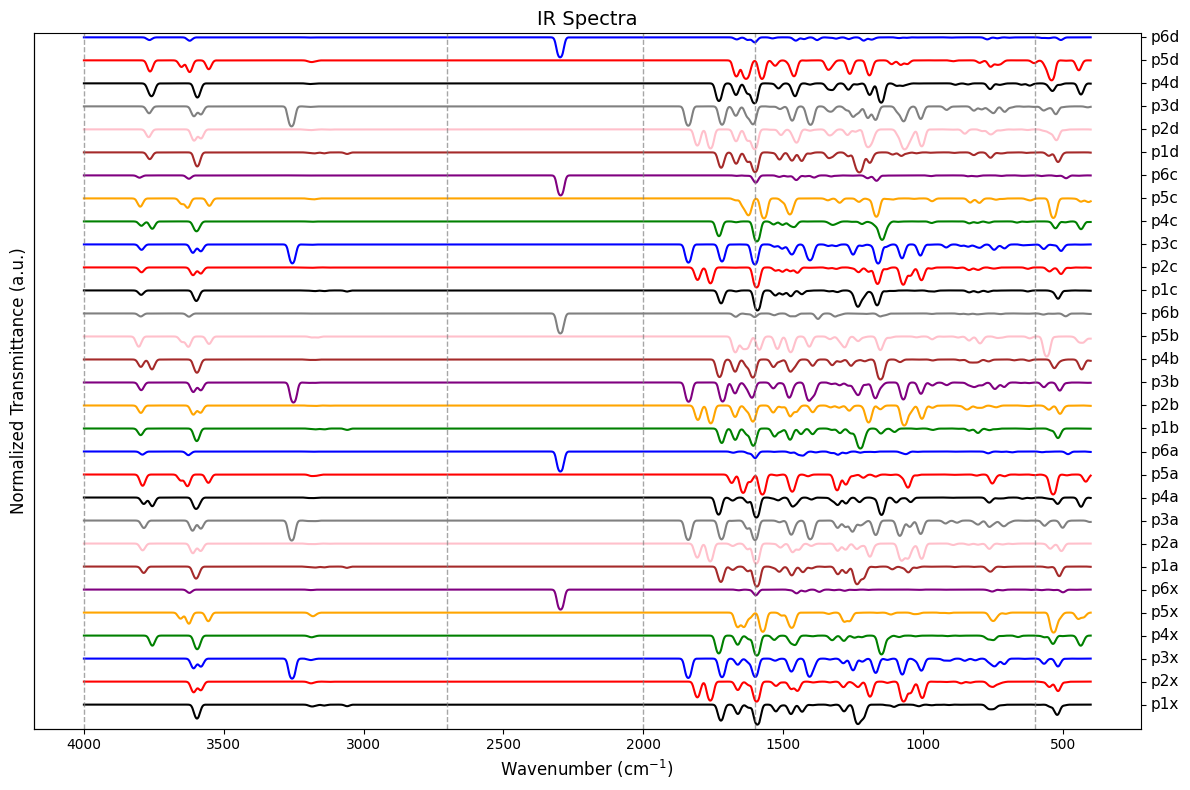

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Input parameters ===
datasets = [0, 1, 2, 3, 4, 5,
            6, 7, 8, 9, 10, 11,
            12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23,
            24, 25, 26, 27, 28, 29]
labels_input = ["p1x", "p2x", "p3x", "p4x", "p5x", "p6x",
                "p1a", "p2a", "p3a", "p4a", "p5a", "p6a",
                "p1b", "p2b", "p3b", "p4b", "p5b", "p6b",
                "p1c", "p2c", "p3c", "p4c", "p5c", "p6c",
                "p1d", "p2d", "p3d", "p4d", "p5d", "p6d"]
y_space = 15   # vertical spacing between stacked spectra

# Define wavenumber grid
x = np.linspace(400, 4000, 5000)  # cm⁻¹

# Scaling and shifting (optional corrections for DFT)
scale_x = 1
shift_x = 0

# Gaussian broadening
fwhm = 20.0
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Sample conditions for absorbance
c = 0.01  # mol/L
l = 1.0   # cm

# Colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# IR region boundaries
region_boundaries = [4000, 2700, 2000, 1600, 600] # [4000, 2250, 2000, 1500, 400]

# === Utility function to extract columns ===
def get_xy_from_df(df, xcol, ycol):
    return df[xcol].to_numpy(), df[ycol].to_numpy()

# === Process multiple DFT datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0
global_top = 0

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_idx])

    # Calculate absorbance
    df_ir["Absorbance"] = df_ir["eps"] * c * l

    # Build Gaussian-broadened IR spectrum
    absorbance_curve = np.zeros_like(x)
    for _, row in df_ir.iterrows():
        freq = row["freq_cm-1"] * scale_x + shift_x
        inten = row["Absorbance"]
        absorbance_curve += inten * np.exp(-0.5 * ((x - freq) / sigma) ** 2)

    # Normalize
    if absorbance_curve.max() > 0:
        absorbance_curve /= absorbance_curve.max()

    # Convert to transmittance (0–100 scale)
    transmittance_curve = 10**(-absorbance_curve) * 100
    t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
    if t_max > t_min:
        transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

    spectra.append(transmittance_curve)

    # Offset stacking
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = transmittance_curve.min()
        y_offset = prev_top - this_bottom + y_space

    current_top = y_offset + transmittance_curve.max()
    global_top = max(global_top, current_top)

    y_offsets.append(y_offset)

    # Plot spectrum
    color = colors[i % len(colors)]
    ax.plot(x, transmittance_curve + y_offset, color=color, lw=1.5)

# === Continuous Experimental IR (from Excel) ===
try:
    wn_exp, tr_exp = get_xy_from_df(eks["ir"], "ir_wn", "transmitance")
    ir_interp = np.interp(x, wn_exp, tr_exp)
    if ir_interp.max() > 0:
        ir_interp = ir_interp / ir_interp.max() * 100

    ref_offset = y_offsets[0]  # place under first DFT spectrum
    exp_offset = ref_offset - (ir_interp.max() + y_space)

    ax.plot(x, ir_interp + exp_offset,
            color="black", lw=1.5, linestyle="--")

    y_offsets.insert(0, exp_offset)
    labels_input.insert(0, "ph Exp (cont.)")
    spectra.insert(0, ir_interp)
except Exception as e:
    print("⚠️ Continuous experimental IR skipped:", e)

# === Discrete Experimental IR (AIST) ===
try:
    wn_aist, tr_aist = get_xy_from_df(eks["ir_aist"], "wavenumber", "transmitance")

    if tr_aist.max() > 0:
        tr_aist = tr_aist / tr_aist.max()

    # Broaden into smooth curve (absorbance-like first)
    aist_curve = np.zeros_like(x)
    for wn, inten in zip(wn_aist, tr_aist):
        aist_curve += inten * np.exp(-0.5 * ((x - wn) / sigma) ** 2)

    # Convert to transmittance: dips instead of peaks
    if aist_curve.max() > 0:
        aist_curve = aist_curve / aist_curve.max() * 100
        aist_curve = 100 - aist_curve

    # Offset positioning (below continuous exp IR if available, else below last DFT)
    base_offset = y_offsets[0] if y_offsets else 0
    exp_offset_aist = base_offset - (aist_curve.max() + y_space)

    ax.plot(x, aist_curve + exp_offset_aist,
            color="red", lw=1.5, linestyle="-.")

    y_offsets.insert(0, exp_offset_aist)
    labels_input.insert(0, "ph Exp (AIST)")
    spectra.insert(0, aist_curve)
except Exception as e:
    print("⚠️ Discrete experimental IR (AIST) skipped:", e)

# === Formatting ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

ax.set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Transmittance (a.u.)", fontsize=12)
ax.set_ylim(min(y_offsets) - 20, global_top + 20)
ax.spines["right"].set_visible(False)
ax.set_yticks([])

# Right axis with dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
label_positions = [offset + spec.max() for spec, offset in zip(spectra, y_offsets)]
ax2.set_yticks(label_positions)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (IR convention)
ax.invert_xaxis()

plt.title("IR Spectra", fontsize=14)
plt.tight_layout()
plt.show()


⚠️ Continuous experimental IR skipped: name 'eks' is not defined
⚠️ Discrete experimental IR (AIST) skipped: name 'eks' is not defined


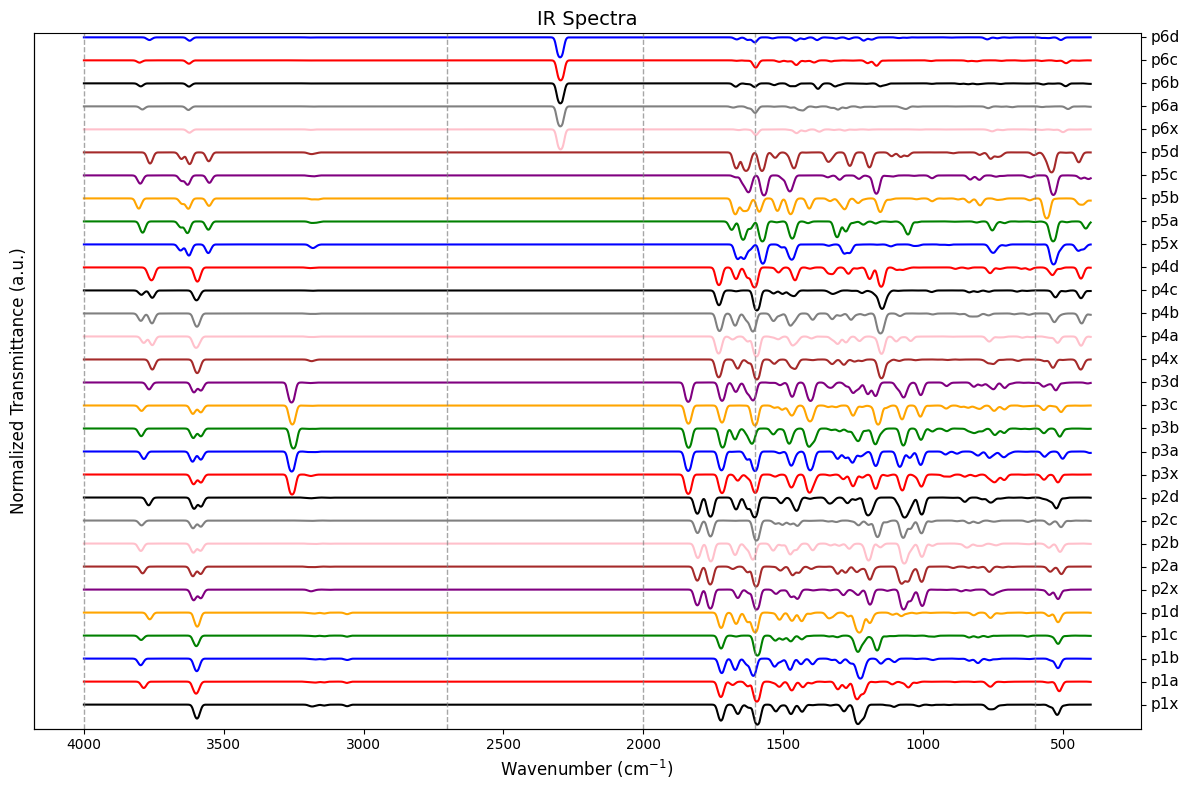

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Input parameters ===
datasets = [0, 6, 12, 18, 24,
            1, 7, 13, 19, 25,
            2, 8, 14, 20, 26,
            3, 9, 15, 21, 27,
            4, 10, 16, 22, 28,
            5, 11, 17, 23, 29]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d",
                "p2x", "p2a", "p2b", "p2c", "p2d",
                "p3x", "p3a", "p3b", "p3c", "p3d",
                "p4x", "p4a", "p4b", "p4c", "p4d",
                "p5x", "p5a", "p5b", "p5c", "p5d",
                "p6x", "p6a", "p6b", "p6c", "p6d"]
y_space = 15   # vertical spacing between stacked spectra

# Define wavenumber grid
x = np.linspace(400, 4000, 5000)  # cm⁻¹

# Scaling and shifting (optional corrections for DFT)
scale_x = 1
shift_x = 0

# Gaussian broadening
fwhm = 20.0
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Sample conditions for absorbance
c = 0.01  # mol/L
l = 1.0   # cm

# Colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# IR region boundaries
region_boundaries = [4000, 2700, 2000, 1600, 600] # [4000, 2250, 2000, 1500, 400]

# === Utility function to extract columns ===
def get_xy_from_df(df, xcol, ycol):
    return df[xcol].to_numpy(), df[ycol].to_numpy()

# === Process multiple DFT datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0
global_top = 0

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_idx])

    # Calculate absorbance
    df_ir["Absorbance"] = df_ir["eps"] * c * l

    # Build Gaussian-broadened IR spectrum
    absorbance_curve = np.zeros_like(x)
    for _, row in df_ir.iterrows():
        freq = row["freq_cm-1"] * scale_x + shift_x
        inten = row["Absorbance"]
        absorbance_curve += inten * np.exp(-0.5 * ((x - freq) / sigma) ** 2)

    # Normalize
    if absorbance_curve.max() > 0:
        absorbance_curve /= absorbance_curve.max()

    # Convert to transmittance (0–100 scale)
    transmittance_curve = 10**(-absorbance_curve) * 100
    t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
    if t_max > t_min:
        transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

    spectra.append(transmittance_curve)

    # Offset stacking
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = transmittance_curve.min()
        y_offset = prev_top - this_bottom + y_space

    current_top = y_offset + transmittance_curve.max()
    global_top = max(global_top, current_top)

    y_offsets.append(y_offset)

    # Plot spectrum
    color = colors[i % len(colors)]
    ax.plot(x, transmittance_curve + y_offset, color=color, lw=1.5)

# === Continuous Experimental IR (from Excel) ===
try:
    wn_exp, tr_exp = get_xy_from_df(eks["ir"], "ir_wn", "transmitance")
    ir_interp = np.interp(x, wn_exp, tr_exp)
    if ir_interp.max() > 0:
        ir_interp = ir_interp / ir_interp.max() * 100

    ref_offset = y_offsets[0]  # place under first DFT spectrum
    exp_offset = ref_offset - (ir_interp.max() + y_space)

    ax.plot(x, ir_interp + exp_offset,
            color="black", lw=1.5, linestyle="--")

    y_offsets.insert(0, exp_offset)
    labels_input.insert(0, "ph Exp (cont.)")
    spectra.insert(0, ir_interp)
except Exception as e:
    print("⚠️ Continuous experimental IR skipped:", e)

# === Discrete Experimental IR (AIST) ===
try:
    wn_aist, tr_aist = get_xy_from_df(eks["ir_aist"], "wavenumber", "transmitance")

    if tr_aist.max() > 0:
        tr_aist = tr_aist / tr_aist.max()

    # Broaden into smooth curve (absorbance-like first)
    aist_curve = np.zeros_like(x)
    for wn, inten in zip(wn_aist, tr_aist):
        aist_curve += inten * np.exp(-0.5 * ((x - wn) / sigma) ** 2)

    # Convert to transmittance: dips instead of peaks
    if aist_curve.max() > 0:
        aist_curve = aist_curve / aist_curve.max() * 100
        aist_curve = 100 - aist_curve

    # Offset positioning (below continuous exp IR if available, else below last DFT)
    base_offset = y_offsets[0] if y_offsets else 0
    exp_offset_aist = base_offset - (aist_curve.max() + y_space)

    ax.plot(x, aist_curve + exp_offset_aist,
            color="red", lw=1.5, linestyle="-.")

    y_offsets.insert(0, exp_offset_aist)
    labels_input.insert(0, "ph Exp (AIST)")
    spectra.insert(0, aist_curve)
except Exception as e:
    print("⚠️ Discrete experimental IR (AIST) skipped:", e)

# === Formatting ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

ax.set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Transmittance (a.u.)", fontsize=12)
ax.set_ylim(min(y_offsets) - 20, global_top + 20)
ax.spines["right"].set_visible(False)
ax.set_yticks([])

# Right axis with dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
label_positions = [offset + spec.max() for spec, offset in zip(spectra, y_offsets)]
ax2.set_yticks(label_positions)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (IR convention)
ax.invert_xaxis()

plt.title("IR Spectra", fontsize=14)
plt.tight_layout()
plt.show()


| Wavenumber (cm⁻¹) | Assignment / Functional Group                              |
| ----------------- | ---------------------------------------------------------- |
| ~ 3320 cm⁻¹       | N–H (secondary amine) stretch                              |
| ~ 1710 cm⁻¹       | C=O (carbamate) stretch                                    |
| ~ 1627 cm⁻¹       | C=O + C=N stretch of heterocycle                           |
| ~ 1591 cm⁻¹       | Aromatic C–C + C=N stretch                                 |
| ~ 1266 cm⁻¹       | C–O stretch (carbamate)                                    |
| ~ 1093 cm⁻¹       | C–O / C–N stretch                                          |
| ~ 726 cm⁻¹        | Out-of-plane ring vibration of heterocycle / aromatic ring |


![](./pic/Narcim.jpg)

![](./pic/bbrm_a_1911921_f0005a_c.jpg)

![](./pic/Hexar.jpg)

⚠️ Continuous experimental IR skipped: name 'eks' is not defined
⚠️ Discrete experimental IR (AIST) skipped: name 'eks' is not defined


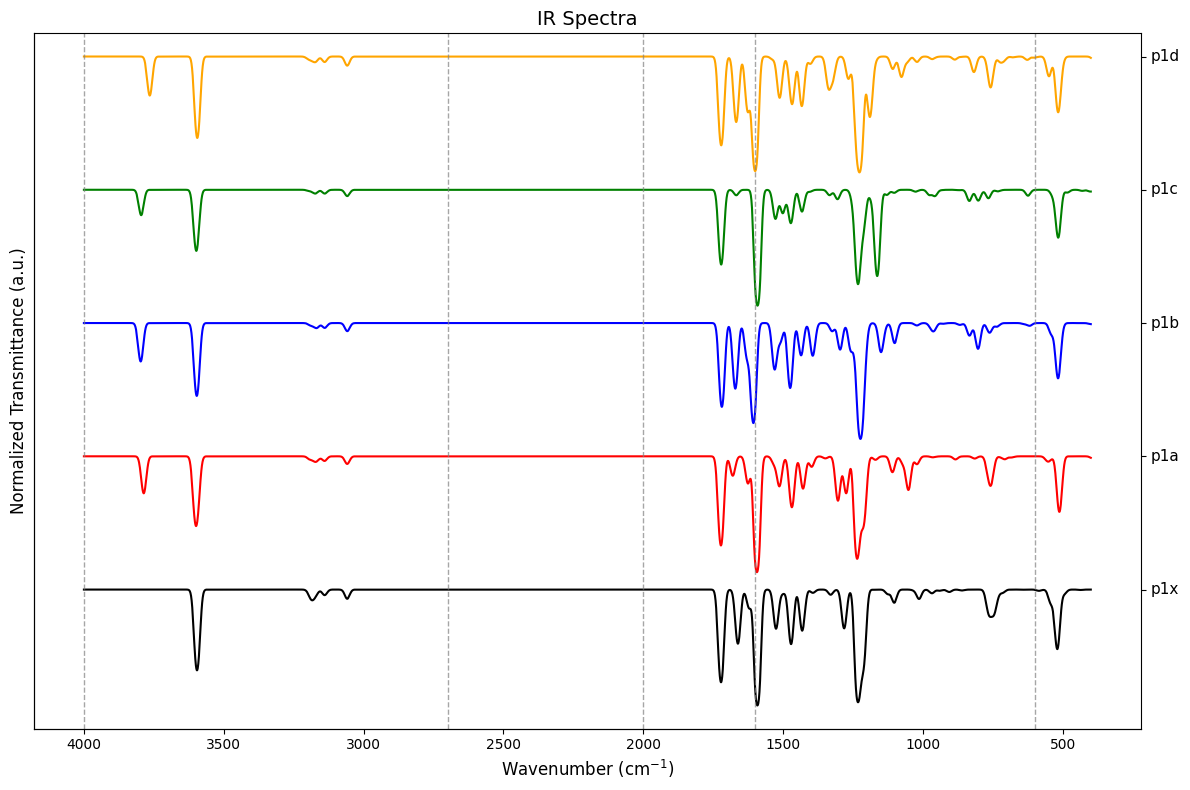

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Input parameters ===
datasets = [0, 6, 12, 18, 24]
labels_input = ["p1x", "p1a", "p1b", "p1c", "p1d"]
y_space = 15   # vertical spacing between stacked spectra

# Define wavenumber grid
x = np.linspace(400, 4000, 5000)  # cm⁻¹

# Scaling and shifting (optional corrections for DFT)
scale_x = 1
shift_x = 0

# Gaussian broadening
fwhm = 20.0
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Sample conditions for absorbance
c = 0.01  # mol/L
l = 1.0   # cm

# Colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# IR region boundaries
region_boundaries = [4000, 2700, 2000, 1600, 600] # [4000, 2250, 2000, 1500, 400]

# === Utility function to extract columns ===
def get_xy_from_df(df, xcol, ycol):
    return df[xcol].to_numpy(), df[ycol].to_numpy()

# === Process multiple DFT datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0
global_top = 0

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_idx])

    # Calculate absorbance
    df_ir["Absorbance"] = df_ir["eps"] * c * l

    # Build Gaussian-broadened IR spectrum
    absorbance_curve = np.zeros_like(x)
    for _, row in df_ir.iterrows():
        freq = row["freq_cm-1"] * scale_x + shift_x
        inten = row["Absorbance"]
        absorbance_curve += inten * np.exp(-0.5 * ((x - freq) / sigma) ** 2)

    # Normalize
    if absorbance_curve.max() > 0:
        absorbance_curve /= absorbance_curve.max()

    # Convert to transmittance (0–100 scale)
    transmittance_curve = 10**(-absorbance_curve) * 100
    t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
    if t_max > t_min:
        transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

    spectra.append(transmittance_curve)

    # Offset stacking
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = transmittance_curve.min()
        y_offset = prev_top - this_bottom + y_space

    current_top = y_offset + transmittance_curve.max()
    global_top = max(global_top, current_top)

    y_offsets.append(y_offset)

    # Plot spectrum
    color = colors[i % len(colors)]
    ax.plot(x, transmittance_curve + y_offset, color=color, lw=1.5)

# === Continuous Experimental IR (from Excel) ===
try:
    wn_exp, tr_exp = get_xy_from_df(eks["ir"], "ir_wn", "transmitance")
    ir_interp = np.interp(x, wn_exp, tr_exp)
    if ir_interp.max() > 0:
        ir_interp = ir_interp / ir_interp.max() * 100

    ref_offset = y_offsets[0]  # place under first DFT spectrum
    exp_offset = ref_offset - (ir_interp.max() + y_space)

    ax.plot(x, ir_interp + exp_offset,
            color="black", lw=1.5, linestyle="--")

    y_offsets.insert(0, exp_offset)
    labels_input.insert(0, "ph Exp (cont.)")
    spectra.insert(0, ir_interp)
except Exception as e:
    print("⚠️ Continuous experimental IR skipped:", e)

# === Discrete Experimental IR (AIST) ===
try:
    wn_aist, tr_aist = get_xy_from_df(eks["ir_aist"], "wavenumber", "transmitance")

    if tr_aist.max() > 0:
        tr_aist = tr_aist / tr_aist.max()

    # Broaden into smooth curve (absorbance-like first)
    aist_curve = np.zeros_like(x)
    for wn, inten in zip(wn_aist, tr_aist):
        aist_curve += inten * np.exp(-0.5 * ((x - wn) / sigma) ** 2)

    # Convert to transmittance: dips instead of peaks
    if aist_curve.max() > 0:
        aist_curve = aist_curve / aist_curve.max() * 100
        aist_curve = 100 - aist_curve

    # Offset positioning (below continuous exp IR if available, else below last DFT)
    base_offset = y_offsets[0] if y_offsets else 0
    exp_offset_aist = base_offset - (aist_curve.max() + y_space)

    ax.plot(x, aist_curve + exp_offset_aist,
            color="red", lw=1.5, linestyle="-.")

    y_offsets.insert(0, exp_offset_aist)
    labels_input.insert(0, "ph Exp (AIST)")
    spectra.insert(0, aist_curve)
except Exception as e:
    print("⚠️ Discrete experimental IR (AIST) skipped:", e)

# === Formatting ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

ax.set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Transmittance (a.u.)", fontsize=12)
ax.set_ylim(min(y_offsets) - 20, global_top + 20)
ax.spines["right"].set_visible(False)
ax.set_yticks([])

# Right axis with dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
label_positions = [offset + spec.max() for spec, offset in zip(spectra, y_offsets)]
ax2.set_yticks(label_positions)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (IR convention)
ax.invert_xaxis()

plt.title("IR Spectra", fontsize=14)
plt.tight_layout()
plt.show()


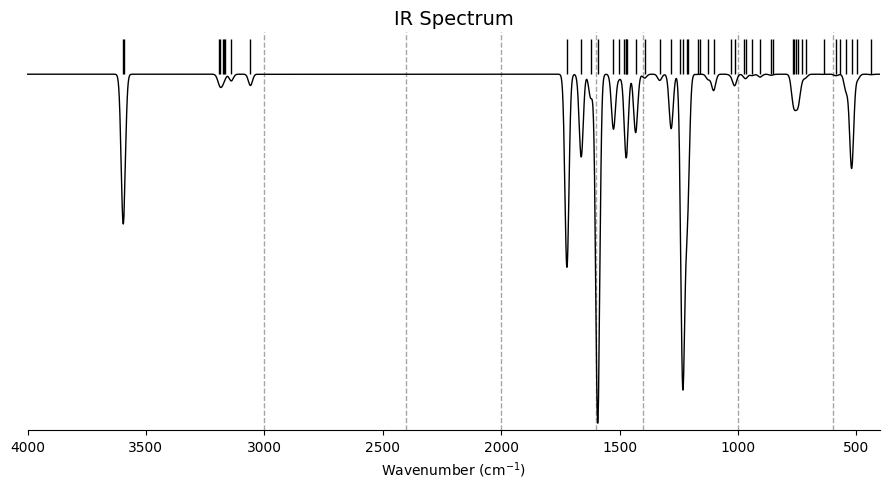

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================
# IR SPECTRUM: Discrete + Continuous Combined
# ============================================

# === Example IR dataframe (from single molecule) ===
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[0])
# === Define wavenumber grid ===
wavenumbers = np.linspace(400, 4000, 8000)  # cm⁻¹

# === Gaussian broadening parameters ===
fwhm = 20.0  # Full Width at Half Maximum (cm⁻¹)
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# === Sample conditions (Beer-Lambert Law) ===
c = 0.01  # concentration (mol/L)
l = 1.0   # path length (cm)

# === Calculate Absorbance ===
# A = ε × c × l
df_ir["Absorbance"] = df_ir["eps"] * c * l

# === Build continuous IR spectrum (absorbance) ===
absorbance_curve = np.zeros_like(wavenumbers)
for _, row in df_ir.iterrows():
    nu0 = row["freq_cm-1"]
    inten = row["Absorbance"]
    absorbance_curve += inten * np.exp(-0.5 * ((wavenumbers - nu0) / sigma) ** 2)

# === Convert to Transmittance ===
# T = 10^(-A) × 100
# Baseline = 100% (no absorption), dips toward 0% (strong absorption)
transmittance_curve = 10**(-absorbance_curve) * 100

# Normalize transmittance to 0-100 range
t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
if t_max > t_min:
    transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

# === IR region boundaries ===
region_boundaries = [3000, 2400, 2000, 1600, 1400, 1000, 600] # [2700, 2000, 1600, 1000, 600]

# === Plot IR spectrum ===
fig, ax = plt.subplots(figsize=(9, 5))

# Add regional boundaries (background)
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

# Plot continuous transmittance spectrum (dips show absorption)
ax.plot(wavenumbers, transmittance_curve, color="black", lw=1, label="IR Spectrum")

# === Add discrete stick spectrum ABOVE baseline (100%) ===
# Filter dataframe to wavenumber range
df_ir_filtered = df_ir[(df_ir["freq_cm-1"] >= wavenumbers.min()) &
                        (df_ir["freq_cm-1"] <= wavenumbers.max())]

# Calculate spectrum range for proportional stick height
spectrum_range = transmittance_curve.max() - transmittance_curve.min()
stick_height = spectrum_range * 0.1  # 10% of spectrum height (same as Raman)

# Stick spectrum (showing discrete frequencies above 100% baseline)
for _, row in df_ir_filtered.iterrows():
    freq = row["freq_cm-1"]
    # Draw stick upward from 100% baseline with fixed height
    ax.vlines(freq, 100, 100 + stick_height, color="black", linewidth=1)

# === Formatting ===
ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("Intensity (a.u.)")

# Extend y-axis to show sticks above baseline
ax.set_ylim(transmittance_curve.min() - stick_height * 0.2, 100 + stick_height * 1.2)
ax.set_xlim(400, 4000)

# Hide all spines except bottom
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)

# Hide y ticks and labels
ax.yaxis.set_visible(False)

# Invert x-axis (IR convention: high to low wavenumber)
ax.invert_xaxis()

# === Automatic region labels (middle between boundaries) ===
# Define region names
region_names = [] # 'O-H/N-H', 'C-H', 'C=O', 'Fingerprint', 'Low freq']

# Add upper boundary for first region and lower boundary for last region
extended_boundaries = [4000] + region_boundaries + [400]

# Calculate middle positions automatically
for i in range(len(extended_boundaries) - 1):
    left_boundary = extended_boundaries[i]
    right_boundary = extended_boundaries[i + 1]
    middle_position = (left_boundary + right_boundary) / 2
    
    # Only add label if we have a name for this region
    if i < len(region_names):
        ax.text(middle_position, 112, region_names[i], 
                rotation=0, ha='center', va='bottom', 
                fontsize=9, color='gray', alpha=0.7)

plt.title("IR Spectrum", fontsize=14)
plt.tight_layout()
plt.show()

### 5. Raman + IR

Maximum overlap: 1.965
Required distance between baselines: 2.165
Raman y-axis: [-0.100, 2.265]
IR y-axis: [-1.265, 1.100]


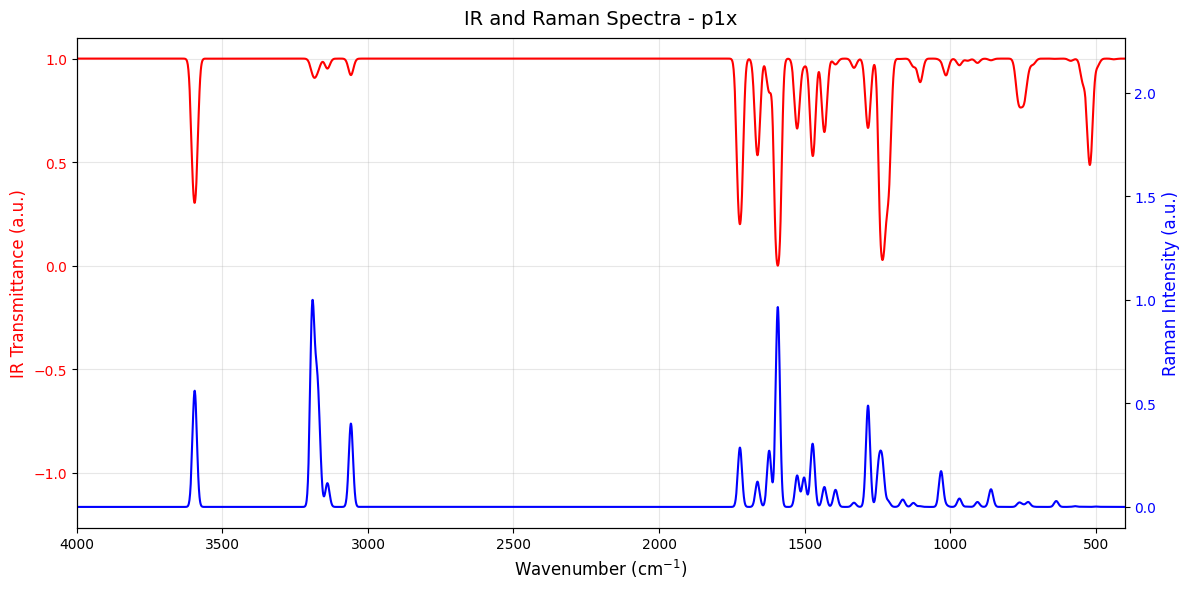

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Input parameters ===
datasets = [0]
labels_input = ["p1x"]

# === IR Parameters ===
x = np.linspace(400, 4000, 5000)  # cm⁻¹
fwhm_ir = 20.0
sigma_ir = fwhm_ir / (2 * np.sqrt(2 * np.log(2)))
c = 0.01  # mol/L
l = 1.0   # cm

# === Raman Parameters ===
fwhm_raman = 17.0
sigma_raman = fwhm_raman / (2 * np.sqrt(2 * np.log(2)))

# === Create single figure ===
fig, ax = plt.subplots(figsize=(12, 6))

# ========== IR SPECTRUM ==========
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[datasets[0]])
df_ir["Absorbance"] = df_ir["eps"] * c * l

# Build Gaussian-broadened IR spectrum
absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    freq = row["freq_cm-1"]
    inten = row["Absorbance"]
    absorbance_curve += inten * np.exp(-0.5 * ((x - freq) / sigma_ir) ** 2)

# Normalize
if absorbance_curve.max() > 0:
    absorbance_curve /= absorbance_curve.max()

# Convert to transmittance (0–1 scale)
transmittance_curve = 10**(-absorbance_curve)
t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
if t_max > t_min:
    transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min)

# ========== RAMAN SPECTRUM ==========
df_raman = pd.DataFrame(df["raman_spectrum"].iloc[datasets[0]])

# Build continuous Raman spectrum
raman_spectrum = np.zeros_like(x)
for _, row in df_raman.iterrows():
    nu0 = row["freq_cm-1"]
    inten = row["activity"]
    raman_spectrum += inten * np.exp(-0.5 * ((x - nu0) / sigma_raman) ** 2)

# Normalize
if raman_spectrum.max() > 0:
    raman_spectrum = raman_spectrum / raman_spectrum.max()

# ========== CALCULATE DISTANCE BETWEEN BASELINES ==========
# Add both spectra to find maximum overlap
# IR goes DOWN from 1.0, so low values = peaks
# Raman goes UP from 0.0, so high values = peaks
# Sum shows where they would overlap most
combined = (1.0 - transmittance_curve) + raman_spectrum  # Convert IR to "peak height" then add

# Maximum combined value shows the biggest overlap
max_combined = combined.max()

# Distance needed = max overlap + gap
gap = 0.2
distance = max_combined + gap

print(f"Maximum overlap: {max_combined:.3f}")
print(f"Required distance between baselines: {distance:.3f}")

# ========== CALCULATE Y-AXIS RANGES ==========
padding = 0.1
# Raman axis
raman_y_min = 0.0 - padding
raman_y_max = distance + padding

# IR axis  
ir_y_max = 1.0 + padding
ir_y_min = 1.0 - distance - padding

print(f"Raman y-axis: [{raman_y_min:.3f}, {raman_y_max:.3f}]")
print(f"IR y-axis: [{ir_y_min:.3f}, {ir_y_max:.3f}]")

# ========== PLOTTING ==========
# Plot IR on primary y-axis
ax.plot(x, transmittance_curve, color='red', lw=1.5, label='IR')
ax.set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("IR Transmittance (a.u.)", fontsize=12, color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylim(ir_y_min, ir_y_max)

# Plot Raman on secondary y-axis
ax2 = ax.twinx()
ax2.plot(x, raman_spectrum, color='blue', lw=1.5, label='Raman')
ax2.set_ylabel("Raman Intensity (a.u.)", fontsize=12, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(raman_y_min, raman_y_max)

# Invert x-axis
ax.invert_xaxis()
ax.set_xlim(4000, 400)

# Title and grid
ax.set_title(f"IR and Raman Spectra - {labels_input[0]}", fontsize=14, pad=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

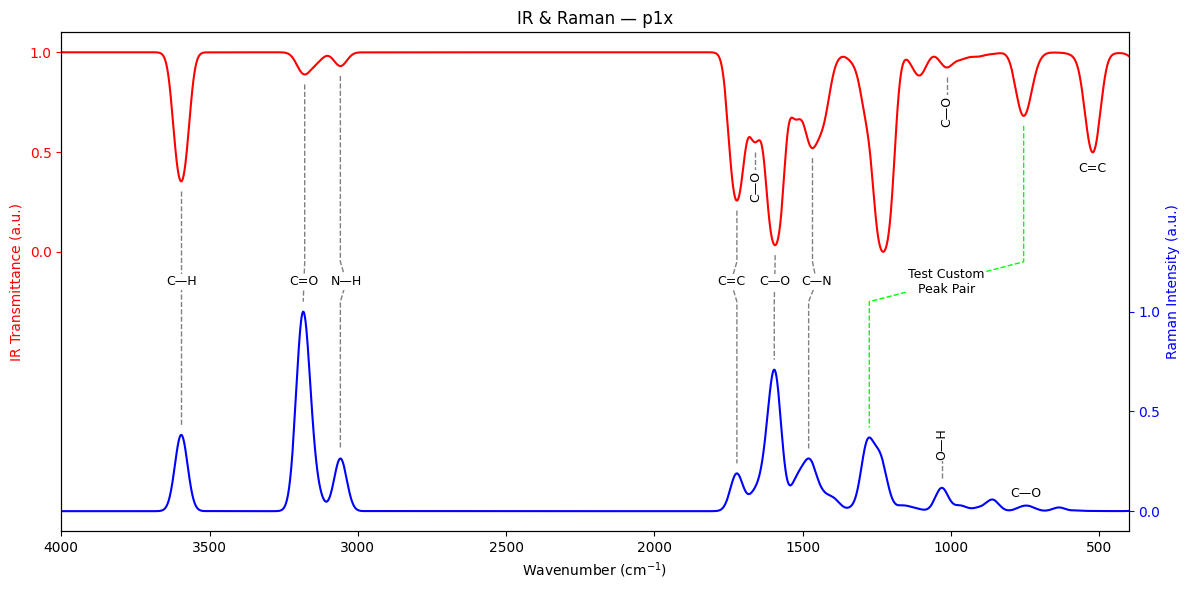

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# =====================================================
# USER SETTINGS
# =====================================================
dataset_index = 0
tittle_text = "p1x"

x_min, x_max = 400, 4000
x = np.linspace(x_min, x_max, 5000)

# Gaussian broadening
fwhm_ir = 50
fwhm_raman = 50
sigma_ir = fwhm_ir / (2*np.sqrt(2*np.log(2)))
sigma_raman = fwhm_raman / (2*np.sqrt(2*np.log(2)))

# Peak detection
peak_height = 0.0
peak_prom = 0.0
min_distance_cm = 0.0
cluster_tol_cm = 8.0
max_pair_delta = 40.0

# Layout geometry
padding = 0.1
gap = 0.3
vertical_snap_frac = 0.02
connector_style = "--"
connector_color = "gray"

diag_height = 0.20
vert_height = (gap - diag_height) / 2.0

# =====================================================
# BUILD IR & RAMAN SPECTRA
# =====================================================
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_index])
df_ir["Absorbance"] = df_ir["eps"] * 0.01

absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    absorbance_curve += row["Absorbance"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_ir)**2)

if absorbance_curve.max() > 0:
    absorbance_curve /= absorbance_curve.max()

transmittance_curve = 10**(-absorbance_curve)
transmittance_curve = (transmittance_curve - transmittance_curve.min()) / (transmittance_curve.max() - transmittance_curve.min())

df_ra = pd.DataFrame(df["raman_spectrum"].iloc[dataset_index])
raman_spectrum = np.zeros_like(x)
for _, row in df_ra.iterrows():
    raman_spectrum += row["activity"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_raman)**2)

if raman_spectrum.max() > 0:
    raman_spectrum /= raman_spectrum.max()

# =====================================================
# PEAK DETECTION & CLUSTERING
# =====================================================
dx = x[1] - x[0]
min_dist_samples = max(1, int(min_distance_cm/dx))

ir_heights = 1 - transmittance_curve
pIR_raw, _ = find_peaks(ir_heights, distance=min_dist_samples)
pRA_raw, _ = find_peaks(raman_spectrum, distance=min_dist_samples)

def cluster_peaks(peaks, y_values, tol):
    if len(peaks) == 0:
        return []
    peaks_sorted = sorted(peaks, key=lambda p: x[p])
    clusters = []
    curr = [peaks_sorted[0]]
    for p in peaks_sorted[1:]:
        if abs(x[p] - x[curr[-1]]) < tol:
            curr.append(p)
        else:
            clusters.append(curr)
            curr = [p]
    clusters.append(curr)

    merged = []
    for c in clusters:
        freqs = np.array([x[p] for p in c])
        ints = np.array([y_values[p] for p in c])
        centroid = (freqs * ints).sum()/ints.sum() if ints.sum()>0 else freqs.mean()
        chosen = c[np.argmin(abs(freqs - centroid))]
        merged.append(chosen)
    return merged

pIR = cluster_peaks(pIR_raw, ir_heights, cluster_tol_cm)
pRA = cluster_peaks(pRA_raw, raman_spectrum, cluster_tol_cm)

ir_info = [(i,p,x[p],transmittance_curve[p],1-transmittance_curve[p]) for i,p in enumerate(pIR)]
ra_info = [(i,p,x[p],raman_spectrum[p],raman_spectrum[p]) for i,p in enumerate(pRA)]

ir_map = {row[0]: row for row in ir_info}
ra_map = {row[0]: row for row in ra_info}

# =====================================================
# MANUAL LABELS
# =====================================================
manual_labels = [
    [0, "C—H"],
    [1, "C=O"],
    [2, "N—H", "dx:-20"],
    [3, "C=C", "dx: 20"],
    [4, "C—O"],
    [5, "C—N", "dx:-20"],
    [[1, 6], "Test Custom\nPeak Pair", "#00ff00"],
    [6, 0],
    [7, 0],
    [8, "What Is\nThis?"],
    ["ir", 
        [0, "C=C", 0],
        [2, "C—O", 0.2, "rot:90"],
        [8, "C—O", 0.2, "rot:90"],
    ],
    ["raman",
        [4, "O—H", 0.2, "rot:90"],
        [2, "C—O", 0],
    ],
    ["else", 0]
]

def parse_label_params(item):
    if isinstance(item[0], list):
        ir_idx, ra_idx = item[0]
        label = item[1] if len(item) >= 2 else None
        start_idx = 2
    else:
        pair_idx = item[0]
        label = item[1]
        start_idx = 2
        ir_idx, ra_idx = None, None
    
    color = connector_color
    dx_offset = 0.0
    rotation = 0
    alignment = "center"
    
    for i in range(start_idx, len(item)):
        param = item[i]
        if isinstance(param, str):
            if param.startswith("dx:"):
                dx_offset = float(param[3:])
            elif param.startswith("rot:"):
                rotation = float(param[4:])
            elif param in ["center", "left", "right"]:
                alignment = param
            elif param.startswith("#") or param in ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "yellow", "black", "gray", "grey"]:
                color = param
            elif i == start_idx:
                color = param
    
    if ir_idx is not None:
        return ("forced", ir_idx, ra_idx, label, color, dx_offset, rotation, alignment)
    else:
        return ("override", pair_idx, label, color, dx_offset, rotation, alignment)

pair_label_overrides = {}
forced_pairs = []
ir_peak_labels = {}
raman_peak_labels = {}
hide_unlisted = False

for item in manual_labels:
    if item == ["else", 0]:
        hide_unlisted = True
        continue
    
    if isinstance(item, list) and len(item) >= 2:
        if item[0] == "ir":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    ir_peak_labels[peak_idx] = (label, offset, rotation)
            continue
        elif item[0] == "raman":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    raman_peak_labels[peak_idx] = (label, offset, rotation)
            continue
        
        result = parse_label_params(item)
        
        if result[0] == "forced":
            _, ir_idx, ra_idx, label, color, dx_offset, rotation, alignment = result
            forced_pairs.append([ir_idx, ra_idx, label, color, dx_offset, rotation, alignment])
        elif result[0] == "override":
            _, pair_idx, label, color, dx_offset, rotation, alignment = result
            pair_label_overrides[pair_idx] = (label, color, dx_offset, rotation, alignment)

# =====================================================
# PAIRING
# =====================================================
assigned_ir = set()
assigned_ra = set()

for ir_idx, ra_idx, label, color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx < len(ir_info) and ra_idx < len(ra_info):
        assigned_ir.add(ir_idx)
        assigned_ra.add(ra_idx)

candidates = []
for ir in ir_info:
    for ra in ra_info:
        ir_idx, ir_p, ir_f, _, ir_int = ir
        ra_idx, ra_p, ra_f, _, ra_int = ra
        if ir_idx in assigned_ir or ra_idx in assigned_ra:
            continue
        delta = abs(ir_f - ra_f)
        score = (delta, -ir_int*ra_int)
        candidates.append((delta, score, ir_idx, ra_idx, ir_p, ra_p, ir_f, ra_f))

candidates.sort(key=lambda t:(t[0],t[1]))

pairs = []
for delta,_,ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f in candidates:
    if delta > max_pair_delta: continue
    if ir_idx in assigned_ir or ra_idx in assigned_ra: continue
    assigned_ir.add(ir_idx)
    assigned_ra.add(ra_idx)
    pairs.append([ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f,delta])

pairs.sort(key=lambda p:p[4], reverse=True)
for i,p in enumerate(pairs): 
    p.append(i)

# =====================================================
# FIXED GEOMETRY
# =====================================================
ir_baseline = 1.0
raman_baseline = -gap - 1.0

y_top = ir_baseline + padding
y_bottom = raman_baseline - padding

raman_shifted = raman_spectrum + raman_baseline

diag_top_y    = -vert_height
diag_bottom_y = -(vert_height+diag_height)

snap = vertical_snap_frac * (y_top - y_bottom)

# =====================================================
# PLOT
# =====================================================
fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()

ax.set_ylim(y_bottom, y_top)
ax2.set_ylim(y_bottom, y_top)

ax.plot(x, transmittance_curve, color="red", lw=1.5)
ax2.plot(x, raman_shifted, color="blue", lw=1.5)

ax.set_yticks([0,0.5,1])
ax.set_yticklabels(["0.0","0.5","1.0"])

ax2.set_yticks([raman_baseline, raman_baseline+0.5, raman_baseline+1.0])
ax2.set_yticklabels(["0.0","0.5","1.0"])

ax.set_ylabel("IR Transmittance (a.u.)", color="red")
ax2.set_ylabel("Raman Intensity (a.u.)", color="blue")
ax.tick_params(axis='y', colors='red')
ax2.tick_params(axis='y', colors='blue')

# =====================================================
# DRAW CONNECTORS
# =====================================================
hide_ir = set()
hide_ra = set()

for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, delta, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides:
        label_val = pair_label_overrides[pidx][0]
        if label_val == 0:
            should_hide = True
    elif hide_unlisted:
        should_hide = True
    
    if should_hide:
        continue
    
    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    if pidx in pair_label_overrides:
        label_text, line_color, dx_offset, rotation, alignment = pair_label_overrides[pidx]
    else:
        label_text = str(pidx)
        line_color = connector_color
        dx_offset = 0.0
        rotation = 0
        alignment = "center"

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    ax.plot([ir_px, ir_px, mid_x, r_px, r_px], 
            [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y], 
            ls=connector_style, color=line_color, lw=1.0)

    ax.text(mid_x, mid_y, label_text,
            ha='center', va='center', fontsize=9, color='black',
            rotation=rotation, rotation_mode='anchor', multialignment=alignment,
            bbox=dict(facecolor="white", edgecolor="none", pad=1.0))

# =====================================================
# DRAW FORCED PAIRS
# =====================================================
for ir_idx, ra_idx, label, line_color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info):
        continue
    
    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)
    
    ir_pidx = ir_map[ir_idx][1]
    ra_pidx = ra_map[ra_idx][1]
    
    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]
    
    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2
    
    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap
    
    ax.plot([ir_px, ir_px, mid_x, r_px, r_px], 
            [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y], 
            ls=connector_style, color=line_color, lw=1.0)
    
    if label is not None:
        ax.text(mid_x, mid_y, label,
                ha='center', va='center', fontsize=9, color='black',
                rotation=rotation, rotation_mode='anchor', multialignment=alignment,
                bbox=dict(facecolor="white", edgecolor="none", pad=1.0))

# =====================================================
# LABEL UNPAIRED PEAKS - COLOR FIX APPLIED HERE
# =====================================================
for i,p,fx,py,inten in ir_info:
    if i in ir_peak_labels:
        label, offset, rotation = ir_peak_labels[i]
        
        if offset > 0:
            # With line: always black
            line_end_y = py - offset
            ax.plot([fx, fx], [py - snap, line_end_y], 
                   ls=connector_style, color=connector_color, lw=1.0)
            va_align = 'center' if abs(rotation - 90) < 5 else 'top'
            ax.text(fx, line_end_y - 0.02, label,
                   ha='center', va=va_align, fontsize=9, color='black',
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(facecolor="white", edgecolor="none", pad=0.6))
        else:
            # Without line: always black (FIXED)
            va_align = 'center' if abs(rotation - 90) < 5 else 'top'
            ax.text(fx, py - 0.05, label,
                   ha='center', va=va_align, color='black', fontsize=9,
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(facecolor="white", edgecolor="none", pad=0.6))
    elif i not in hide_ir and not hide_unlisted:
        ax.text(fx, py - 0.05, str(i),
               ha='center', va='top', color='darkred', fontsize=9,
               bbox=dict(facecolor="white", edgecolor="none", pad=0.6))

for i,p,fx,py,inten in ra_info:
    if i in raman_peak_labels:
        label, offset, rotation = raman_peak_labels[i]
        shifted_py = raman_shifted[p]
        
        if offset > 0:
            # With line: always black
            line_start_y = shifted_py + snap
            line_end_y = shifted_py + offset
            ax.plot([fx, fx], [line_start_y, line_end_y], 
                   ls=connector_style, color=connector_color, lw=1.0)
            va_align = 'center' if abs(rotation - 90) < 5 else 'bottom'
            ax.text(fx, line_end_y + 0.02, label,
                   ha='center', va=va_align, fontsize=9, color='black',
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(facecolor="white", edgecolor="none", pad=0.6))
        else:
            # Without line: always black (FIXED)
            va_align = 'center' if abs(rotation - 90) < 5 else 'bottom'
            ax.text(fx, shifted_py + 0.03, label,
                   ha='center', va=va_align, color='black', fontsize=9,
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(facecolor="white", edgecolor="none", pad=0.6))
    elif i not in hide_ra and not hide_unlisted:
        shifted_py = raman_shifted[p]
        ax.text(fx, shifted_py + 0.03, str(i),
               ha='center', va='bottom', color='darkblue', fontsize=9,
               bbox=dict(facecolor="white", edgecolor="none", pad=0.6))

ax.invert_xaxis()
ax.set_xlim(x_max, x_min)
ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_title(f"IR & Raman — {tittle_text}")

plt.tight_layout()
plt.show()

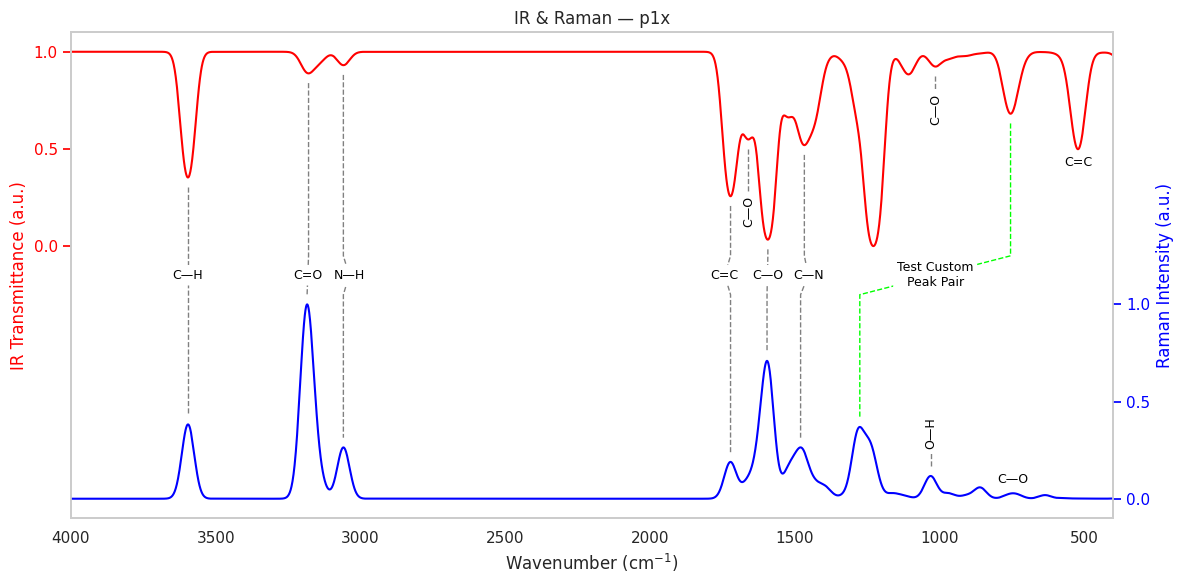

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# =====================================================
# USER SETTINGS
# =====================================================
dataset_index = 0
tittle_text = "p1x"

x_min, x_max = 400, 4000
x = np.linspace(x_min, x_max, 5000)

# Gaussian broadening
fwhm_ir = 50
fwhm_raman = 50
sigma_ir = fwhm_ir / (2*np.sqrt(2*np.log(2)))
sigma_raman = fwhm_raman / (2*np.sqrt(2*np.log(2)))

# Peak detection
peak_height = 0.0
peak_prom = 0.0
min_distance_cm = 0.0
cluster_tol_cm = 8.0
max_pair_delta = 40.0

# Layout geometry
padding = 0.1
gap = 0.3
vertical_snap_frac = 0.02
connector_style = "--"
connector_color = "gray"

diag_height = 0.20
vert_height = (gap - diag_height) / 2.0

# Text box styling
peak_label_offset = 0.05  # Distance from peak point to text box
line_label_y_offset = 0.02  # Distance from line end to text box

# =====================================================
# BUILD IR & RAMAN SPECTRA
# =====================================================
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_index])
df_ir["Absorbance"] = df_ir["eps"] * 0.01

absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    absorbance_curve += row["Absorbance"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_ir)**2)

if absorbance_curve.max() > 0:
    absorbance_curve /= absorbance_curve.max()

transmittance_curve = 10**(-absorbance_curve)
transmittance_curve = (transmittance_curve - transmittance_curve.min()) / (transmittance_curve.max() - transmittance_curve.min())

df_ra = pd.DataFrame(df["raman_spectrum"].iloc[dataset_index])
raman_spectrum = np.zeros_like(x)
for _, row in df_ra.iterrows():
    raman_spectrum += row["activity"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_raman)**2)

if raman_spectrum.max() > 0:
    raman_spectrum /= raman_spectrum.max()

# =====================================================
# PEAK DETECTION & CLUSTERING
# =====================================================
dx = x[1] - x[0]
min_dist_samples = max(1, int(min_distance_cm/dx))

ir_heights = 1 - transmittance_curve
pIR_raw, _ = find_peaks(ir_heights, distance=min_dist_samples)
pRA_raw, _ = find_peaks(raman_spectrum, distance=min_dist_samples)

def cluster_peaks(peaks, y_values, tol):
    if len(peaks) == 0:
        return []
    peaks_sorted = sorted(peaks, key=lambda p: x[p])
    clusters = []
    curr = [peaks_sorted[0]]
    for p in peaks_sorted[1:]:
        if abs(x[p] - x[curr[-1]]) < tol:
            curr.append(p)
        else:
            clusters.append(curr)
            curr = [p]
    clusters.append(curr)

    merged = []
    for c in clusters:
        freqs = np.array([x[p] for p in c])
        ints = np.array([y_values[p] for p in c])
        centroid = (freqs * ints).sum()/ints.sum() if ints.sum()>0 else freqs.mean()
        chosen = c[np.argmin(abs(freqs - centroid))]
        merged.append(chosen)
    return merged

pIR = cluster_peaks(pIR_raw, ir_heights, cluster_tol_cm)
pRA = cluster_peaks(pRA_raw, raman_spectrum, cluster_tol_cm)

ir_info = [(i,p,x[p],transmittance_curve[p],1-transmittance_curve[p]) for i,p in enumerate(pIR)]
ra_info = [(i,p,x[p],raman_spectrum[p],raman_spectrum[p]) for i,p in enumerate(pRA)]

ir_map = {row[0]: row for row in ir_info}
ra_map = {row[0]: row for row in ra_info}

# =====================================================
# MANUAL LABELS
# =====================================================
manual_labels = [
    [0, "C—H"],
    [1, "C=O"],
    [2, "N—H", "dx:-20"],
    [3, "C=C", "dx: 20"],
    [4, "C—O"],
    [5, "C—N", "dx:-20"],
    [[1, 6], "Test Custom\nPeak Pair", "#00ff00"],
    [6, 0],
    [7, 0],
    [8, "What Is\nThis?"],
    ["ir", 
        [0, "C=C", 0.05],
        [2, "C—O", 0.2, "rot:90"],
        [8, "C—O", 0.35, "rot:90"],
    ],
    ["raman",
        [4, "O—H", 0.2, "rot:90"],
        [2, "C—O", 0.05],
    ],
    ["else", 0]
]

def parse_label_params(item):
    if isinstance(item[0], list):
        ir_idx, ra_idx = item[0]
        label = item[1] if len(item) >= 2 else None
        start_idx = 2
    else:
        pair_idx = item[0]
        label = item[1]
        start_idx = 2
        ir_idx, ra_idx = None, None
    
    color = connector_color
    dx_offset = 0.0
    rotation = 0
    alignment = "center"
    
    for i in range(start_idx, len(item)):
        param = item[i]
        if isinstance(param, str):
            if param.startswith("dx:"):
                dx_offset = float(param[3:])
            elif param.startswith("rot:"):
                rotation = float(param[4:])
            elif param in ["center", "left", "right"]:
                alignment = param
            elif param.startswith("#") or param in ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "yellow", "black", "gray", "grey"]:
                color = param
            elif i == start_idx:
                color = param
    
    if ir_idx is not None:
        return ("forced", ir_idx, ra_idx, label, color, dx_offset, rotation, alignment)
    else:
        return ("override", pair_idx, label, color, dx_offset, rotation, alignment)

pair_label_overrides = {}
forced_pairs = []
ir_peak_labels = {}
raman_peak_labels = {}
hide_unlisted = False

for item in manual_labels:
    if item == ["else", 0]:
        hide_unlisted = True
        continue
    
    if isinstance(item, list) and len(item) >= 2:
        if item[0] == "ir":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    ir_peak_labels[peak_idx] = (label, offset, rotation)
            continue
        elif item[0] == "raman":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    raman_peak_labels[peak_idx] = (label, offset, rotation)
            continue
        
        result = parse_label_params(item)
        
        if result[0] == "forced":
            _, ir_idx, ra_idx, label, color, dx_offset, rotation, alignment = result
            forced_pairs.append([ir_idx, ra_idx, label, color, dx_offset, rotation, alignment])
        elif result[0] == "override":
            _, pair_idx, label, color, dx_offset, rotation, alignment = result
            pair_label_overrides[pair_idx] = (label, color, dx_offset, rotation, alignment)

# =====================================================
# PAIRING
# =====================================================
assigned_ir = set()
assigned_ra = set()

for ir_idx, ra_idx, label, color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx < len(ir_info) and ra_idx < len(ra_info):
        assigned_ir.add(ir_idx)
        assigned_ra.add(ra_idx)

candidates = []
for ir in ir_info:
    for ra in ra_info:
        ir_idx, ir_p, ir_f, _, ir_int = ir
        ra_idx, ra_p, ra_f, _, ra_int = ra
        if ir_idx in assigned_ir or ra_idx in assigned_ra:
            continue
        delta = abs(ir_f - ra_f)
        score = (delta, -ir_int*ra_int)
        candidates.append((delta, score, ir_idx, ra_idx, ir_p, ra_p, ir_f, ra_f))

candidates.sort(key=lambda t:(t[0],t[1]))

pairs = []
for delta,_,ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f in candidates:
    if delta > max_pair_delta: continue
    if ir_idx in assigned_ir or ra_idx in assigned_ra: continue
    assigned_ir.add(ir_idx)
    assigned_ra.add(ra_idx)
    pairs.append([ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f,delta])

pairs.sort(key=lambda p:p[4], reverse=True)
for i,p in enumerate(pairs): 
    p.append(i)

# =====================================================
# FIXED GEOMETRY
# =====================================================
ir_baseline = 1.0
raman_baseline = -gap - 1.0

y_top = ir_baseline + padding
y_bottom = raman_baseline - padding

raman_shifted = raman_spectrum + raman_baseline

diag_top_y    = -vert_height
diag_bottom_y = -(vert_height+diag_height)

snap = vertical_snap_frac * (y_top - y_bottom)

# =====================================================
# PLOT
# =====================================================
fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()

ax.set_ylim(y_bottom, y_top)
ax2.set_ylim(y_bottom, y_top)

ax.plot(x, transmittance_curve, color="red", lw=1.5)
ax2.plot(x, raman_shifted, color="blue", lw=1.5)

ax.set_yticks([0,0.5,1])
ax.set_yticklabels(["0.0","0.5","1.0"])

ax2.set_yticks([raman_baseline, raman_baseline+0.5, raman_baseline+1.0])
ax2.set_yticklabels(["0.0","0.5","1.0"])

ax.set_ylabel("IR Transmittance (a.u.)", color="red")
ax2.set_ylabel("Raman Intensity (a.u.)", color="blue")
ax.tick_params(axis='y', colors='red')
ax2.tick_params(axis='y', colors='blue')

# Disable grid
ax.grid(False)
ax2.grid(False)

# =====================================================
# DRAW CONNECTORS
# =====================================================
hide_ir = set()
hide_ra = set()

for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, delta, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides:
        label_val = pair_label_overrides[pidx][0]
        if label_val == 0:
            should_hide = True
    elif hide_unlisted:
        should_hide = True
    
    if should_hide:
        continue
    
    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    if pidx in pair_label_overrides:
        label_text, line_color, dx_offset, rotation, alignment = pair_label_overrides[pidx]
    else:
        label_text = str(pidx)
        line_color = connector_color
        dx_offset = 0.0
        rotation = 0
        alignment = "center"

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    ax.plot([ir_px, ir_px, mid_x, r_px, r_px], 
            [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y], 
            ls=connector_style, color=line_color, lw=1.0)

    ax.text(mid_x, mid_y, label_text,
            ha='center', va='center', fontsize=9, color='black',
            rotation=rotation, rotation_mode='anchor',
            bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))

# =====================================================
# DRAW FORCED PAIRS
# =====================================================
for ir_idx, ra_idx, label, line_color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info):
        continue
    
    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)
    
    ir_pidx = ir_map[ir_idx][1]
    ra_pidx = ra_map[ra_idx][1]
    
    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]
    
    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2
    
    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap
    
    ax.plot([ir_px, ir_px, mid_x, r_px, r_px], 
            [ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y], 
            ls=connector_style, color=line_color, lw=1.0)
    
    if label is not None:
        ax.text(mid_x, mid_y, label,
                ha='center', va='center', fontsize=9, color='black',
                rotation=rotation, rotation_mode='anchor',
                bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))

# =====================================================
# LABEL UNPAIRED PEAKS
# =====================================================
for i,p,fx,py,inten in ir_info:
    if i in ir_peak_labels:
        label, offset, rotation = ir_peak_labels[i]
        
        if offset > 0:
            line_end_y = py - offset
            ax.plot([fx, fx], [py - snap, line_end_y], 
                   ls=connector_style, color=connector_color, lw=1.0)
            ax.text(fx, line_end_y - line_label_y_offset, label,
                   ha='center', va='center', fontsize=9, color='black',
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))
        else:
            ax.text(fx, py - peak_label_offset, label,
                   ha='center', va='center', color='black', fontsize=9,
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))
    elif i not in hide_ir and not hide_unlisted:
        ax.text(fx, py - peak_label_offset, str(i),
               ha='center', va='center', color='black', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))

for i,p,fx,py,inten in ra_info:
    if i in raman_peak_labels:
        label, offset, rotation = raman_peak_labels[i]
        shifted_py = raman_shifted[p]
        
        if offset > 0:
            line_start_y = shifted_py + snap
            line_end_y = shifted_py + offset
            ax.plot([fx, fx], [line_start_y, line_end_y], 
                   ls=connector_style, color=connector_color, lw=1.0)
            ax.text(fx, line_end_y + line_label_y_offset, label,
                   ha='center', va='center', fontsize=9, color='black',
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))
        else:
            ax.text(fx, shifted_py + peak_label_offset, label,
                   ha='center', va='center', color='black', fontsize=9,
                   rotation=rotation, rotation_mode='anchor',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))
    elif i not in hide_ra and not hide_unlisted:
        shifted_py = raman_shifted[p]
        ax.text(fx, shifted_py + peak_label_offset, str(i),
               ha='center', va='center', color='black', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor="white", edgecolor="none"))

ax.invert_xaxis()
ax.set_xlim(x_max, x_min)
ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_title(f"IR & Raman — {tittle_text}")

plt.tight_layout()
plt.show()

# Single

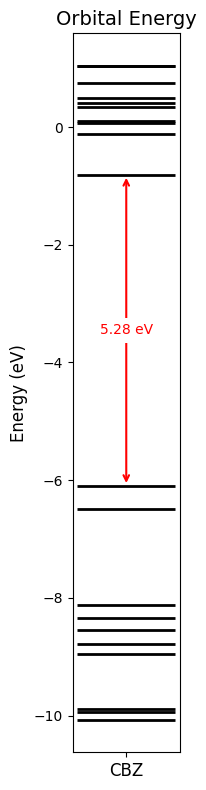

In [24]:
# Load orbital energies
df_oe = pd.DataFrame(df["orbitals"][0])

# Separate occupied and virtual orbitals
occupied = df_oe[df_oe["OCC"] > 0].sort_values("eV")
virtual  = df_oe[df_oe["OCC"] == 0].sort_values("eV")

# Extract HOMO and LUMO
homo = occupied["eV"].max()
lumo = virtual["eV"].min()
gap = lumo - homo

# Select only 6 HOMO and 6 LUMO
sel_occ = occupied.tail(10)   # last 6 occupied
sel_vir = virtual.head(10)    # first 6 virtual
selected_orbs = pd.concat([sel_occ, sel_vir])

# Plot
plt.figure(figsize=(2,8))

# Orbital levels (all black lines)
for e in selected_orbs["eV"]:
    plt.hlines(e, xmin=0.5, xmax=1.5, colors="black", lw=2)

# Vertical arrow centered at x=1.0
plt.annotate("", xy=(1.0, lumo), xytext=(1.0, homo),
             arrowprops=dict(arrowstyle="<->", lw=1.5, color="red"))

# Gap label, shifted slightly to the right for readability
plt.text(1.0, (homo + lumo) / 2, f"{gap:.2f} eV",
         va="center", ha="center", color="red",
         bbox=dict(facecolor="white", edgecolor="none", alpha=1))

# Labels and style
plt.ylabel("Energy (eV)", fontsize=12)
plt.xticks([1], ["CBZ"], fontsize=12)
plt.title("Orbital Energy", fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()


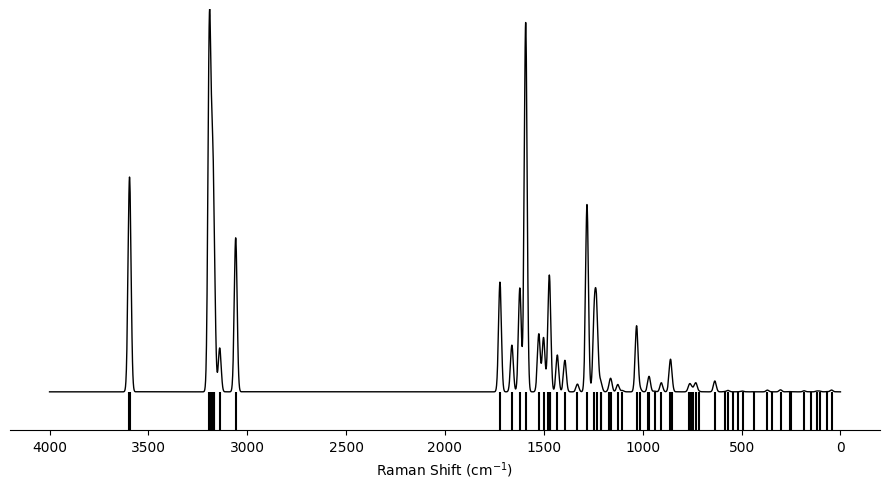

In [25]:
# Example dataframe
df_raman = pd.DataFrame(df["raman_spectrum"].iloc[0])

# Define Raman shift grid (adjust as needed)
shifts = np.linspace(0, 4000, 8000)  # cm⁻1

# Gaussian broadening width (FWHM in cm⁻1)
fwhm = 17 # Full Width at Half Maximum - Boardening
sigma = fwhm / (2 * np.sqrt(2 * np.log(2))) # STD of the Gaussian function - 

# Build continuous Raman spectrum
spectrum = np.zeros_like(shifts)
for _, row in df_raman.iterrows():
    nu0 = row["freq_cm-1"]
    inten = row["activity"]
    spectrum += inten * np.exp(-(shifts - nu0) ** 2 / (2 * sigma ** 2))

# === Plot Raman figure ===
fig, ax = plt.subplots(figsize=(9,5))

# Continuous spectrum
ax.plot(shifts, spectrum, color="black", lw=1)

# Restrict dataframe to the same range as shifts
df_raman_filtered = df_raman[(df_raman["freq_cm-1"] >= shifts.min()) &
                             (df_raman["freq_cm-1"] <= shifts.max())]

# Stick spectrum (below baseline)
stick_height = spectrum.max() * 0.1
for _, row in df_raman_filtered.iterrows():
    ax.vlines(row["freq_cm-1"], -stick_height, 0, color="black")

# Formatting
ax.set_xlabel("Raman Shift (cm$^{-1}$)")
ax.set_ylabel("Intensity (a.u.)")

# Extend y so sticks visible
ax.set_ylim(-stick_height*1, spectrum.max())

# Hide all spines except bottom
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)

# Hide y ticks and labels
ax.yaxis.set_visible(False)
ax.invert_xaxis()  # Raman shift decreases to the right

plt.tight_layout()
plt.show()

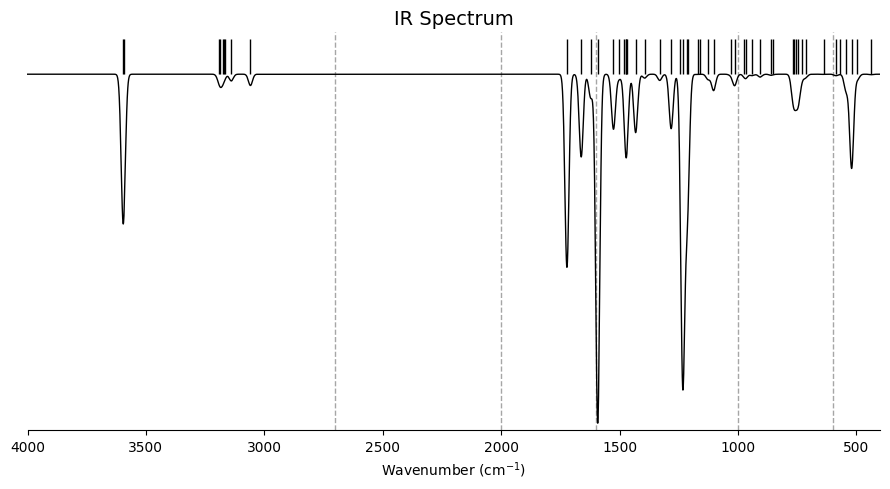

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================
# IR SPECTRUM: Discrete + Continuous Combined
# ============================================

# === Example IR dataframe (from single molecule) ===
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[0])

# === Define wavenumber grid ===
wavenumbers = np.linspace(400, 4000, 8000)  # cm⁻¹

# === Gaussian broadening parameters ===
fwhm = 20.0  # Full Width at Half Maximum (cm⁻¹)
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# === Sample conditions (Beer-Lambert Law) ===
c = 0.01  # concentration (mol/L)
l = 1.0   # path length (cm)

# === Calculate Absorbance ===
# A = ε × c × l
df_ir["Absorbance"] = df_ir["eps"] * c * l

# === Build continuous IR spectrum (absorbance) ===
absorbance_curve = np.zeros_like(wavenumbers)
for _, row in df_ir.iterrows():
    nu0 = row["freq_cm-1"]
    inten = row["Absorbance"]
    absorbance_curve += inten * np.exp(-0.5 * ((wavenumbers - nu0) / sigma) ** 2)

# === Convert to Transmittance ===
# T = 10^(-A) × 100
# Baseline = 100% (no absorption), dips toward 0% (strong absorption)
transmittance_curve = 10**(-absorbance_curve) * 100

# Normalize transmittance to 0-100 range
t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
if t_max > t_min:
    transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

# === IR region boundaries ===
region_boundaries = [2700, 2000, 1600, 1000, 600]

# === Plot IR spectrum ===
fig, ax = plt.subplots(figsize=(9, 5))

# Add regional boundaries (background)
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

# Plot continuous transmittance spectrum (dips show absorption)
ax.plot(wavenumbers, transmittance_curve, color="black", lw=1, label="IR Spectrum")

# === Add discrete stick spectrum ABOVE baseline (100%) ===
# Filter dataframe to wavenumber range
df_ir_filtered = df_ir[(df_ir["freq_cm-1"] >= wavenumbers.min()) &
                        (df_ir["freq_cm-1"] <= wavenumbers.max())]

# Calculate spectrum range for proportional stick height
spectrum_range = transmittance_curve.max() - transmittance_curve.min()
stick_height = spectrum_range * 0.1  # 10% of spectrum height (same as Raman)

# Stick spectrum (showing discrete frequencies above 100% baseline)
for _, row in df_ir_filtered.iterrows():
    freq = row["freq_cm-1"]
    # Draw stick upward from 100% baseline with fixed height
    ax.vlines(freq, 100, 100 + stick_height, color="black", linewidth=1)

# === Formatting ===
ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("Intensity (a.u.)")

# Extend y-axis to show sticks above baseline
ax.set_ylim(transmittance_curve.min() - stick_height * 0.2, 100 + stick_height * 1.2)
ax.set_xlim(400, 4000)

# Hide all spines except bottom
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)

# Hide y ticks and labels
ax.yaxis.set_visible(False)

# Invert x-axis (IR convention: high to low wavenumber)
ax.invert_xaxis()

# === Automatic region labels (middle between boundaries) ===
# Define region names
region_names = []

# Add upper boundary for first region and lower boundary for last region
extended_boundaries = [4000] + region_boundaries + [400]

# Calculate middle positions automatically
for i in range(len(extended_boundaries) - 1):
    left_boundary = extended_boundaries[i]
    right_boundary = extended_boundaries[i + 1]
    middle_position = (left_boundary + right_boundary) / 2
    
    # Only add label if we have a name for this region
    if i < len(region_names):
        ax.text(middle_position, 112, region_names[i], 
                rotation=0, ha='center', va='bottom', 
                fontsize=9, color='gray', alpha=0.7)

plt.title("IR Spectrum", fontsize=14)
plt.tight_layout()
plt.show()

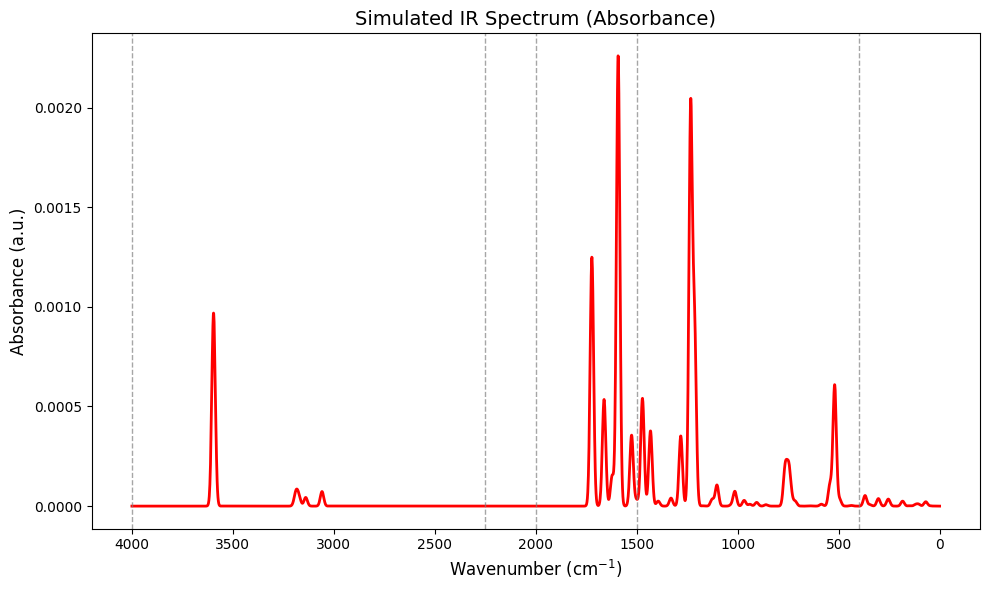

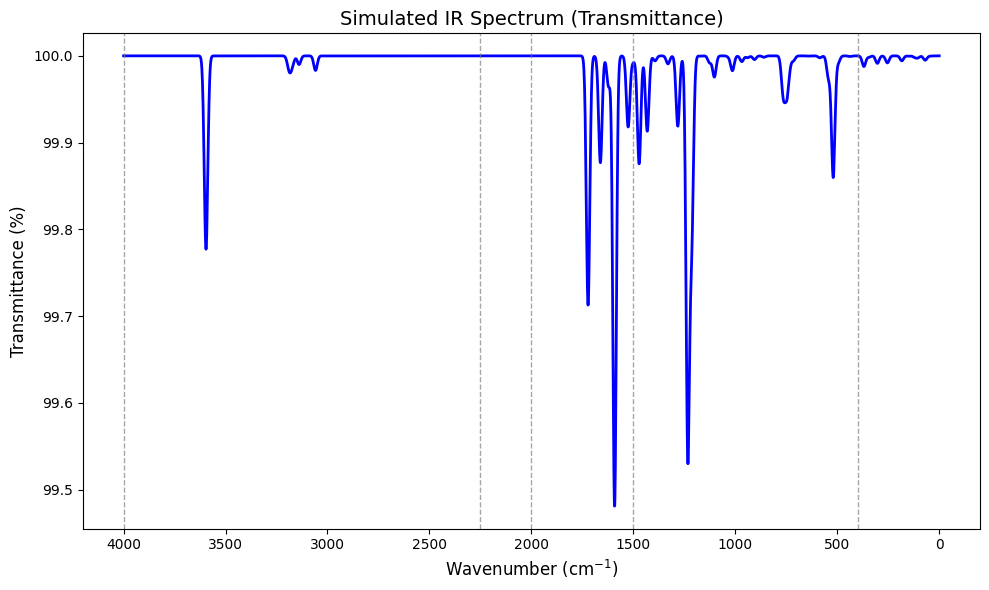

In [27]:
# Extract IR data from dataframe
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[0])

# Set arbitrary sample conditions
c = 0.01  # mol/L (concentration)
l = 1.0   # cm (path length)

# Calculate absorbance
df_ir["Absorbance"] = df_ir["eps"] * c * l

# Define frequency grid (0–4000 cm-1, step = 1)
x = np.linspace(0, 4000, 4000)

# Broadening parameter (Gaussian width)
fwhm = 20.0     # full width at half maximum in cm-1
                # 10–20 cm⁻¹ → high-resolution simulation (gas-phase, sharp peaks).
                # 20–40 cm⁻¹ → normal condensed-phase IR spectrum (broader peaks).
                # >50 cm⁻¹ → very broad bands (low resolution, strong overlap).
sigma = fwhm / (2*np.sqrt(2*np.log(2)))

# Initialize spectrum
absorbance_curve = np.zeros_like(x)

# Add Gaussian peaks
for _, row in df_ir.iterrows():
    freq = row["freq_cm-1"]
    inten = row["Absorbance"]
    absorbance_curve += inten * np.exp(-0.5 * ((x - freq)/sigma)**2)

# Convert to transmittance
transmittance_curve = 10**(-absorbance_curve) * 100

# Define IR region boundaries
region_boundaries = [4000, 2250, 2000, 1500, 400]

# Plot spectrum (Absorbance)
plt.figure(figsize=(10,6))
plt.plot(x, absorbance_curve, 'r-', lw=2)

# Add vertical dashed lines for IR regions
for boundary in region_boundaries:
    plt.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

plt.xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
plt.ylabel("Absorbance (a.u.)", fontsize=12)
plt.title("Simulated IR Spectrum (Absorbance)", fontsize=14)
plt.gca().invert_xaxis()  # optional: like experimental spectra
plt.tight_layout()
plt.show()

# Plot spectrum (Transmittance)
plt.figure(figsize=(10,6))
plt.plot(x, transmittance_curve, 'b-', lw=2)

# Add vertical dashed lines for IR regions
for boundary in region_boundaries:
    plt.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

plt.xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
plt.ylabel("Transmittance (%)", fontsize=12)
plt.title("Simulated IR Spectrum (Transmittance)", fontsize=14)
plt.gca().invert_xaxis()  # optional
plt.tight_layout()
plt.show()

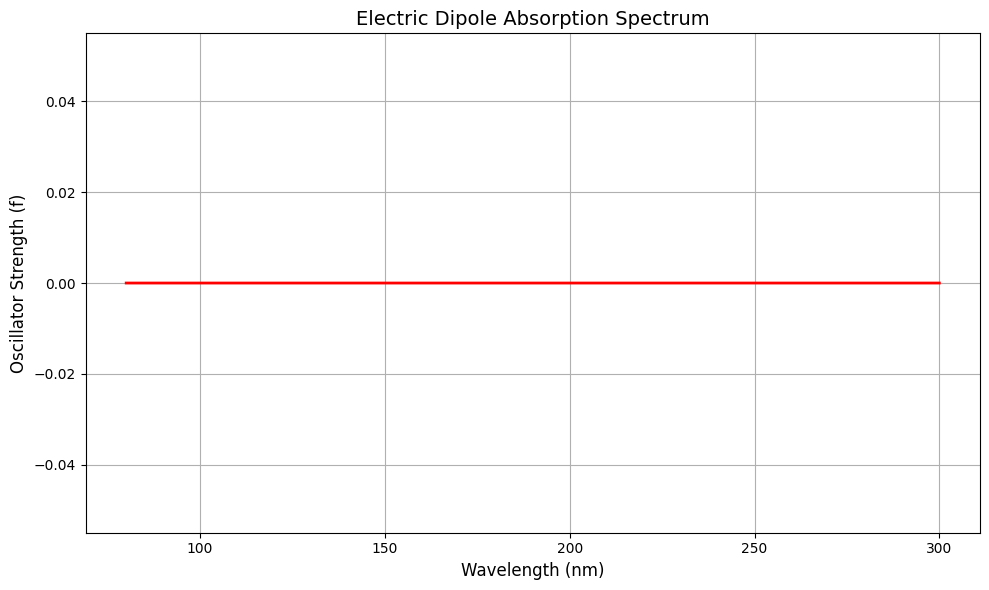

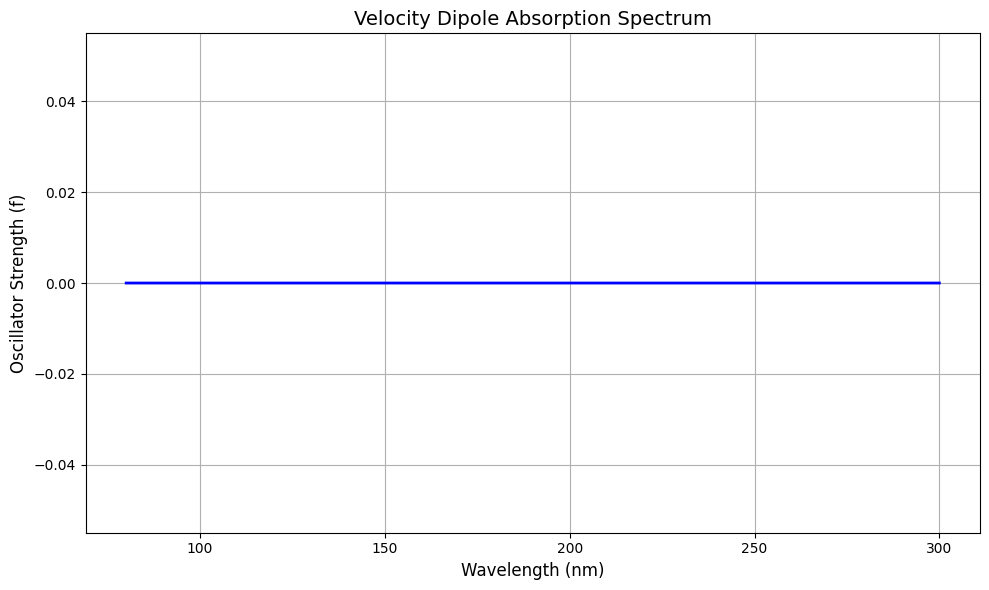

In [28]:
# Extract the two datasets
df_electric = pd.DataFrame(df["electric_dipole_spectrum"].iloc[2]['abs'])
df_velocity = pd.DataFrame(df["velocity_dipole_spectrum"].iloc[2]['abs'])

# Define wavelength range
wavelengths = np.linspace(80, 300, 5000)  # fine grid

# Gaussian width
fwhm = 20.0
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Initialize spectra
spectrum_electric = np.zeros_like(wavelengths)
spectrum_velocity = np.zeros_like(wavelengths)

# Add Gaussian for each transition in electric dipole spectrum
for _, row in df_electric.iterrows():
    wl0 = row["wavelength_nm"]
    fosc = row["fosc_d2"]
    
    # Gaussian with peak = fosc
    spectrum_electric += fosc * np.exp(-(wavelengths - wl0) ** 2 / (2 * sigma ** 2))

# Add Gaussian for each transition in velocity dipole spectrum
for _, row in df_velocity.iterrows():
    wl0 = row["wavelength_nm"]
    fosc = row["fosc_p2"]
    
    # Gaussian with peak = fosc
    spectrum_velocity += fosc * np.exp(-(wavelengths - wl0) ** 2 / (2 * sigma ** 2))

# Plot Electric Dipole Spectrum
plt.figure(figsize=(10, 6))
# Stick spectrum
for _, row in df_electric.iterrows():
    plt.vlines(row["wavelength_nm"], 0, row["fosc_d2"], color="red", alpha=0.6)

# Continuous spectrum
plt.plot(wavelengths, spectrum_electric, 'r-', lw=2)
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Oscillator Strength (f)", fontsize=12)
plt.title("Electric Dipole Absorption Spectrum", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Velocity Dipole Spectrum
plt.figure(figsize=(10, 6))
# Stick spectrum
for _, row in df_velocity.iterrows():
    plt.vlines(row["wavelength_nm"], 0, row["fosc_p2"], color="blue", alpha=0.6)

# Continuous spectrum
plt.plot(wavelengths, spectrum_velocity, 'b-', lw=2)
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Oscillator Strength (f)", fontsize=12)
plt.title("Velocity Dipole Absorption Spectrum", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# Load spectra from DataFrame
dVG = pd.DataFrame(df["spectrum_file"].iloc[5])
dAH = pd.DataFrame(df["spectrum_file"].iloc[6])
dAHAS = pd.DataFrame(df["spectrum_file"].iloc[7])

# Extract data for VG spectrum
vg_data = pd.DataFrame(list(dVG["VG"]))
wl_nm_1 = 1e7 / vg_data["energy_cm1"]
y1 = vg_data["total_spectrum"].values

# Extract data for AH spectrum
ah_data = pd.DataFrame(list(dAH["AH"]))
wl_nm_2 = 1e7 / ah_data["energy_cm1"]
y2 = ah_data["total_spectrum"].values

# Extract data for AHAS spectrum
ahas_data = pd.DataFrame(list(dAHAS["AHAS"]))
wl_nm_3 = 1e7 / ahas_data["energy_cm1"]
y3 = ahas_data["total_spectrum"].values

# Normalize spectra
if y1.max() > 0:
    y1 = y1 / y1.max()
if y2.max() > 0:
    y2 = y2 / y2.max()
if y3.max() > 0:
    y3 = y3 / y3.max()

# Define wavelength grid (for xlim only)
wl_grid = np.linspace(125, 300, 5000)  # nm

# === Plot all three spectra ===
plt.figure(figsize=(8, 5))

plt.plot(wl_nm_3, y3, label="AHAS (2 Hrs 58 Mins)", color="red")
plt.plot(wl_nm_1, y1, label="VG (1 Hrs 35 Mins)", color="blue")
plt.plot(wl_nm_2, y2, label="AH (0 Hrs 58 Mins)", color="green")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Intensity (a.u.)")
plt.gca().invert_xaxis()  # shorter λ on the left
plt.xlim(wl_grid.min(), wl_grid.max())
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'VG'

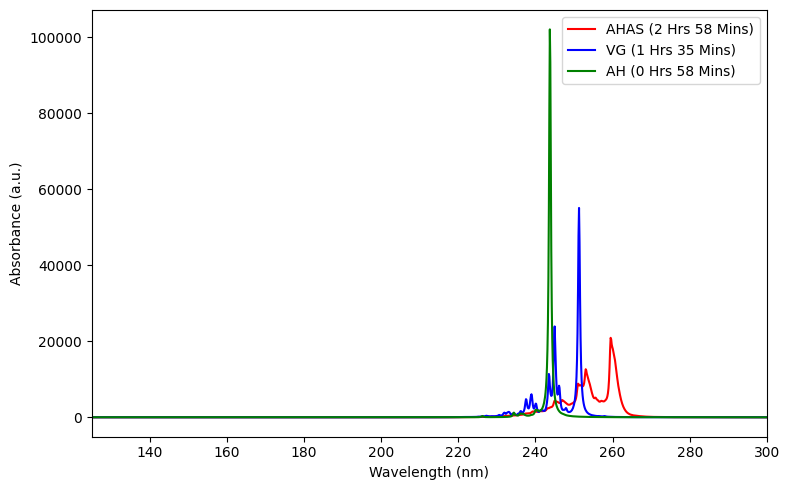

: 

: 

In [ ]:
# Load spectra from DataFrame
dVG = pd.DataFrame(df["spectrum_file"].iloc[5])
dAH = pd.DataFrame(df["spectrum_file"].iloc[6])
dAHAS = pd.DataFrame(df["spectrum_file"].iloc[7])

# Extract data for VG spectrum - assuming column name is "VG"
vg_data = pd.DataFrame(list(dVG["VG"]))  # Convert list of dicts to DataFrame
wl_nm_1 = 1e7 / vg_data["energy_cm1"]
y1 = vg_data["total_spectrum"]

# Extract data for AH spectrum - assuming column name is "AH"
ah_data = pd.DataFrame(list(dAH["AH"]))  # Convert list of dicts to DataFrame
wl_nm_2 = 1e7 / ah_data["energy_cm1"]
y2 = ah_data["total_spectrum"]

# Extract data for AHAS spectrum
ahas_data = pd.DataFrame(list(dAHAS["AHAS"]))  # Convert list of dicts to DataFrame
wl_nm_3 = 1e7 / ahas_data["energy_cm1"]
y3 = ahas_data["total_spectrum"]

# Define wavelength grid (for xlim only)
wl_grid = np.linspace(125, 300, 5000)  # nm

# === Plot all three spectra ===
plt.figure(figsize=(8, 5))

plt.plot(wl_nm_3, y3, label="AHAS (2 Hrs 58 Mins)", color="red")
plt.plot(wl_nm_1, y1, label="VG (1 Hrs 35 Mins)", color="blue")
plt.plot(wl_nm_2, y2, label="AH (0 Hrs 58 Mins)", color="green")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance (a.u.)")
plt.gca().invert_xaxis()  # shorter λ on the left
plt.xlim(wl_grid.min(), wl_grid.max())
plt.legend()
plt.tight_layout()
plt.show()

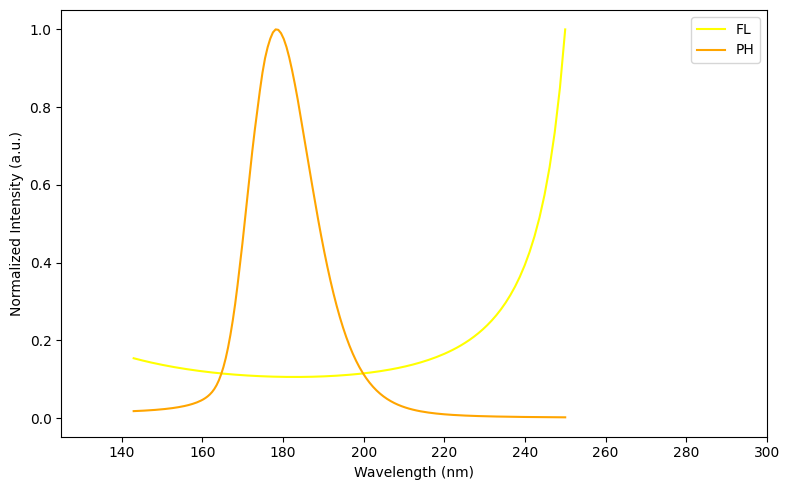

: 

: 

In [ ]:
# Load spectra from DataFrame
dFL = pd.DataFrame(df["spectrum_file"].iloc[22])
dPH = pd.DataFrame(df["spectrum_file"].iloc[21])

# Extract FL spectrum
fl_data = pd.DataFrame(list(dFL["FLUOR"]))
wl_nm_4 = 1e7 / fl_data["energy_cm1"]
y4 = fl_data["total_spectrum"].values

# Extract PH spectrum
ph_data = pd.DataFrame(list(dPH["PHOSP"]))
wl_nm_5 = 1e7 / ph_data["energy_cm1"]
y5 = ph_data["total_spectrum"].values

# Normalize both spectra
if y4.max() > 0:
    y4 = y4 / y4.max()
if y5.max() > 0:
    y5 = y5 / y5.max()

# Define wavelength grid (for xlim only)
wl_grid = np.linspace(125, 300, 5000)  # nm

# === Plot all spectra ===
plt.figure(figsize=(8, 5))

plt.plot(wl_nm_4, y4, label="FL", color="yellow")
plt.plot(wl_nm_5, y5, label="PH", color="orange")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Intensity (a.u.)")
plt.gca().invert_xaxis()  # shorter λ on the left
plt.xlim(wl_grid.min(), wl_grid.max())
plt.legend()
plt.tight_layout()
plt.show()


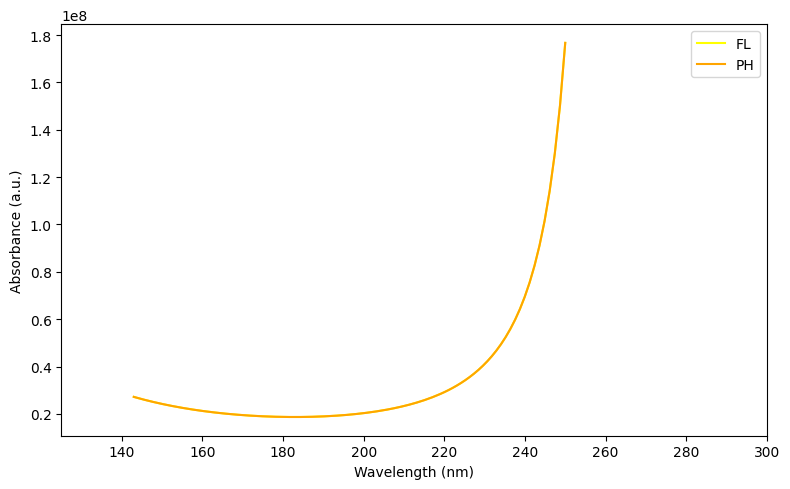

: 

: 

In [ ]:
# Load spectra from DataFrame
dFL = pd.DataFrame(df["spectrum_file"].iloc[22])
dPH = pd.DataFrame(df["spectrum_file"].iloc[21])

# Extract data for VG spectrum - assuming column name is "VG"
fl_data = pd.DataFrame(list(dFL["FLUOR"]))
wl_nm_4 = 1e7 / fl_data["energy_cm1"]
y4 = fl_data["total_spectrum"]

ph_data = pd.DataFrame(list(dPH["PHOSP"]))
wl_nm_5 = 1e7 / fl_data["energy_cm1"]
y5 = fl_data["total_spectrum"]

# Define wavelength grid (for xlim only)
wl_grid = np.linspace(125, 300, 5000)  # nm

# === Plot all three spectra ===
plt.figure(figsize=(8, 5))

plt.plot(wl_nm_4, y4, label="FL", color="yellow")
plt.plot(wl_nm_5, y5, label="PH", color="orange")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance (a.u.)")
plt.gca().invert_xaxis()  # shorter λ on the left
plt.xlim(wl_grid.min(), wl_grid.max())
plt.legend()
plt.tight_layout()
plt.show()

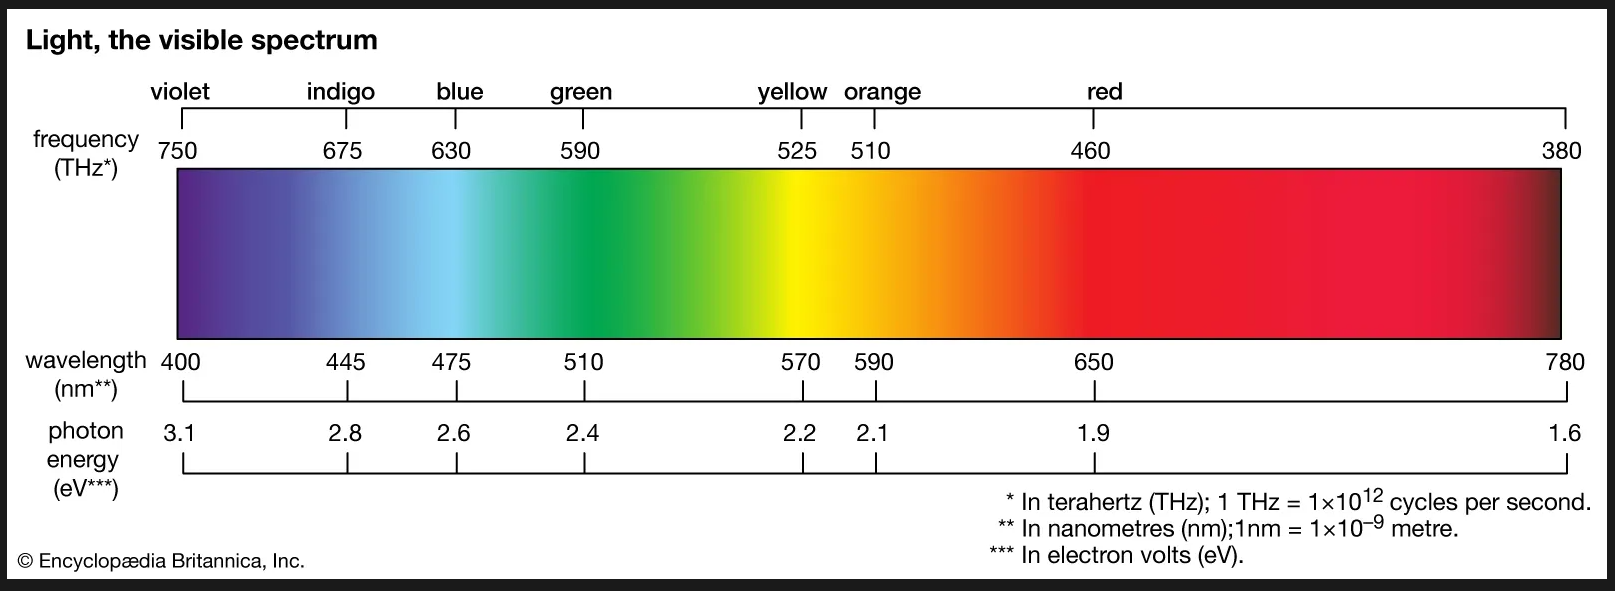

# Development

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

# Extract IR data from dataframe
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[1])

# Set arbitrary sample conditions
c = 0.01  # mol/L (concentration)
l = 1.0   # cm (path length)

# Calculate absorbance
df_ir["Absorbance"] = df_ir["eps"] * c * l

# Broadening parameter (Gaussian width)
fwhm = 20.0     # full width at half maximum in cm-1
sigma = fwhm / (2*np.sqrt(2*np.log(2)))

def plot_ir_spectrum(scale_factor=1.0):
    """
    Plot IR spectrum with adjustable scale factor for x-axis values
    
    Parameters:
    scale_factor (float): Scale factor for wavenumber values (0-1)
                         1.0 = original values (0-4000 cm-1)
                         0.5 = scaled down values (0-2000 cm-1)
                         0.1 = heavily scaled down (0-400 cm-1)
    """
    
    # Define frequency grid (always 4000 points, but x-values are scaled)
    x_original = np.linspace(0, 4000, 4000)
    x_scaled = x_original * scale_factor  # Scale the x-axis values
    
    # Initialize spectrum
    absorbance_curve = np.zeros_like(x_scaled)
    
    # Add Gaussian peaks using scaled frequencies
    for _, row in df_ir.iterrows():
        freq_original = row["freq_cm-1"]
        freq_scaled = freq_original * scale_factor  # Scale the peak frequency
        inten = row["Absorbance"]
        
        # Calculate scaled sigma for proper peak width
        sigma_scaled = sigma * scale_factor
        
        absorbance_curve += inten * np.exp(-0.5 * ((x_scaled - freq_scaled)/sigma_scaled)**2)
    
    # Convert to transmittance
    transmittance_curve = 10**(-absorbance_curve) * 100
    
    # Define IR region boundaries (keep original, unscaled)
    region_boundaries_original = [4000, 2250, 2000, 1500, 400]
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot spectrum (Absorbance)
    ax1.plot(x_scaled, absorbance_curve, 'r-', lw=2)
    
    # Add vertical dashed lines for IR regions (original positions)
    for boundary in region_boundaries_original:
        ax1.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    
    ax1.set_xlabel("Scaled Wavenumber (cm$^{-1}$)", fontsize=12)
    ax1.set_ylabel("Absorbance (a.u.)", fontsize=12)
    ax1.set_title(f"Simulated IR Spectrum (Absorbance) - Scale Factor: {scale_factor:.2f}", fontsize=14)
    ax1.invert_xaxis()  # like experimental spectra
    ax1.grid(True, alpha=0.3)
    
    # Plot spectrum (Transmittance)
    ax2.plot(x_scaled, transmittance_curve, 'b-', lw=2)
    
    # Add vertical dashed lines for IR regions (original positions)
    for boundary in region_boundaries_original:
        ax2.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    
    ax2.set_xlabel("Scaled Wavenumber (cm$^{-1}$)", fontsize=12)
    ax2.set_ylabel("Transmittance (%)", fontsize=12)
    ax2.set_title(f"Simulated IR Spectrum (Transmittance) - Scale Factor: {scale_factor:.2f}", fontsize=14)
    ax2.invert_xaxis()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print some useful information
    print(f"Scale Factor: {scale_factor:.2f}")
    print(f"Original Range: 0 - 4000 cm⁻¹")
    print(f"Scaled Range: 0 - {4000 * scale_factor:.0f} cm⁻¹")
    print(f"Peak frequencies scaled by factor of {scale_factor:.2f}")
    print(f"Example: Original 3000 cm⁻¹ → Scaled {3000 * scale_factor:.0f} cm⁻¹")

# Create interactive slider
scale_slider = FloatSlider(
    value=1.0,           # Initial value (no scaling)
    min=0.1,             # Minimum value (10% of original scale)
    max=1.0,             # Maximum value (original scale)
    step=0.01,           # Step size
    description='Scale Factor:',
    disabled=False,
    continuous_update=False,  # Only update when slider is released
    orientation='horizontal',
    readout=True,
    readout_format='.2f'
)

# Create the interactive plot
interactive_plot = interact(plot_ir_spectrum, scale_factor=scale_slider)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Scale Factor:', max=1.0, mi…

: 

: 

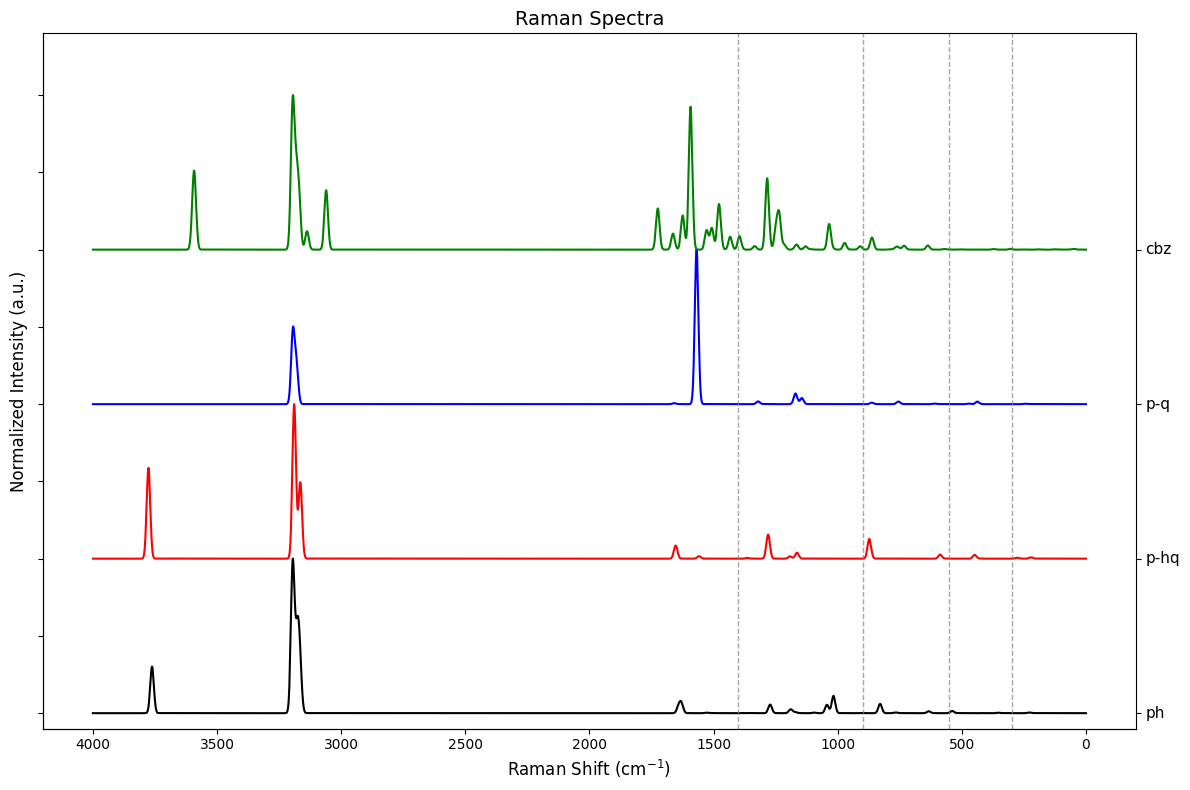

: 

: 

In [ ]:
# Your input parameters
datasets = [1, 9, 10, 8]
labels_input = ["ph", "p-hq", "p-q", "cbz"]
y_space = 1 #Austable spacing multiplier between plots

# Define Raman shift grid (adjust as needed)
shifts = np.linspace(0, 4000, 8000)  # cm⁻¹

# Gaussian broadening width (FWHM in cm⁻¹)
fwhm = 17  # Full Width at Half Maximum - Broadening
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # STD of the Gaussian function

# Define colors for different datasets
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Define Raman region boundaries
region_boundaries = [300, 550, 900, 1400]

# === Process multiple datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []  # Store all spectra for y-axis calculation
y_offsets = []  # Store y-offsets for each spectrum

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    # Get the dataframe for this dataset
    df_raman = pd.DataFrame(df["raman_spectrum"].iloc[dataset_idx])
    
    # Build continuous Raman spectrum
    spectrum = np.zeros_like(shifts)
    for _, row in df_raman.iterrows():
        nu0 = row["freq_cm-1"]
        inten = row["activity"]
        spectrum += inten * np.exp(-(shifts - nu0) ** 2 / (2 * sigma ** 2))
    
    # Normalize spectrum (optional - you can remove this if not needed)
    if spectrum.max() > 0:
        spectrum = spectrum / spectrum.max()
    
    spectra.append(spectrum)
    
    # Calculate y-offset for stacking
    if i == 0:
        y_offset = 0
    else:
        # Calculate spacing based on maximum intensity difference
        max_prev_spectrum = max([s.max() for s in spectra[:-1]])
        y_offset = sum([s.max() * y_space for s in spectra[:-1]]) + max_prev_spectrum * (y_space - 1)
    
    y_offsets.append(y_offset)
    
    # Plot the spectrum with offset
    color = colors[i % len(colors)]
    ax.plot(shifts, spectrum + y_offset, color=color, lw=1.5, label=label)

# Add vertical dashed lines for Raman regions
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

# === Formatting ===
ax.set_xlabel("Raman Shift (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Intensity (a.u.)", fontsize=12)

# Set y-limits to show all spectra nicely
total_height = sum([s.max() for s in spectra]) + sum([s.max() * (y_space - 1) for s in spectra[:-1]])
ax.set_ylim(-0.1, total_height * 1.1)

# Hide top and right spines for cleaner look
ax.spines["right"].set_visible(False)
ax.set_yticklabels([])  # Hide left y-tick labels

# Create right y-axis for labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())

# Position labels on the right axis at the baseline of each spectrum
label_positions = []
for spectrum, y_offset, label in zip(spectra, y_offsets, labels_input):
    label_y_position = y_offset  # baseline instead of max()/2
    label_positions.append(label_y_position)

# Set the right axis ticks and labels
ax2.set_yticks(label_positions)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)


# Invert x-axis (Raman shift decreases to the right)
ax.invert_xaxis()

plt.title("Raman Spectra", fontsize=14)
plt.tight_layout()
plt.show()

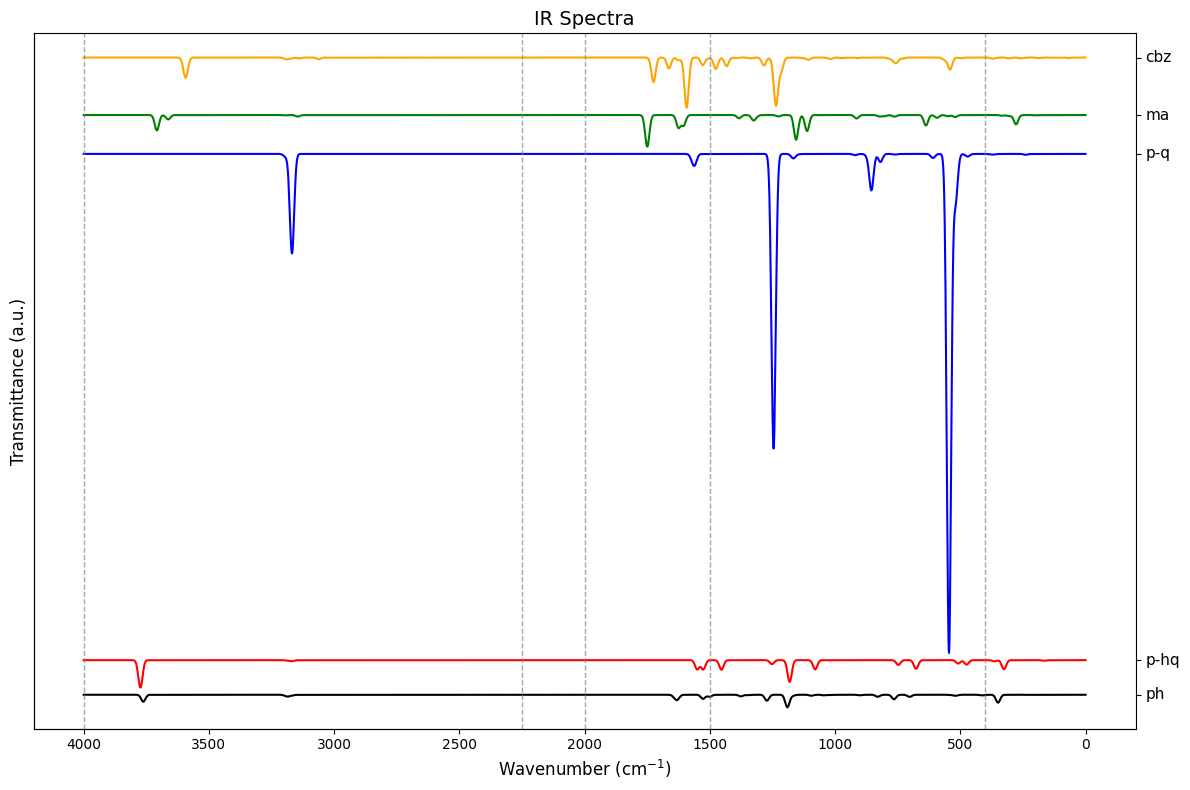

: 

: 

In [ ]:
# === Input parameters ===
datasets = [1, 9, 10, 11, 8]
labels_input = ["ph", "p-hq", "p-q", "ma", "cbz"]
y_space = 15   # Minimal vertical spacing between stacked spectra

# Define wavenumber grid (adjust as needed)
x = np.linspace(0, 4000, 4000)  # cm⁻¹

# Scale factor for x-axis (DFT usually overestimates → need <1, e.g., 0.96)
scale_x = 1

# Shift for x-axis (cm⁻¹, positive = shift to higher wavenumber, negative = lower)
shift_x = 0

# Gaussian broadening width (FWHM in cm⁻¹)
fwhm = 20.0  # Full Width at Half Maximum - Broadening for IR
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # STD of the Gaussian function

# Set arbitrary sample conditions
c = 0.01  # mol/L (concentration)
l = 1.0   # cm (path length)

# Define colors for different datasets
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Define IR region boundaries
region_boundaries = [4000, 2250, 2000, 1500, 400]

# === Process multiple datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0  # Tracks the highest point of the stacked spectra

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    # Get the dataframe for this dataset
    df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_idx])
    
    # Calculate absorbance
    df_ir["Absorbance"] = df_ir["eps"] * c * l
    
    # Build continuous IR spectrum (absorbance)
    absorbance_curve = np.zeros_like(x)
    for _, row in df_ir.iterrows():
        freq = row["freq_cm-1"] * scale_x + shift_x
        inten = row["Absorbance"]
        absorbance_curve += inten * np.exp(-0.5 * ((x - freq) / sigma) ** 2)
    
    # Normalize absorbance (optional)
    if absorbance_curve.max() > 0:
        absorbance_curve *= 2.0  
    
    # Convert to transmittance
    transmittance_curve = 10**(-absorbance_curve) * 100
    
    # Scale peaks while keeping baseline
    baseline = transmittance_curve.max()  # ~100%
    peak_variations = transmittance_curve - baseline  # dips
    scaling_factor = 100
    transmittance_curve = baseline + (peak_variations * scaling_factor)
    
    spectra.append(transmittance_curve)
    
    # === NEW y_offset system ===
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = transmittance_curve.min()
        # ensure minimal spacing
        y_offset = prev_top - this_bottom + y_space
    
    # Update current top for next loop
    current_top = y_offset + transmittance_curve.max()
    y_offsets.append(y_offset)
    
    # Plot spectrum with offset
    color = colors[i % len(colors)]
    ax.plot(x, transmittance_curve + y_offset, color=color, lw=1.5)

# === Add vertical dashed lines for IR regions ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

# === Formatting ===
ax.set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Transmittance (a.u.)", fontsize=12)

# Set auto y-limit based on stacked spectra
ax.set_ylim(30, current_top + 50)


ax.spines["right"].set_visible(False)
ax.set_yticks([])

# Right axis for labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks([])

label_positions = [offset + spec.max() for spec, offset in zip(spectra, y_offsets)]
ax2.set_yticks(label_positions)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (wavenumber decreases to the right, like experimental spectra)
ax.invert_xaxis()

plt.title("IR Spectra", fontsize=14)
plt.tight_layout()
plt.show()


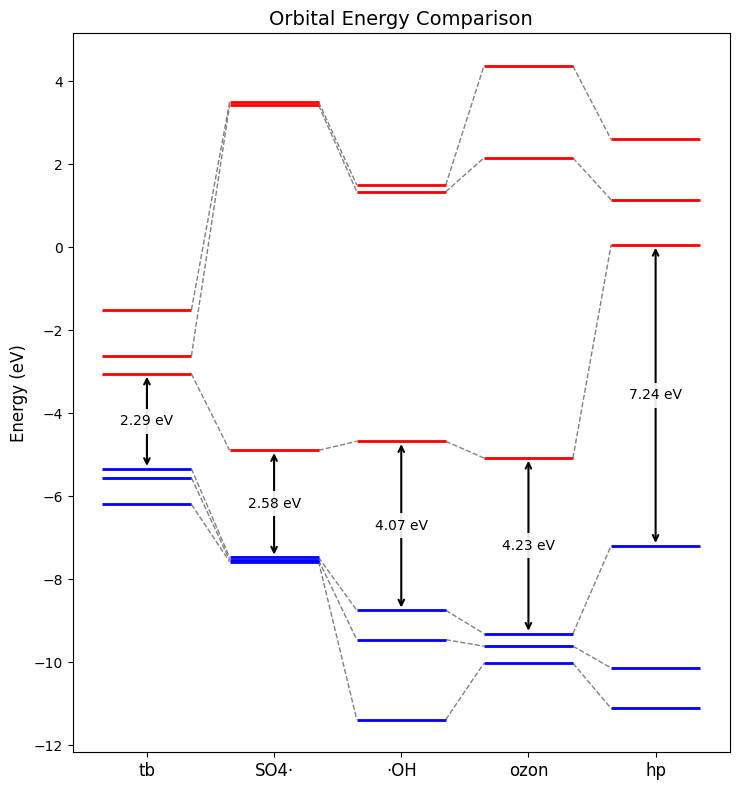

: 

: 

In [ ]:
# Load orbital energies for multiple datasets
# Format options:
# datasets = [1, 2, 3]         - Simple list: connects all adjacent (1-2, 2-3)
# datasets = [[1, 2], [3, 4]]  - Nested list: connects within groups only (1-2, 3-4)
datasets = [18, 15, 14, 16, 17] # , [8]]

# Manual labels - must match the structure of datasets
# For flat datasets: ["Label1", "Label2", "Label3"]
# For nested datasets: [["Label1"], ["Label2", "Label3"]]
labels_input = ["tb", "SO4·", "·OH", "ozon", "hp"] # ["cbz"]] 

n_orbitals = 6  # Number of orbitals to display above and below the gap
overaxis = .35

# Handle both flat and nested list formats
if any(isinstance(item, list) for item in datasets):
    # Nested format: [[1,2], [3,4,6], [5]]
    flat_datasets = [item for sublist in datasets for item in (sublist if isinstance(sublist, list) else [sublist])]
    connection_groups = datasets
    # Flatten labels to match flat_datasets
    flat_labels = [item for sublist in labels_input for item in (sublist if isinstance(sublist, list) else [sublist])]
else:
    # Flat format: [1, 2, 3]
    flat_datasets = datasets
    connection_groups = [datasets]  # Treat all as one group
    flat_labels = labels_input

# Verify labels match datasets
if len(flat_labels) != len(flat_datasets):
    raise ValueError(f"Number of labels ({len(flat_labels)}) must match number of datasets ({len(flat_datasets)})")

df_oe_list = [pd.DataFrame(df["orbitals"][i]) for i in flat_datasets]

# Calculate data for all datasets
orbital_data = []
for i, df_oe in enumerate(df_oe_list):
    # Separate occupied and virtual orbitals
    occupied = df_oe[df_oe["OCC"] > 0].sort_values("eV")
    virtual  = df_oe[df_oe["OCC"] == 0].sort_values("eV")

    # Extract HOMO and LUMO
    homo = occupied["eV"].max()
    lumo = virtual["eV"].min()
    gap = lumo - homo

    # Select orbitals
    sel_occ = occupied.tail(int(n_orbitals*.5))
    sel_vir = virtual.head(int(n_orbitals*.5))
    selected_orbs = pd.concat([sel_occ, sel_vir])
    
    orbital_data.append({
        'selected_orbs': selected_orbs,
        'homo': homo,
        'lumo': lumo,
        'gap': gap,
        'label': flat_labels[i]
    })

# Plot
n_datasets = len(orbital_data)
fig_width = max(2, n_datasets * 1.5)  # Adjust width based on number of datasets
plt.figure(figsize=(fig_width, 8))

# Plot each dataset
for i, data in enumerate(orbital_data):
    x_center = i + 1
    x_left = x_center - overaxis
    x_right = x_center + overaxis
    
    # Orbital levels with different colors for HOMO/LUMO
    for _, row in data['selected_orbs'].iterrows():
        e = row["eV"]
        occ = row["OCC"]
        
        # Color based on occupation: blue for occupied (HOMO), red for virtual (LUMO)
        color = "blue" if occ > 0 else "red"
        plt.hlines(e, xmin=x_left, xmax=x_right, colors=color, lw=2)

    # Vertical arrow centered at x position
    plt.annotate("", xy=(x_center, data['lumo']), xytext=(x_center, data['homo']),
                 arrowprops=dict(arrowstyle="<->", lw=1.5, color="black"))

    # Gap label
    plt.text(x_center, (data['homo'] + data['lumo']) / 2, f"{data['gap']:.2f} eV",
             va="center", ha="center", color="black", fontsize=10,
             bbox=dict(facecolor="white", edgecolor="none", alpha=0.9))

# Add dashed lines connecting same orbital levels across datasets
if n_datasets > 1:
    # Get orbital energies for each dataset, sorted consistently
    all_occupied = []
    all_virtual = []
    
    for data in orbital_data:
        occupied = data['selected_orbs'][data['selected_orbs']["OCC"] > 0].sort_values("eV", ascending=False)
        virtual = data['selected_orbs'][data['selected_orbs']["OCC"] == 0].sort_values("eV")
        all_occupied.append(occupied["eV"].values)
        all_virtual.append(virtual["eV"].values)
    
    # Create connections based on grouping
    # Track position in the plot (not dataset index)
    plot_position = 0
    for group in connection_groups:
        if isinstance(group, list) and len(group) > 1:
            # Connect consecutive datasets within this group based on plot position
            group_positions = list(range(plot_position, plot_position + len(group)))
            
            # Connect occupied orbitals within this group
            max_occ = min(len(all_occupied[pos]) for pos in group_positions)
            for level in range(max_occ):
                for i in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[i], group_positions[i + 1]
                    x_start = (pos1 + 1) + overaxis  # Right edge of current bar
                    x_end = (pos2 + 1) - overaxis    # Left edge of next bar
                    y_start = all_occupied[pos1][level]
                    y_end = all_occupied[pos2][level]
                    plt.plot([x_start, x_end], [y_start, y_end], '--', color='gray', alpha=1, lw=1, zorder=0)
            
            # Connect virtual orbitals within this group
            max_vir = min(len(all_virtual[pos]) for pos in group_positions)
            for level in range(max_vir):
                for i in range(len(group_positions) - 1):
                    pos1, pos2 = group_positions[i], group_positions[i + 1]
                    x_start = (pos1 + 1) + overaxis  # Right edge of current bar
                    x_end = (pos2 + 1) - overaxis    # Left edge of next bar
                    y_start = all_virtual[pos1][level]
                    y_end = all_virtual[pos2][level]
                    plt.plot([x_start, x_end], [y_start, y_end], '--', color='gray', alpha=1, lw=1, zorder=0)
        
        # Update plot position for next group
        if isinstance(group, list):
            plot_position += len(group)
        else:
            plot_position += 1

# Labels and style
plt.ylabel("Energy (eV)", fontsize=12)
plt.xticks(range(1, n_datasets + 1), [data['label'] for data in orbital_data], fontsize=12)
plt.title("Orbital Energy Comparison", fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

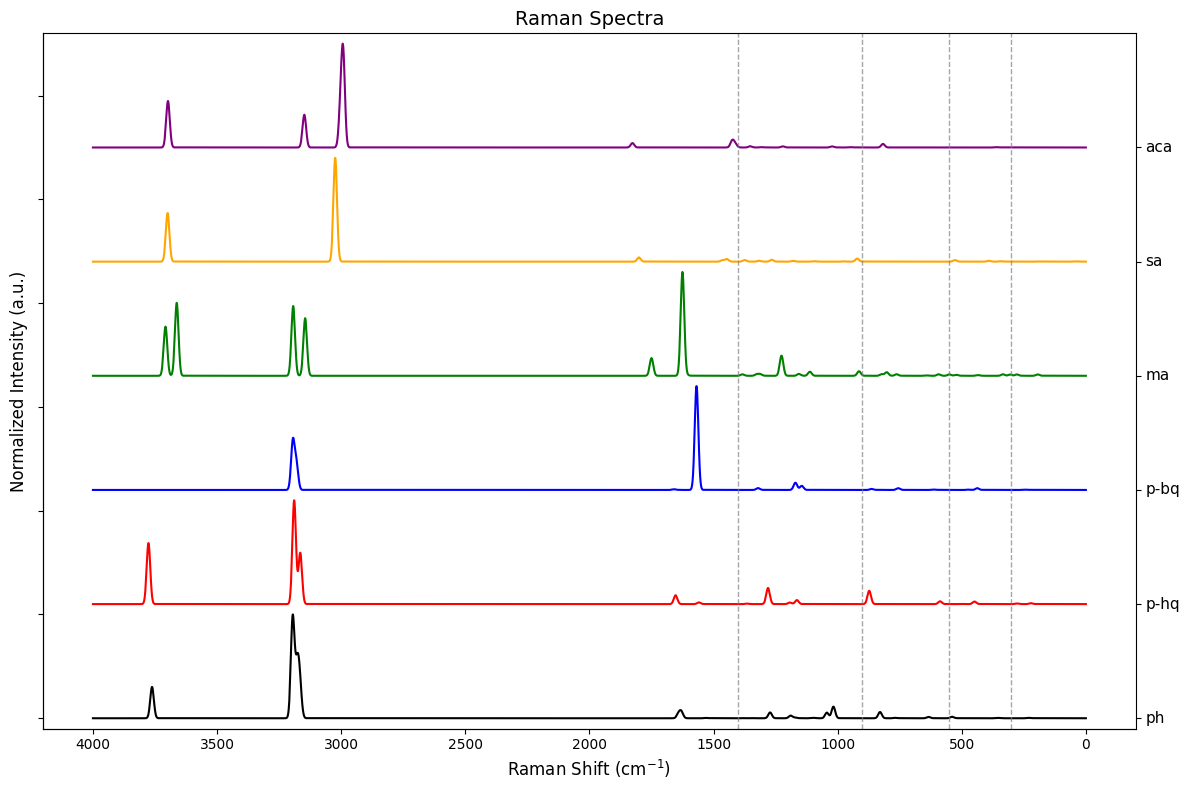

: 

: 

In [ ]:
# === Input parameters ===
datasets = [1, 9, 10, 11, 12, 13] # , 8]
labels_input = ["ph", "p-hq", "p-bq", "ma", "sa", "aca"] # , "cbz"]
y_space = 0.1  # Minimal vertical spacing between stacked spectra

# Define Raman shift grid
shifts = np.linspace(0, 4000, 8000)  # cm⁻¹

# Gaussian broadening width (FWHM in cm⁻¹)
fwhm = 17  # Full Width at Half Maximum
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # STD of the Gaussian

# Define colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Raman region boundaries
region_boundaries = [300, 550, 900, 1400]

# === Process multiple datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0  # track the top of stacked spectra

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    # Load dataframe for this dataset
    df_raman = pd.DataFrame(df["raman_spectrum"].iloc[dataset_idx])
    
    # Build continuous Raman spectrum
    spectrum = np.zeros_like(shifts)
    for _, row in df_raman.iterrows():
        nu0 = row["freq_cm-1"]
        inten = row["activity"]
        spectrum += inten * np.exp(-(shifts - nu0) ** 2 / (2 * sigma ** 2))
    
    # Normalize each spectrum to 1
    if spectrum.max() > 0:
        spectrum = spectrum / spectrum.max()
    
    spectra.append(spectrum)
    
    # === NEW offset system ===
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = spectrum.min()  # usually ~0
        # ensure minimal spacing
        y_offset = prev_top - this_bottom + y_space
    
    current_top = y_offset + spectrum.max()
    y_offsets.append(y_offset)
    
    # Plot spectrum with offset
    color = colors[i % len(colors)]
    ax.plot(shifts, spectrum + y_offset, color=color, lw=1.5)

# Add vertical dashed lines for Raman regions
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

# === Formatting ===
ax.set_xlabel("Raman Shift (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Intensity (a.u.)", fontsize=12)

# Set auto y-limit based on stacking
ax.set_ylim(-0.1, current_top + .1)

# Hide spines and ticks
ax.spines["right"].set_visible(False)
ax.set_yticklabels([])

# Create right y-axis for dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks([offset for offset in y_offsets])
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (like experimental Raman spectra)
ax.invert_xaxis()

plt.title("Raman Spectra", fontsize=14)
plt.tight_layout()
plt.show()


KeyError: 'raman_freq'

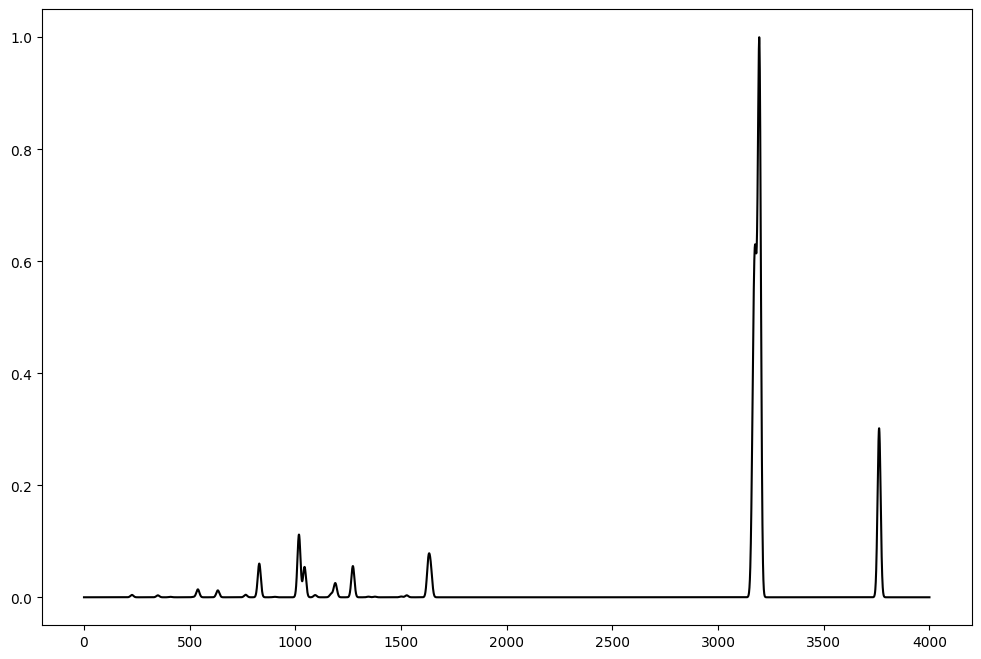

: 

: 

In [ ]:
# === Input parameters ===
datasets = [1] # , 8]
labels_input = ["ph"] # , "cbz"]
y_space = 0.1  # Minimal vertical spacing between stacked spectra

# Define Raman shift grid
shifts = np.linspace(0, 4000, 8000)  # cm⁻¹

# Gaussian broadening width (FWHM in cm⁻¹)
fwhm = 17  # Full Width at Half Maximum
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # STD of the Gaussian

# Define colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Raman region boundaries
region_boundaries = [300, 550, 900, 1400]

# === Process multiple datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0  # track the top of stacked spectra

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    # Load dataframe for this dataset
    df_raman = pd.DataFrame(df["raman_spectrum"].iloc[dataset_idx])
    
    # Build continuous Raman spectrum
    spectrum = np.zeros_like(shifts)
    for _, row in df_raman.iterrows():
        nu0 = row["freq_cm-1"]
        inten = row["activity"]
        spectrum += inten * np.exp(-(shifts - nu0) ** 2 / (2 * sigma ** 2))
    
    # Normalize each spectrum to 1
    if spectrum.max() > 0:
        spectrum = spectrum / spectrum.max()
    
    spectra.append(spectrum)
    
    # === NEW offset system ===
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = spectrum.min()  # usually ~0
        # ensure minimal spacing
        y_offset = prev_top - this_bottom + y_space
    
    current_top = y_offset + spectrum.max()
    y_offsets.append(y_offset)
    
    # Plot spectrum with offset
    color = colors[i % len(colors)]
    ax.plot(shifts, spectrum + y_offset, color=color, lw=1.5)

# === Add experimental spectrum with position control ===
plot_position = 0  # choose index where exp should be placed UNDER

# Interpolate and normalize exp data
exp_interp = np.interp(shifts, eks["raman_freq"], eks["intensity"])
exp_interp = exp_interp / exp_interp.max()

# Offset: place under the spectrum at plot_position
ref_offset = y_offsets[plot_position]
exp_offset = ref_offset - (exp_interp.max() + y_space)

# Plot experimental spectrum
ax.plot(shifts, exp_interp + exp_offset,
        color="black", lw=1.5, linestyle="--")

# Insert into offsets and labels
y_offsets.insert(plot_position, exp_offset)
labels_input.insert(plot_position, "ph Exp")

# === Formatting ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

ax.set_xlabel("Raman Shift (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Intensity (a.u.)", fontsize=12)

# Auto y-limit based on stacking
ax.set_ylim(min(y_offsets) - 0.1, max(y_offsets) + 1.2)

# Hide spines and ticks
ax.spines["right"].set_visible(False)
ax.set_yticklabels([])

# Create right y-axis for dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(y_offsets)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (like experimental Raman spectra)
ax.invert_xaxis()

plt.title("Raman Spectra", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# ---------- OpenBabel Import ----------
from openbabel import pybel
from tempfile import NamedTemporaryFile
import os

# ---------- Helper Function for Scientific Notation ----------

def parse_float(value):
    """Convert a string to float, handling scientific notation."""
    try:
        return float(value)
    except ValueError:
        return None    

# ---------- SMILES Generation Function ----------
def coords_to_smiles(mol_coords):
    """
    Convert (symbol, x, y, z) coordinates into a SMILES string using OpenBabel (pybel).
    """
    if not mol_coords:
        return None
        
    # Write coords to a temporary XYZ file
    with NamedTemporaryFile("w", suffix=".xyz", delete=False) as tmp:
        tmp.write(f"{len(mol_coords)}\n")
        tmp.write("Generated from dataframe\n")
        for atom, x, y, z in mol_coords:
            tmp.write(f"{atom} {x:.6f} {y:.6f} {z:.6f}\n")
        tmp_path = tmp.name

    try:
        # Read with pybel
        mol = next(pybel.readfile("xyz", tmp_path))
        
        # Convert to SMILES
        smi = mol.write("smi").strip()
        return smi.split()[0]
    except Exception as e:
        print(f"Warning: Could not generate SMILES: {e}")
        return None
    finally:
        # Clean up temporary file
        try:
            os.unlink(tmp_path)
        except:
            pass

# ---------- Geometry Info ----------
def parse_geometry_info(text):
    """Parse geometry file name, charge, and multiplicity from ORCA output."""
    geometry_info = {"filename": None, "charge": None, "multiplicity": None}

    # Try to find geometry file from "The coordinates will be read from file" line
    coords_match = re.search(
        r"The coordinates will be read from file:\s*(\S+)",
        text
    )
    if coords_match:
        geometry_file = coords_match.group(1)
        # Strip extension to get base name (e.g., "phs0" from "phs0.xyz")
        geometry_info["filename"] = os.path.splitext(geometry_file)[0]

    # Try to find geometry file, charge, and multiplicity from input section
    input_section_match = re.search(
        r"={10,}\s*(INPUT FILE|INPUT)\s*\n={10,}\n(.*?)\*{4}END OF INPUT\*{4}",
        text, flags=re.S | re.I
    )
    if input_section_match:
        input_section = input_section_match.group(2)
        # Look for * xyzfile charge multiplicity filename
        xyzfile_match = re.search(
            r"\*\s*xyzfile\s+(\d+)\s+(\d+)\s+(\S+)",
            input_section, flags=re.I
        )
        if xyzfile_match:
            geometry_info["charge"] = int(xyzfile_match.group(1))
            geometry_info["multiplicity"] = int(xyzfile_match.group(2))
            geometry_file = xyzfile_match.group(3)
            # Strip extension to get base name
            geometry_info["filename"] = os.path.splitext(geometry_file)[0]
    
    # If filename is still None, fallback to using the input filename without extension
    if geometry_info["filename"] is None:
        return None
    
    return geometry_info

# ---------- Cartesian ----------
def parse_last_cartesian(text):
    """Parse the last Cartesian coordinates block from ORCA output."""
    blocks = re.findall(
        r"CARTESIAN COORDINATES \(ANGSTROEM\)\n-+\n(.*?)\n\n",
        text, flags=re.S
    )
    if not blocks:
        return None
    last_block = blocks[-1].strip().splitlines()
    coords = []
    for line in last_block:
        parts = line.split()
        if len(parts) < 4:
            continue
        atom = parts[0]
        x, y, z = map(parse_float, parts[1:4])
        if None in (x, y, z):
            continue
        coords.append((atom, x, y, z))
    return coords

# ---------- Internal ----------
def parse_last_internal(text):
    """Parse the last internal coordinates block from ORCA output."""
    blocks = re.findall(
        r"INTERNAL COORDINATES \(ANGSTROEM\)\n-+\n(.*?)\n\n",
        text, flags=re.S
    )
    if not blocks:
        return None
    last_block = blocks[-1].strip().splitlines()
    coords = []
    for line in last_block:
        parts = line.split()
        if len(parts) < 7:
            continue
        atom = parts[0]
        bond, angle, dihedral = map(parse_float, parts[4:7])
        if None in (bond, angle, dihedral):
            continue
        coords.append((atom, bond, angle, dihedral))
    return coords

# ---------- Orbitals ----------
def parse_last_orbitals(text, as_df=False):
    """Parse the last orbital energies block from ORCA output.
    Handles both closed-shell and open-shell (spin-polarized) cases.
    """
    # --- Case 1: Open-shell (spin up / spin down blocks) ---
    spin_blocks = re.findall(
        r"SPIN UP ORBITALS\n.*?\n(.*?)(?=\n\s*SPIN DOWN ORBITALS|\Z)",
        text, flags=re.S
    )
    spin_down_blocks = re.findall(
        r"SPIN DOWN ORBITALS\n.*?\n(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    
    if spin_blocks and spin_down_blocks:
        spins = [("up", spin_blocks[-1]), ("down", spin_down_blocks[-1])]
    else:
        # --- Case 2: Closed-shell (single ORBITAL ENERGIES block) ---
        blocks = re.findall(
            r"ORBITAL ENERGIES\n-+\n\s*NO.*?\n(.*?)(?:\n\n|\Z)",
            text, flags=re.S
        )
        if not blocks:
            return None
        spins = [("na", blocks[-1])]  # "na" = not applicable (closed shell)

    orbitals = []
    for spin, block in spins:
        lines = block.strip().splitlines()
        for line in lines:
            parts = line.split()
            if not parts or not parts[0].isdigit() or len(parts) < 4:
                continue
            
            occ = parse_float(parts[1])
            energy_h = parse_float(parts[2])
            energy_ev = parse_float(parts[3])
            
            if None in (occ, energy_h, energy_ev):
                continue
            
            # Filter out fake test data - ORCA only produces OCC values of 0.0, 1.0, or 2.0
            if occ not in [0.0, 1.0, 2.0]:
                continue
                
            # Additional check for obvious fake data patterns
            if energy_h == occ + 1.0 and energy_ev == occ + 2.0:
                continue
            
            orbitals.append({
                "OCC": occ,
                "Eh": energy_h,
                "eV": energy_ev,
                "spin": spin
            })
    
    if not orbitals:
        return None

    # Separate occupied and virtual orbitals
    occupied = [orb for orb in orbitals if orb["OCC"] > 0.0]
    virtual = [orb for orb in orbitals if orb["OCC"] == 0.0]
    
    # Sort occupied orbitals by energy (descending - highest energy first)
    # HOMO is the highest energy occupied orbital
    occupied.sort(key=lambda x: x["Eh"], reverse=True)
    
    # Sort virtual orbitals by energy (ascending - lowest energy first)
    # LUMO is the lowest energy virtual orbital
    virtual.sort(key=lambda x: x["Eh"])
    
    # Assign levels for occupied orbitals
    for i, orb in enumerate(occupied):
        orb["lvl"] = i  # HOMO = 0, HOMO-1 = 1, HOMO-2 = 2, etc.
    
    # Assign levels for virtual orbitals
    for i, orb in enumerate(virtual):
        orb["lvl"] = i  # LUMO = 0, LUMO+1 = 1, LUMO+2 = 2, etc.
    
    # Combine back into original order (by energy)
    all_orbitals = occupied + virtual
    all_orbitals.sort(key=lambda x: x["Eh"])
    
    if as_df:
        import pandas as pd
        return pd.DataFrame(all_orbitals)
    
    return all_orbitals

# ---------- Vibrations ----------
def parse_last_vibrations(text):
    blocks = re.findall(
        r"VIBRATIONAL FREQUENCIES\n-+\n.*?\n\n(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    if not blocks:
        return None
    
    last_block = blocks[-1].strip().splitlines()
    vib_data = []
    for line in last_block:
        parts = line.split()
        if not parts or not parts[0].rstrip(":").isdigit():
            continue
        idx = int(parts[0].rstrip(":"))
        freq = float(parts[1])
        
        # check imaginary
        img = 1 if freq < 0 else 0
        
        vib_data.append({
            # "mode": idx,
            "freq_cm-1": freq,
            "img": img
        })
    
    return vib_data

# ---------- IR Spectrum ----------
def parse_ir_spectrum(text):
    match = re.search(
        r"-{5,}\nIR SPECTRUM\n-+\n.*?\n-+\n(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    if not match:
        return None
    
    block = match.group(1).strip().splitlines()
    ir_data = []
    for line in block:
        parts = line.split()
        if not parts or not parts[0].rstrip(":").isdigit():
            continue
        
        idx = int(parts[0].rstrip(":"))
        freq = float(parts[1])
        eps = float(parts[2])
        intensity = float(parts[3])
        t2 = float(parts[4])
        
        ir_data.append({
            # "mode": idx,
            "freq_cm-1": freq,
            "eps": eps,
            "intensity_km/mol": intensity,
            "t2": t2
        })
    
    return ir_data

# ---------- Raman Spectrum ----------
def parse_raman_spectrum(text, as_df=True):
    match = re.search(
        r"RAMAN SPECTRUM\s*-+\s*Mode.*?-+\s*(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    if not match:
        return None
    
    block = match.group(1).strip().splitlines()
    raman_data = []
    for line in block:
        parts = line.split()
        if len(parts) < 4:
            continue
        
        freq = float(parts[1])
        activity = float(parts[2])
        depol = float(parts[3])
        
        raman_data.append({
            "freq_cm-1": freq,
            "activity": activity,
            "depolarization": depol
        })
    
    if as_df:
        return pd.DataFrame(raman_data)
    return raman_data

# ---------- Gibbs Energy ----------
def parse_gibbs_energy(text):
    match = re.search(
        r"Final Gibbs free energy\s+\.{3,}\s+(-?\d+\.\d+)\s+Eh",
        text
    )
    if match:
        return float(match.group(1))
    return None

# ---------- Single Point Energy ----------
def parse_single_point_energy(text):
    matches = re.findall(r"FINAL SINGLE POINT ENERGY\s+(-?\d+\.\d+)", text)
    if matches:
        return float(matches[-1])  # last match = optimized
    return None

# ---------- TDDFT States ----------
def parse_tddft_states(text, orbitals=None):
    states = []
    state_block_pattern = re.compile(
        r"STATE\s+(\d+):\s+E=\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+au\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+eV\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+cm\*{1,2}-1([\s\S]+?)(?=STATE|\Z)"
    )
    transition_pattern = re.compile(
        r"(\d+)a\s*->\s*(\d+)a\s*:\s*([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s*\(c=\s*([-]?\d*\.?\d+[Ee]?[+-]?\d*)\)"
    )

    from_orbs = set()
    to_orbs = set()
    for state_match in state_block_pattern.finditer(text):
        for trans_match in transition_pattern.finditer(state_match.group(5)):
            from_orbs.add(int(trans_match.group(1)))
            to_orbs.add(int(trans_match.group(2)))

    homo_index = max(from_orbs) if from_orbs else None
    lumo_index = min(to_orbs) if to_orbs else None

    if (homo_index is None or lumo_index is None) and orbitals:
        try:
            max_occupied = max(i for i, o in enumerate(orbitals) if o["OCC"] > 0.0)
            if homo_index is None:
                homo_index = max_occupied + 1  # ORCA indices are 1-based
            if lumo_index is None:
                lumo_index = max_occupied + 2
        except ValueError:
            pass

    if homo_index is None or lumo_index is None:
        homo_index, lumo_index = float('inf'), float('inf')

    for state_match in state_block_pattern.finditer(text):
        state_num = int(state_match.group(1))
        energy_au = parse_float(state_match.group(2))
        energy_ev = parse_float(state_match.group(3))
        energy_cm1 = parse_float(state_match.group(4))
        transitions_block = state_match.group(5)

        for trans_match in transition_pattern.finditer(transitions_block):
            from_orb = int(trans_match.group(1))
            to_orb = int(trans_match.group(2))
            weight = parse_float(trans_match.group(3))
            coeff = parse_float(trans_match.group(4))

            homo = None
            lumo = None
            if from_orb <= homo_index:
                homo = from_orb - homo_index
            if to_orb >= lumo_index:
                lumo = to_orb - lumo_index

            states.append({
                "state": state_num,
                "energy_au": energy_au,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "homo": homo,
                "lumo": lumo,
                "weight": weight,
                "coeff": coeff,
                "from_orb": from_orb,
                "to_orb": to_orb
            })

    df_states = pd.DataFrame(states) if states else pd.DataFrame()
    return df_states

# ---------- Electric Dipole Spectrum ----------
import re
import pandas as pd

def parse_float(value):
    """Convert a string to float, handling scientific notation."""
    try:
        return float(value)
    except ValueError:
        return None

def parse_electric_dipole_spectrum(text, as_df=True):
    """Parse both regular and SOC-corrected absorption spectra via transition electric dipole moments from ORCA output."""
    dipole_data = {"abs": [], "soc": []}
    
    # Pattern for regular absorption spectrum
    abs_match = re.search(
        r"-{5,}\n\s*ABSORPTION SPECTRUM VIA TRANSITION ELECTRIC DIPOLE MOMENTS\s*\n-{5,}\n.*?Transition.*?\n-{5,}\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )
    
    # Pattern for SOC-corrected absorption spectrum
    soc_match = re.search(
        r"-{5,}\n\s*SOC CORRECTED ABSORPTION SPECTRUM VIA TRANSITION ELECTRIC DIPOLE MOMENTS\s*\n-{5,}\n.*?Transition.*?\n-{5,}\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )
    
    line_pattern = re.compile(
        r"^\s*(\S+\s*->\s*\S+)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s*$",
        re.M
    )
    
    # Parse regular absorption spectrum
    if abs_match:
        for line in abs_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_d2 = parse_float(match_line.group(5))
            d2 = parse_float(match_line.group(6))
            dx = parse_float(match_line.group(7))
            dy = parse_float(match_line.group(8))
            dz = parse_float(match_line.group(9))

            dipole_data["abs"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_d2": fosc_d2,
                "d2": d2,
                "dx": dx,
                "dy": dy,
                "dz": dz
            })
    
    # Parse SOC-corrected absorption spectrum
    if soc_match:
        for line in soc_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_d2 = parse_float(match_line.group(5))
            d2 = parse_float(match_line.group(6))
            dx = parse_float(match_line.group(7))
            dy = parse_float(match_line.group(8))
            dz = parse_float(match_line.group(9))

            dipole_data["soc"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_d2": fosc_d2,
                "d2": d2,
                "dx": dx,
                "dy": dy,
                "dz": dz
            })
    
    # Convert to DataFrame if as_df is True
    if as_df:
        dipole_data["abs"] = pd.DataFrame(dipole_data["abs"]) if dipole_data["abs"] else pd.DataFrame()
        dipole_data["soc"] = pd.DataFrame(dipole_data["soc"]) if dipole_data["soc"] else pd.DataFrame()
    
    return dipole_data

# ---------- Velocity Dipole Spectrum ----------
import re
import pandas as pd

def parse_float(value):
    """Convert a string to float, handling scientific notation."""
    try:
        return float(value)
    except ValueError:
        return None

def parse_velocity_dipole_spectrum(text, as_df=True):
    """Parse both regular and SOC-corrected absorption spectra via transition velocity dipole moments from ORCA output."""
    dipole_data = {"abs": [], "soc": []}
    
    # Pattern for regular absorption spectrum
    abs_match = re.search(
        r"-{5,}\n\s*ABSORPTION SPECTRUM VIA TRANSITION VELOCITY DIPOLE MOMENTS\s*\n-{5,}\n.*?Transition.*?\n-{5,}\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )
    
    # Pattern for SOC-corrected absorption spectrum
    soc_match = re.search(
        r"-{5,}\n\s*SOC CORRECTED ABSORPTION SPECTRUM VIA TRANSITION VELOCITY DIPOLE MOMENTS\s*\n-{5,}\n.*?Transition.*?\n-{5,}\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )
    
    line_pattern = re.compile(
        r"^\s*(\S+\s*->\s*\S+)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s*$",
        re.M
    )
    
    # Parse regular absorption spectrum
    if abs_match:
        for line in abs_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_p2 = parse_float(match_line.group(5))
            p2 = parse_float(match_line.group(6))
            px = parse_float(match_line.group(7))
            py = parse_float(match_line.group(8))
            pz = parse_float(match_line.group(9))

            dipole_data["abs"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_p2": fosc_p2,
                "p2": p2,
                "px": px,
                "py": py,
                "pz": pz
            })
    
    # Parse SOC-corrected absorption spectrum
    if soc_match:
        for line in soc_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_p2 = parse_float(match_line.group(5))
            p2 = parse_float(match_line.group(6))
            px = parse_float(match_line.group(7))
            py = parse_float(match_line.group(8))
            pz = parse_float(match_line.group(9))

            dipole_data["soc"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_p2": fosc_p2,
                "p2": p2,
                "px": px,
                "py": py,
                "pz": pz
            })
    
    # Convert to DataFrame if as_df is True
    if as_df:
        dipole_data["abs"] = pd.DataFrame(dipole_data["abs"]) if dipole_data["abs"] else pd.DataFrame()
        dipole_data["soc"] = pd.DataFrame(dipole_data["soc"]) if dipole_data["soc"] else pd.DataFrame()
    
    return dipole_data

# ---------- Spectrum File Parser ----------
def parse_spectrum_file(filename, as_df=True):
    """Parse a .spectrum file with columns Energy, TotalSpectrum, IntensityFC, IntensityHT."""
    try:
        with open(filename, "r") as f:
            lines = f.readlines()
    except FileNotFoundError:
        return pd.DataFrame() if as_df else []
    except Exception as e:
        return pd.DataFrame() if as_df else []

    spectrum_data = []
    # Skip header line and process data lines
    for line in lines[1:]:  # Assume first line is header
        parts = line.strip().split()
        if len(parts) < 4:
            continue
        energy = parse_float(parts[0])
        total_spectrum = parse_float(parts[1])
        intensity_fc = parse_float(parts[2])
        intensity_ht = parse_float(parts[3])
        if None in (energy, total_spectrum, intensity_fc, intensity_ht):
            continue
        spectrum_data.append({
            "energy_cm1": energy,
            "total_spectrum": total_spectrum,
            "intensity_fc": intensity_fc,
            "intensity_ht": intensity_ht
        })
    
    result = pd.DataFrame(spectrum_data) if as_df else spectrum_data
    return result

# ---------- Absorption Type Parser (FIXED) ----------
def parse_absorption_type(text):
    """Parse the HESSFLAG from the %ESD block in ORCA output (case-insensitive)."""
    # Look for INPUT FILE section - FIXED REGEX
    input_section_match = re.search(
        r"={10,}\s*INPUT FILE\s*\n={10,}\n(.*?)\*{4}END OF INPUT\*{4}",
        text, flags=re.S
    )
    if not input_section_match:
        return None

    input_section = input_section_match.group(1)
    
    # Search for %ESD block within input section
    match = re.search(
        r"%ESD\s*.*?HESSFLAG\s*(\w+).*?END",
        input_section, flags=re.S | re.I
    )
    if match:
        hessflag = match.group(1).upper()
        return hessflag
    else:
        return None
    
# ---------- NMR Data Parser ----------
def parse_nmr_data(text, as_df=True):
    """Parse NMR shielding and coupling constants from ORCA output."""
    nmr_data = {"shielding": [], "coupling": []}
    
    # Parse CHEMICAL SHIELDING SUMMARY
    shielding_pattern = r"CHEMICAL SHIELDING SUMMARY.*?\(ppm\).*?\n.*?Nucleus.*?Element.*?Isotropic.*?Anisotropy.*?\n.*?-+\n(.*?)(?=\n\s*\n|\n\s*-|$)"
    shielding_match = re.search(shielding_pattern, text, flags=re.S | re.I)
    
    if shielding_match:
        lines = shielding_match.group(1).strip().split('\n')
        for line in lines:
            line = line.strip()
            if not line or line.startswith('-'):
                continue
            
            parts = line.split()
            if len(parts) < 4:
                continue
            
            nucleus = parts[0]
            element = parts[1]
            isotropic = parse_float(parts[2])
            anisotropy = parse_float(parts[3])
            
            if None in (isotropic, anisotropy):
                continue
            
            nmr_data["shielding"].append({
                "Nucleus": nucleus,
                "Element": element,
                "Isotropic": isotropic,
                "Anisotropy": anisotropy
            })
    
    # Parse COUPLING CONSTANTS
    coupling_pattern = r"SUMMARY OF ISOTROPIC COUPLING CONSTANTS.*?J.*?\(Hz\).*?\n.*?-+\n(.*?)(?=\n\s*\n|\n\s*-|$)"
    coupling_match = re.search(coupling_pattern, text, flags=re.S | re.I)
    
    if coupling_match:
        lines = coupling_match.group(1).strip().split('\n')
        if not lines:
            return nmr_data
        
        # Find header line (contains nucleus labels)
        header_line = None
        data_start = 0
        
        for i, line in enumerate(lines):
            line = line.strip()
            if not line:
                continue
            # Header line typically contains element symbols
            if 'H' in line or 'C' in line or 'N' in line or 'O' in line:
                parts = line.split()
                if parts and not parts[0].isdigit():
                    header_line = line
                    data_start = i + 1
                    break
        
        if header_line:
            # Parse header to extract nucleus pairs (e.g., "7 H", "8 H", etc.)
            header_parts = header_line.strip().split()
            header = []
            i = 0
            while i < len(header_parts):
                if i + 1 < len(header_parts):
                    # Combine number + element (e.g., "7" + "H" = "7 H")
                    nucleus = f"{header_parts[i]} {header_parts[i+1]}"
                    header.append(nucleus)
                    i += 2
                else:
                    # Single element (shouldn't happen normally)
                    header.append(header_parts[i])
                    i += 1
            
            # Process data lines
            for line_idx in range(data_start, len(lines)):
                line = lines[line_idx].strip()
                if not line:
                    continue
                
                parts = line.split()
                if len(parts) < 3:
                    continue
                
                # First two parts are nucleus (e.g., "7" "H")
                nucleus1 = f"{parts[0]} {parts[1]}"
                
                # Rest are coupling values
                coupling_values = parts[2:]
                
                # Match values to header nuclei
                for i, value_str in enumerate(coupling_values):
                    if i >= len(header):
                        break
                    
                    j_hz = parse_float(value_str)
                    if j_hz is None:
                        continue
                    
                    nucleus2 = header[i]
                    
                    # Only include non-zero couplings
                    if abs(j_hz) > 1e-6:
                        nmr_data["coupling"].append({
                            "Nucleus1": nucleus1,
                            "Nucleus2": nucleus2,
                            "J_Hz": j_hz
                        })
    
    # Convert to DataFrame if as_df is True
    if as_df:
        nmr_data["shielding"] = pd.DataFrame(nmr_data["shielding"]) if nmr_data["shielding"] else pd.DataFrame()
        nmr_data["coupling"] = pd.DataFrame(nmr_data["coupling"]) if nmr_data["coupling"] else pd.DataFrame()
    
    return nmr_data

# ---------- Master Parser with SMILES Generation ----------
def parse_orca_output(filename, as_df=False):
    """Parse an ORCA output file and extract key data including SMILES generation.
    
    Args:
        filename (str): Path to the ORCA output file.
        as_df (bool): If True, return list-based outputs as pandas DataFrames.
    
    Returns:
        dict: Parsed data including coordinates, orbitals, spectra, energies, TDDFT states, and SMILES.
    """
    try:
        with open(filename, "r") as f:
            text = f.read()
    except FileNotFoundError:
        raise FileNotFoundError(f"ORCA output file '{filename}' not found.")
    except Exception as e:
        raise IOError(f"Error reading ORCA output file '{filename}': {str(e)}")

    # Extract absorption type from %ESD block
    absorption_type = parse_absorption_type(text)
    
    # Fallback: Infer absorption type from filename if HESSFLAG is missing
    if absorption_type is None:
        if 'ahas' in filename.lower():
            absorption_type = 'AHAS'
        elif 'ah' in filename.lower():
            absorption_type = 'AH'
        elif 'vg' in filename.lower():
            absorption_type = 'VG'
    
    # Parse spectrum file - FIXED LOGIC
    spectrum_file = {}
    
    # Base filename without extension
    base_filename = filename.replace(".out", "")
    
    # Try various spectrum file patterns
    spectrum_file_patterns = [
        f"{base_filename}.spectrum",  # Default pattern
        f"{base_filename}_{absorption_type.lower()}.spectrum" if absorption_type else None,  # Type-specific
    ]
    
    # Remove None values
    spectrum_file_patterns = [p for p in spectrum_file_patterns if p is not None]
    
    # Parse geometry information
    geometry_info = parse_geometry_info(text)
    
    # Parse Cartesian coordinates
    cart_coords = parse_last_cartesian(text)
    
    # Generate SMILES from coordinates
    smiles = None
    if cart_coords:
        smiles = coords_to_smiles(cart_coords)
    
    # Prepare cartesian coordinates output based on as_df flag
    if as_df and cart_coords:
        cart_df = pd.DataFrame(cart_coords, columns=["atom", "x", "y", "z"])
        if smiles:
            cart_df["smiles"] = smiles
        cart_coords_output = cart_df
    elif cart_coords:
        cart_coords_output = cart_coords
    else:
        cart_coords_output = pd.DataFrame(columns=["atom", "x", "y", "z", "smiles"]) if as_df else None

    for pattern in spectrum_file_patterns:
        spectrum_data = parse_spectrum_file(pattern, as_df=as_df)
        if (as_df and not spectrum_data.empty) or (not as_df and spectrum_data):
            if absorption_type:
                spectrum_file[absorption_type] = spectrum_data
            else:
                spectrum_file["UNKNOWN"] = spectrum_data
            break  # Use first successful match
    
    return {
        "filename": filename,
        "geometry": geometry_info,
        "cart_coords": cart_coords_output,
        "smiles": smiles,
        "int_coords": parse_last_internal(text) if not as_df else pd.DataFrame(
            parse_last_internal(text) or [], columns=["atom", "bond", "angle", "dihedral"]),
        "orbitals": parse_last_orbitals(text, as_df=as_df),
        "vibrations": parse_last_vibrations(text) if not as_df else pd.DataFrame(
            parse_last_vibrations(text) or [], columns=["freq_cm-1", "img"]),
        "ir_spectrum": parse_ir_spectrum(text) if not as_df else pd.DataFrame(
            parse_ir_spectrum(text) or [], columns=["freq_cm-1", "eps", "intensity_km/mol", "t2"]),
        "raman_spectrum": parse_raman_spectrum(text, as_df=as_df),
        "gibbs_energy_Eh": parse_gibbs_energy(text),
        "single_point_energy_Eh": parse_single_point_energy(text),
        "tddft_states": parse_tddft_states(text, parse_last_orbitals(text)),
        "electric_dipole_spectrum": parse_electric_dipole_spectrum(text, as_df=as_df),
        "velocity_dipole_spectrum": parse_velocity_dipole_spectrum(text, as_df=as_df),
        "nmr_data": parse_nmr_data(text, as_df=as_df),
        "spectrum_file": spectrum_file
    }

: 

: 

In [ ]:
# === Input parameters ===
datasets = [1, 9, 10, 11, 12, 13] # , 8]
labels_input = ["ph", "p-hq", "p-bq", "ma", "sa", "aca"] # , "cbz"]
y_space = 15   # Minimal vertical spacing between stacked spectra

# Define wavenumber grid (adjust as needed)
x = np.linspace(0, 4000, 4000)  # cm⁻¹

# Scale factor for x-axis (DFT usually overestimates → need <1, e.g., 0.96)
scale_x = 1

# Shift for x-axis (cm⁻¹, positive = shift to higher wavenumber, negative = lower)
shift_x = 0

# Gaussian broadening width (FWHM in cm⁻¹)
fwhm = 20.0  # Full Width at Half Maximum - Broadening for IR
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # STD of the Gaussian function

# Set arbitrary sample conditions
c = 0.01  # mol/L (concentration)
l = 1.0   # cm (path length)

# Define colors for different datasets
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Define IR region boundaries
region_boundaries = [4000, 2250, 2000, 1500, 400]

# === Process multiple datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0  # Tracks the highest point of the stacked spectra
global_top = 0

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    # Get the dataframe for this dataset
    df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_idx])
    
    # Calculate absorbance
    df_ir["Absorbance"] = df_ir["eps"] * c * l
    
    # Build continuous IR spectrum (absorbance)
    absorbance_curve = np.zeros_like(x)
    for _, row in df_ir.iterrows():
        freq = row["freq_cm-1"] * scale_x + shift_x
        inten = row["Absorbance"]
        absorbance_curve += inten * np.exp(-0.5 * ((x - freq) / sigma) ** 2)
    
    # === Normalize each spectrum individually ===
    if absorbance_curve.max() > 0:
        absorbance_curve /= absorbance_curve.max()   # scale max → 1.0
    
    # Convert to transmittance
    transmittance_curve = 10**(-absorbance_curve) * 100
    
    # === Normalize transmittance to 0–100 ===
    t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
    if t_max > t_min:  # avoid division by zero
        transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

    
    spectra.append(transmittance_curve)
    
    # === NEW y_offset system ===
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = transmittance_curve.min()
        y_offset = prev_top - this_bottom + y_space
    
    # Update current top for next loop
    current_top = y_offset + transmittance_curve.max()
    global_top = max(global_top, current_top)   # track the max across all spectra

    y_offsets.append(y_offset)
    
    # Plot spectrum with offset
    color = colors[i % len(colors)]
    ax.plot(x, transmittance_curve + y_offset, color=color, lw=1.5)

# === Add vertical dashed lines for IR regions ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

# === Formatting ===
ax.set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalize Transmittance (a.u.)", fontsize=12)

# Set auto y-limit based on stacked spectra
ax.set_ylim(-10, global_top + 10)


ax.spines["right"].set_visible(False)
ax.set_yticks([])

# Right axis for labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks([])

label_positions = [offset + spec.max() for spec, offset in zip(spectra, y_offsets)]
ax2.set_yticks(label_positions)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (wavenumber decreases to the right, like experimental spectra)
ax.invert_xaxis()

plt.title("IR Spectra", fontsize=14)
plt.tight_layout()
plt.show()


: 

: 

In [ ]:
# === Input parameters ===
datasets = [1, 9, 10, 11, 12, 13]  # indices of IR spectra from df
labels_input = ["ph", "p-hq", "p-bq", "ma", "sa", "aca"]
y_space = 15   # vertical spacing between stacked spectra

# Define wavenumber grid
x = np.linspace(400, 4000, 5000)  # cm⁻¹

# Scaling and shifting (optional corrections for DFT)
scale_x = 1
shift_x = 0

# Gaussian broadening
fwhm = 20.0
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Sample conditions for absorbance
c = 0.01  # mol/L
l = 1.0   # cm

# Colors
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# IR region boundaries
region_boundaries = [4000, 2250, 2000, 1500, 400]

# === Process multiple datasets ===
fig, ax = plt.subplots(figsize=(12, 8))

spectra = []
y_offsets = []
current_top = 0
global_top = 0

for i, (dataset_idx, label) in enumerate(zip(datasets, labels_input)):
    df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_idx])

    # Calculate absorbance
    df_ir["Absorbance"] = df_ir["eps"] * c * l

    # Build Gaussian-broadened IR spectrum
    absorbance_curve = np.zeros_like(x)
    for _, row in df_ir.iterrows():
        freq = row["freq_cm-1"] * scale_x + shift_x
        inten = row["Absorbance"]
        absorbance_curve += inten * np.exp(-0.5 * ((x - freq) / sigma) ** 2)

    # Normalize
    if absorbance_curve.max() > 0:
        absorbance_curve /= absorbance_curve.max()

    # Convert to transmittance (0–100 scale)
    transmittance_curve = 10**(-absorbance_curve) * 100
    t_min, t_max = transmittance_curve.min(), transmittance_curve.max()
    if t_max > t_min:
        transmittance_curve = (transmittance_curve - t_min) / (t_max - t_min) * 100

    spectra.append(transmittance_curve)

    # Offset stacking
    if i == 0:
        y_offset = 0
    else:
        prev_top = current_top
        this_bottom = transmittance_curve.min()
        y_offset = prev_top - this_bottom + y_space

    current_top = y_offset + transmittance_curve.max()
    global_top = max(global_top, current_top)

    y_offsets.append(y_offset)

    # Plot spectrum
    color = colors[i % len(colors)]
    ax.plot(x, transmittance_curve + y_offset, color=color, lw=1.5)

# === Add experimental IR spectrum (like Raman case) ===
plot_position = 0  # place experimental IR under the first spectrum

# Access IR experimental data
ir_df = eks["ir"]  # your experimental IR dataframe

# Interpolate onto the same x grid
ir_interp = np.interp(
    x,
    ir_df["ir_wn"],          # column with experimental wavenumber
    ir_df["transmitance"]    # column with experimental intensity
)8

# Normalize to 0–100
if ir_interp.max() > 0:
    ir_interp = ir_interp / ir_interp.max() * 100

# Offset positioning (below the reference spectrum)
ref_offset = y_offsets[plot_position]
exp_offset = ref_offset - (ir_interp.max() + y_space)

# Plot experimental IR
ax.plot(x, ir_interp + exp_offset,
        color="black", lw=1.5, linestyle="--")

# Insert into labels and offsets
y_offsets.insert(plot_position, exp_offset)
labels_input.insert(plot_position, "ph Exp")
spectra.insert(plot_position, ir_interp)  # keep length consistent

# === Formatting ===
for boundary in region_boundaries:
    ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=1)

ax.set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
ax.set_ylabel("Normalized Transmittance (a.u.)", fontsize=12)

# Expand ylim so experimental is not buried under x-axis
ax.set_ylim(min(y_offsets) - 20, global_top + 20)
ax.spines["right"].set_visible(False)
ax.set_yticks([])

# Right axis with dataset labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
label_positions = [offset + spec.max() for spec, offset in zip(spectra, y_offsets)]
ax2.set_yticks(label_positions)
ax2.set_yticklabels(labels_input, fontsize=11, va="center")
ax2.spines["top"].set_visible(False)

# Invert x-axis (like IR experimental spectra)
ax.invert_xaxis()

plt.title("IR Spectra", fontsize=14)
plt.tight_layout()
plt.show()


: 

: 

In [ ]:
# ---------- OpenBabel Import ----------
from openbabel import pybel
from tempfile import NamedTemporaryFile
import os
import re
import pandas as pd

# ---------- Helper Function for Scientific Notation ----------

def parse_float(value):
    """Convert a string to float, handling scientific notation."""
    try:
        return float(value)
    except ValueError:
        return None    

# ---------- SMILES Generation Function ----------
def coords_to_smiles(mol_coords):
    """
    Convert (symbol, x, y, z) coordinates into a SMILES string using OpenBabel (pybel).
    """
    if not mol_coords:
        return None
        
    # Write coords to a temporary XYZ file
    with NamedTemporaryFile("w", suffix=".xyz", delete=False) as tmp:
        tmp.write(f"{len(mol_coords)}\n")
        tmp.write("Generated from dataframe\n")
        for atom, x, y, z in mol_coords:
            tmp.write(f"{atom} {x:.6f} {y:.6f} {z:.6f}\n")
        tmp_path = tmp.name

    try:
        # Read with pybel
        mol = next(pybel.readfile("xyz", tmp_path))
        
        # Convert to SMILES
        smi = mol.write("smi").strip()
        return smi.split()[0]
    except Exception as e:
        print(f"Warning: Could not generate SMILES: {e}")
        return None
    finally:
        # Clean up temporary file
        try:
            os.unlink(tmp_path)
        except:
            pass

# ---------- Geometry Info ----------
def parse_geometry_info(text):
    """Parse geometry file name, charge, and multiplicity from ORCA output."""
    geometry_info = {"filename": None, "charge": None, "multiplicity": None}

    # Try to find geometry file from "The coordinates will be read from file" line
    coords_match = re.search(
        r"The coordinates will be read from file:\s*(\S+)",
        text
    )
    if coords_match:
        geometry_file = coords_match.group(1)
        # Strip extension to get base name (e.g., "phs0" from "phs0.xyz")
        geometry_info["filename"] = os.path.splitext(geometry_file)[0]

    # Try to find geometry file, charge, and multiplicity from input section
    input_section_match = re.search(
        r"={10,}\s*(INPUT FILE|INPUT)\s*\n={10,}\n(.*?)\*{4}END OF INPUT\*{4}",
        text, flags=re.S | re.I
    )
    if input_section_match:
        input_section = input_section_match.group(2)
        # Look for * xyzfile charge multiplicity filename
        xyzfile_match = re.search(
            r"\*\s*xyzfile\s+(\d+)\s+(\d+)\s+(\S+)",
            input_section, flags=re.I
        )
        if xyzfile_match:
            geometry_info["charge"] = int(xyzfile_match.group(1))
            geometry_info["multiplicity"] = int(xyzfile_match.group(2))
            geometry_file = xyzfile_match.group(3)
            # Strip extension to get base name
            geometry_info["filename"] = os.path.splitext(geometry_file)[0]
    
    # If filename is still None, fallback to using the input filename without extension
    if geometry_info["filename"] is None:
        return None
    
    return geometry_info

# ---------- Cartesian ----------
def parse_last_cartesian(text):
    """Parse the last Cartesian coordinates block from ORCA output."""
    blocks = re.findall(
        r"CARTESIAN COORDINATES \(ANGSTROEM\)\n-+\n(.*?)\n\n",
        text, flags=re.S
    )
    if not blocks:
        return None
    last_block = blocks[-1].strip().splitlines()
    coords = []
    for line in last_block:
        parts = line.split()
        if len(parts) < 4:
            continue
        atom = parts[0]
        x, y, z = map(parse_float, parts[1:4])
        if None in (x, y, z):
            continue
        coords.append((atom, x, y, z))
    return coords

# ---------- Internal ----------
def parse_last_internal(text):
    """Parse the last internal coordinates block from ORCA output."""
    blocks = re.findall(
        r"INTERNAL COORDINATES \(ANGSTROEM\)\n-+\n(.*?)\n\n",
        text, flags=re.S
    )
    if not blocks:
        return None
    last_block = blocks[-1].strip().splitlines()
    coords = []
    for line in last_block:
        parts = line.split()
        if len(parts) < 7:
            continue
        atom = parts[0]
        bond, angle, dihedral = map(parse_float, parts[4:7])
        if None in (bond, angle, dihedral):
            continue
        coords.append((atom, bond, angle, dihedral))
    return coords

# ---------- Orbitals ----------
def parse_last_orbitals(text, as_df=False):
    """Parse the last orbital energies block from ORCA output.
    Handles both closed-shell and open-shell (spin-polarized) cases.
    """
    # --- Case 1: Open-shell (spin up / spin down blocks) ---
    spin_blocks = re.findall(
        r"SPIN UP ORBITALS\n.*?\n(.*?)(?=\n\s*SPIN DOWN ORBITALS|\Z)",
        text, flags=re.S
    )
    spin_down_blocks = re.findall(
        r"SPIN DOWN ORBITALS\n.*?\n(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    
    if spin_blocks and spin_down_blocks:
        spins = [("up", spin_blocks[-1]), ("down", spin_down_blocks[-1])]
    else:
        # --- Case 2: Closed-shell (single ORBITAL ENERGIES block) ---
        blocks = re.findall(
            r"ORBITAL ENERGIES\n-+\n\s*NO.*?\n(.*?)(?:\n\n|\Z)",
            text, flags=re.S
        )
        if not blocks:
            return None
        spins = [("na", blocks[-1])]  # "na" = not applicable (closed shell)

    orbitals = []
    for spin, block in spins:
        lines = block.strip().splitlines()
        for line in lines:
            parts = line.split()
            if not parts or not parts[0].isdigit() or len(parts) < 4:
                continue
            
            occ = parse_float(parts[1])
            energy_h = parse_float(parts[2])
            energy_ev = parse_float(parts[3])
            
            if None in (occ, energy_h, energy_ev):
                continue
            
            # Filter out fake test data - ORCA only produces OCC values of 0.0, 1.0, or 2.0
            if occ not in [0.0, 1.0, 2.0]:
                continue
                
            # Additional check for obvious fake data patterns
            if energy_h == occ + 1.0 and energy_ev == occ + 2.0:
                continue
            
            orbitals.append({
                "OCC": occ,
                "Eh": energy_h,
                "eV": energy_ev,
                "spin": spin
            })
    
    if not orbitals:
        return None

    # Separate occupied and virtual orbitals
    occupied = [orb for orb in orbitals if orb["OCC"] > 0.0]
    virtual = [orb for orb in orbitals if orb["OCC"] == 0.0]
    
    # Sort occupied orbitals by energy (descending - highest energy first)
    # HOMO is the highest energy occupied orbital
    occupied.sort(key=lambda x: x["Eh"], reverse=True)
    
    # Sort virtual orbitals by energy (ascending - lowest energy first)
    # LUMO is the lowest energy virtual orbital
    virtual.sort(key=lambda x: x["Eh"])
    
    # Assign levels for occupied orbitals
    for i, orb in enumerate(occupied):
        orb["lvl"] = i  # HOMO = 0, HOMO-1 = 1, HOMO-2 = 2, etc.
    
    # Assign levels for virtual orbitals
    for i, orb in enumerate(virtual):
        orb["lvl"] = i  # LUMO = 0, LUMO+1 = 1, LUMO+2 = 2, etc.
    
    # Combine back into original order (by energy)
    all_orbitals = occupied + virtual
    all_orbitals.sort(key=lambda x: x["Eh"])
    
    if as_df:
        import pandas as pd
        return pd.DataFrame(all_orbitals)
    
    return all_orbitals

# ---------- Vibrations ----------
def parse_last_vibrations(text):
    blocks = re.findall(
        r"VIBRATIONAL FREQUENCIES\n-+\n.*?\n\n(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    if not blocks:
        return None
    
    last_block = blocks[-1].strip().splitlines()
    vib_data = []
    for line in last_block:
        parts = line.split()
        if not parts or not parts[0].rstrip(":").isdigit():
            continue
        idx = int(parts[0].rstrip(":"))
        freq = float(parts[1])
        
        # check imaginary
        img = 1 if freq < 0 else 0
        
        vib_data.append({
            # "mode": idx,
            "freq_cm-1": freq,
            "img": img
        })
    
    return vib_data

# ---------- IR Spectrum ----------
def parse_ir_spectrum(text):
    match = re.search(
        r"-{5,}\nIR SPECTRUM\n-+\n.*?\n-+\n(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    if not match:
        return None
    
    block = match.group(1).strip().splitlines()
    ir_data = []
    for line in block:
        parts = line.split()
        if not parts or not parts[0].rstrip(":").isdigit():
            continue
        
        idx = int(parts[0].rstrip(":"))
        freq = float(parts[1])
        eps = float(parts[2])
        intensity = float(parts[3])
        t2 = float(parts[4])
        
        ir_data.append({
            # "mode": idx,
            "freq_cm-1": freq,
            "eps": eps,
            "intensity_km/mol": intensity,
            "t2": t2
        })
    
    return ir_data

# ---------- Raman Spectrum ----------
def parse_raman_spectrum(text, as_df=True):
    match = re.search(
        r"RAMAN SPECTRUM\s*-+\s*Mode.*?-+\s*(.*?)(?:\n\n|\Z)",
        text, flags=re.S
    )
    if not match:
        return None
    
    block = match.group(1).strip().splitlines()
    raman_data = []
    for line in block:
        parts = line.split()
        if len(parts) < 4:
            continue
        
        freq = float(parts[1])
        activity = float(parts[2])
        depol = float(parts[3])
        
        raman_data.append({
            "freq_cm-1": freq,
            "activity": activity,
            "depolarization": depol
        })
    
    if as_df:
        return pd.DataFrame(raman_data)
    return raman_data

# ---------- Gibbs Energy ----------
def parse_gibbs_energy(text):
    match = re.search(
        r"Final Gibbs free energy\s+\.{3,}\s+(-?\d+\.\d+)\s+Eh",
        text
    )
    if match:
        return float(match.group(1))
    return None

# ---------- Single Point Energy ----------
def parse_single_point_energy(text):
    matches = re.findall(r"FINAL SINGLE POINT ENERGY\s+(-?\d+\.\d+)", text)
    if matches:
        return float(matches[-1])  # last match = optimized
    return None

# ---------- TDDFT States ----------
def parse_tddft_states(text, orbitals=None):
    states = []
    state_block_pattern = re.compile(
        r"STATE\s+(\d+):\s+E=\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+au\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+eV\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+cm\*{1,2}-1([\s\S]+?)(?=STATE|\Z)"
    )
    transition_pattern = re.compile(
        r"(\d+)a\s*->\s*(\d+)a\s*:\s*([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s*\(c=\s*([-]?\d*\.?\d+[Ee]?[+-]?\d*)\)"
    )

    from_orbs = set()
    to_orbs = set()
    for state_match in state_block_pattern.finditer(text):
        for trans_match in transition_pattern.finditer(state_match.group(5)):
            from_orbs.add(int(trans_match.group(1)))
            to_orbs.add(int(trans_match.group(2)))

    homo_index = max(from_orbs) if from_orbs else None
    lumo_index = min(to_orbs) if to_orbs else None

    if (homo_index is None or lumo_index is None) and orbitals:
        try:
            max_occupied = max(i for i, o in enumerate(orbitals) if o["OCC"] > 0.0)
            if homo_index is None:
                homo_index = max_occupied + 1  # ORCA indices are 1-based
            if lumo_index is None:
                lumo_index = max_occupied + 2
        except ValueError:
            pass

    if homo_index is None or lumo_index is None:
        homo_index, lumo_index = float('inf'), float('inf')

    for state_match in state_block_pattern.finditer(text):
        state_num = int(state_match.group(1))
        energy_au = parse_float(state_match.group(2))
        energy_ev = parse_float(state_match.group(3))
        energy_cm1 = parse_float(state_match.group(4))
        transitions_block = state_match.group(5)

        for trans_match in transition_pattern.finditer(transitions_block):
            from_orb = int(trans_match.group(1))
            to_orb = int(trans_match.group(2))
            weight = parse_float(trans_match.group(3))
            coeff = parse_float(trans_match.group(4))

            homo = None
            lumo = None
            if from_orb <= homo_index:
                homo = from_orb - homo_index
            if to_orb >= lumo_index:
                lumo = to_orb - lumo_index

            states.append({
                "state": state_num,
                "energy_au": energy_au,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "homo": homo,
                "lumo": lumo,
                "weight": weight,
                "coeff": coeff,
                "from_orb": from_orb,
                "to_orb": to_orb
            })

    df_states = pd.DataFrame(states) if states else pd.DataFrame()
    return df_states

# ---------- Electric Dipole Spectrum ----------
def parse_electric_dipole_spectrum(text, as_df=True):
    """Parse both regular and SOC-corrected absorption spectra via transition electric dipole moments from ORCA output."""
    dipole_data = {"abs": [], "soc": []}
    
    # Pattern for regular absorption spectrum
    abs_match = re.search(
        r"-{5,}\n\s*ABSORPTION SPECTRUM VIA TRANSITION ELECTRIC DIPOLE MOMENTS\s*\n-{5,}\n.*?Transition.*?\n-{5,}\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )
    
    # Pattern for SOC-corrected absorption spectrum
    soc_match = re.search(
        r"-{5,}\n\s*SOC CORRECTED ABSORPTION SPECTRUM VIA TRANSITION ELECTRIC DIPOLE MOMENTS\s*\n-{5,}\n.*?Transition.*?\n-{5,}\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )
    
    line_pattern = re.compile(
        r"^\s*(\S+\s*->\s*\S+)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s*$",
        re.M
    )
    
    # Parse regular absorption spectrum
    if abs_match:
        for line in abs_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_d2 = parse_float(match_line.group(5))
            d2 = parse_float(match_line.group(6))
            dx = parse_float(match_line.group(7))
            dy = parse_float(match_line.group(8))
            dz = parse_float(match_line.group(9))

            dipole_data["abs"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_d2": fosc_d2,
                "d2": d2,
                "dx": dx,
                "dy": dy,
                "dz": dz
            })
    
    # Parse SOC-corrected absorption spectrum
    if soc_match:
        for line in soc_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_d2 = parse_float(match_line.group(5))
            d2 = parse_float(match_line.group(6))
            dx = parse_float(match_line.group(7))
            dy = parse_float(match_line.group(8))
            dz = parse_float(match_line.group(9))

            dipole_data["soc"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_d2": fosc_d2,
                "d2": d2,
                "dx": dx,
                "dy": dy,
                "dz": dz
            })
    
    # Convert to DataFrame if as_df is True
    if as_df:
        dipole_data["abs"] = pd.DataFrame(dipole_data["abs"]) if dipole_data["abs"] else pd.DataFrame()
        dipole_data["soc"] = pd.DataFrame(dipole_data["soc"]) if dipole_data["soc"] else pd.DataFrame()
    
    return dipole_data

# ---------- Velocity Dipole Spectrum ----------
def parse_velocity_dipole_spectrum(text, as_df=True):
    """Parse both regular and SOC-corrected absorption spectra via transition velocity dipole moments from ORCA output."""
    dipole_data = {"abs": [], "soc": []}
    
    # Pattern for regular absorption spectrum
    abs_match = re.search(
        r"-{5,}\n\s*ABSORPTION SPECTRUM VIA TRANSITION VELOCITY DIPOLE MOMENTS\s*\n-{5,}\n.*?Transition.*?\n-{5,}\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )
    
    # Pattern for SOC-corrected absorption spectrum
    soc_match = re.search(
        r"-{5,}\n\s*SOC CORRECTED ABSORPTION SPECTRUM VIA TRANSITION VELOCITY DIPOLE MOMENTS\s*\n-{5,}\n.*?Transition.*?\n-{5,}\n(.*?)(?:\n{2,}|\Z)",
        text, flags=re.S | re.I
    )
    
    line_pattern = re.compile(
        r"^\s*(\S+\s*->\s*\S+)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s+([-]?\d*\.?\d+[Ee]?[+-]?\d*)\s*$",
        re.M
    )
    
    # Parse regular absorption spectrum
    if abs_match:
        for line in abs_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_p2 = parse_float(match_line.group(5))
            p2 = parse_float(match_line.group(6))
            px = parse_float(match_line.group(7))
            py = parse_float(match_line.group(8))
            pz = parse_float(match_line.group(9))

            dipole_data["abs"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_p2": fosc_p2,
                "p2": p2,
                "px": px,
                "py": py,
                "pz": pz
            })
    
    # Parse SOC-corrected absorption spectrum
    if soc_match:
        for line in soc_match.group(1).strip().splitlines():
            line = line.strip()
            if not line:
                continue
            match_line = line_pattern.match(line)
            if not match_line:
                continue

            transition = match_line.group(1).strip()
            energy_ev = parse_float(match_line.group(2))
            energy_cm1 = parse_float(match_line.group(3))
            wavelength_nm = parse_float(match_line.group(4))
            fosc_p2 = parse_float(match_line.group(5))
            p2 = parse_float(match_line.group(6))
            px = parse_float(match_line.group(7))
            py = parse_float(match_line.group(8))
            pz = parse_float(match_line.group(9))

            dipole_data["soc"].append({
                "transition": transition,
                "energy_ev": energy_ev,
                "energy_cm1": energy_cm1,
                "wavelength_nm": wavelength_nm,
                "fosc_p2": fosc_p2,
                "p2": p2,
                "px": px,
                "py": py,
                "pz": pz
            })
    
    # Convert to DataFrame if as_df is True
    if as_df:
        dipole_data["abs"] = pd.DataFrame(dipole_data["abs"]) if dipole_data["abs"] else pd.DataFrame()
        dipole_data["soc"] = pd.DataFrame(dipole_data["soc"]) if dipole_data["soc"] else pd.DataFrame()
    
    return dipole_data

# ---------- Spectrum File Parser ----------
def parse_spectrum_file(filename, spectrum_type=None, as_df=True):
    """Parse a .spectrum file.

    Args:
        filename (str): Path to .spectrum file
        spectrum_type (str): Type of spectrum (AH, AHAS, VG, FLUOR, PHOSP)
        as_df (bool): Return DataFrame if True
    
    Returns:
        DataFrame or list of dict
    """
    try:
        with open(filename, "r") as f:
            lines = f.readlines()
    except FileNotFoundError:
        return pd.DataFrame() if as_df else []
    except Exception:
        return pd.DataFrame() if as_df else []

    spectrum_data = []
    for line in lines[1:]:  # Skip header
        parts = line.strip().split()
        if not parts:
            continue

        # Common energy column
        energy = parse_float(parts[0])

        if spectrum_type in ("AH", "AHAS", "VG"):  # Absorption
            if len(parts) < 4:
                continue
            total_spectrum = parse_float(parts[1])
            intensity_fc = parse_float(parts[2])
            intensity_ht = parse_float(parts[3])
            if None in (energy, total_spectrum, intensity_fc, intensity_ht):
                continue
            spectrum_data.append({
                "energy_cm1": energy,
                "total_spectrum": total_spectrum,
                "intensity_fc": intensity_fc,
                "intensity_ht": intensity_ht
            })

        elif spectrum_type in ("FLUOR", "PHOSP"):  # Emission
            if len(parts) < 2:
                continue
            total_spectrum = parse_float(parts[1])
            if None in (energy, total_spectrum):
                continue
            spectrum_data.append({
                "energy_cm1": energy,
                "total_spectrum": total_spectrum,
                "intensity_emission": total_spectrum
            })

    result = pd.DataFrame(spectrum_data) if as_df else spectrum_data
    return result

# ---------- ESD Flag Parser ----------
def parse_esd_flag(text):
    """Parse %ESD block in ORCA output (Absorption HESSFLAG or Emission ESDFlag)."""
    input_section_match = re.search(
        r"={10,}\s*INPUT FILE\s*\n={10,}\n(.*?)\*{4}END OF INPUT\*{4}",
        text, flags=re.S
    )
    if not input_section_match:
        return None

    input_section = input_section_match.group(1)

    # First check for ESDFlag (emission)
    match_emission = re.search(r"ESDFlag\s+(\w+)", input_section, flags=re.S | re.I)
    if match_emission:
        return match_emission.group(1).upper()

    # Fallback: check for HESSFLAG (absorption)
    match_absorption = re.search(r"HESSFLAG\s+(\w+)", input_section, flags=re.S | re.I)
    if match_absorption:
        return match_absorption.group(1).upper()

    return None
    
# ---------- NMR Data Parser ----------
def parse_nmr_data(text, as_df=True):
    """Parse NMR shielding and coupling constants from ORCA output."""
    nmr_data = {"shielding": [], "coupling": []}
    
    # Parse CHEMICAL SHIELDING SUMMARY
    shielding_pattern = r"CHEMICAL SHIELDING SUMMARY.*?\(ppm\).*?\n.*?Nucleus.*?Element.*?Isotropic.*?Anisotropy.*?\n.*?-+\n(.*?)(?=\n\s*\n|\n\s*-|$)"
    shielding_match = re.search(shielding_pattern, text, flags=re.S | re.I)
    
    if shielding_match:
        lines = shielding_match.group(1).strip().split('\n')
        for line in lines:
            line = line.strip()
            if not line or line.startswith('-'):
                continue
            
            parts = line.split()
            if len(parts) < 4:
                continue
            
            nucleus = parts[0]
            element = parts[1]
            isotropic = parse_float(parts[2])
            anisotropy = parse_float(parts[3])
            
            if None in (isotropic, anisotropy):
                continue
            
            nmr_data["shielding"].append({
                "Nucleus": nucleus,
                "Element": element,
                "Isotropic": isotropic,
                "Anisotropy": anisotropy
            })
    
    # Parse COUPLING CONSTANTS
    coupling_pattern = r"SUMMARY OF ISOTROPIC COUPLING CONSTANTS.*?J.*?\(Hz\).*?\n.*?-+\n(.*?)(?=\n\s*\n|\n\s*-|$)"
    coupling_match = re.search(coupling_pattern, text, flags=re.S | re.I)
    
    if coupling_match:
        lines = coupling_match.group(1).strip().split('\n')
        if not lines:
            return nmr_data
        
        # Find header line (contains nucleus labels)
        header_line = None
        data_start = 0
        
        for i, line in enumerate(lines):
            line = line.strip()
            if not line:
                continue
            # Header line typically contains element symbols
            if 'H' in line or 'C' in line or 'N' in line or 'O' in line:
                parts = line.split()
                if parts and not parts[0].isdigit():
                    header_line = line
                    data_start = i + 1
                    break
        
        if header_line:
            # Parse header to extract nucleus pairs (e.g., "7 H", "8 H", etc.)
            header_parts = header_line.strip().split()
            header = []
            i = 0
            while i < len(header_parts):
                if i + 1 < len(header_parts):
                    # Combine number + element (e.g., "7" + "H" = "7 H")
                    nucleus = f"{header_parts[i]} {header_parts[i+1]}"
                    header.append(nucleus)
                    i += 2
                else:
                    # Single element (shouldn't happen normally)
                    header.append(header_parts[i])
                    i += 1
            
            # Process data lines
            for line_idx in range(data_start, len(lines)):
                line = lines[line_idx].strip()
                if not line:
                    continue
                
                parts = line.split()
                if len(parts) < 3:
                    continue
                
                # First two parts are nucleus (e.g., "7" "H")
                nucleus1 = f"{parts[0]} {parts[1]}"
                
                # Rest are coupling values
                coupling_values = parts[2:]
                
                # Match values to header nuclei
                for i, value_str in enumerate(coupling_values):
                    if i >= len(header):
                        break
                    
                    j_hz = parse_float(value_str)
                    if j_hz is None:
                        continue
                    
                    nucleus2 = header[i]
                    
                    # Only include non-zero couplings
                    if abs(j_hz) > 1e-6:
                        nmr_data["coupling"].append({
                            "Nucleus1": nucleus1,
                            "Nucleus2": nucleus2,
                            "J_Hz": j_hz
                        })
    
    # Convert to DataFrame if as_df is True
    if as_df:
        nmr_data["shielding"] = pd.DataFrame(nmr_data["shielding"]) if nmr_data["shielding"] else pd.DataFrame()
        nmr_data["coupling"] = pd.DataFrame(nmr_data["coupling"]) if nmr_data["coupling"] else pd.DataFrame()
    
    return nmr_data

# ---------- Master Parser ----------
def parse_orca_output(filename, as_df=False):
    try:
        with open(filename, "r") as f:
            text = f.read()
    except FileNotFoundError:
        raise FileNotFoundError(f"ORCA output file '{filename}' not found.")
    except Exception as e:
        raise IOError(f"Error reading ORCA output file '{filename}': {str(e)}")

    # Absorption / Emission type
    esd_flag = parse_esd_flag(text)

    # Fallback from filename if missing
    if esd_flag is None:
        if 'ahas' in filename.lower():
            esd_flag = 'AHAS'
        elif 'ah' in filename.lower():
            esd_flag = 'AH'
        elif 'vg' in filename.lower():
            esd_flag = 'VG'
        elif 'phosp' in filename.lower():
            esd_flag = 'PHOSP'
        elif 'fluor' in filename.lower():
            esd_flag = 'FLUOR'

    # Parse geometry
    geometry_info = parse_geometry_info(text)
    cart_coords = parse_last_cartesian(text)
    smiles = coords_to_smiles(cart_coords) if cart_coords else None

    # Cartesian output
    if as_df and cart_coords:
        cart_df = pd.DataFrame(cart_coords, columns=["atom", "x", "y", "z"])
        if smiles:
            cart_df["smiles"] = smiles
        cart_coords_output = cart_df
    elif cart_coords:
        cart_coords_output = cart_coords
    else:
        cart_coords_output = pd.DataFrame(columns=["atom", "x", "y", "z", "smiles"]) if as_df else None

    # FIXED: Enhanced spectrum file search
    spectrum_file = {}
    base_filename = os.path.splitext(filename)[0]  # Remove .out extension
    
    # Create comprehensive list of potential spectrum file patterns
    spectrum_file_patterns = []
    
    # 1. Direct filename match (e.g., phvg.spectrum for phvg.out)
    spectrum_file_patterns.append(f"{base_filename}.spectrum")
    
    # 2. Filename with detected ESD flag (e.g., phvg_vg.spectrum)
    if esd_flag:
        spectrum_file_patterns.append(f"{base_filename}_{esd_flag.lower()}.spectrum")
    
    # 3. If geometry info is available, use that base name
    if geometry_info and geometry_info.get("filename"):
        geom_base = geometry_info["filename"]
        spectrum_file_patterns.append(f"{geom_base}.spectrum")
        if esd_flag:
            spectrum_file_patterns.append(f"{geom_base}_{esd_flag.lower()}.spectrum")
    
    # 4. Special handling for files that contain known ESD flags in their name
    # For phvg.out, phah.out, phahas.out - these ARE the spectrum type indicators
    filename_base = os.path.basename(filename).lower()
    if filename_base.startswith('ph') and any(flag in filename_base for flag in ['vg', 'ah', 'ahas']):
        # Extract the actual calculation type from the filename
        if 'vg' in filename_base:
            calc_type = 'VG'
        elif 'ahas' in filename_base:
            calc_type = 'AHAS'
        elif 'ah' in filename_base:
            calc_type = 'AH'
        else:
            calc_type = esd_flag
        
        # Use the detected calculation type
        if calc_type:
            spectrum_file_patterns.append(f"{base_filename}.spectrum")
            esd_flag = calc_type  # Update esd_flag for proper parsing

    # Try each pattern until we find a valid spectrum file
    for pattern in spectrum_file_patterns:
        if os.path.exists(pattern):
            spectrum_data = parse_spectrum_file(pattern, spectrum_type=esd_flag, as_df=as_df)
            if (as_df and not spectrum_data.empty) or (not as_df and spectrum_data):
                spectrum_file[esd_flag if esd_flag else "UNKNOWN"] = spectrum_data
                break

    return {
        "filename": filename,
        "geometry": geometry_info,
        "cart_coords": cart_coords_output,
        "smiles": smiles,
        "int_coords": parse_last_internal(text) if not as_df else pd.DataFrame(
            parse_last_internal(text) or [], columns=["atom", "bond", "angle", "dihedral"]),
        "orbitals": parse_last_orbitals(text, as_df=as_df),
        "vibrations": parse_last_vibrations(text) if not as_df else pd.DataFrame(
            parse_last_vibrations(text) or [], columns=["freq_cm-1", "img"]),
        "ir_spectrum": parse_ir_spectrum(text) if not as_df else pd.DataFrame(
            parse_ir_spectrum(text) or [], columns=["freq_cm-1", "eps", "intensity_km/mol", "t2"]),
        "raman_spectrum": parse_raman_spectrum(text, as_df=as_df),
        "gibbs_energy_Eh": parse_gibbs_energy(text),
        "single_point_energy_Eh": parse_single_point_energy(text),
        "tddft_states": parse_tddft_states(text, parse_last_orbitals(text)),
        "electric_dipole_spectrum": parse_electric_dipole_spectrum(text, as_df=as_df),
        "velocity_dipole_spectrum": parse_velocity_dipole_spectrum(text, as_df=as_df),
        "nmr_data": parse_nmr_data(text, as_df=as_df),
        "spectrum_file": spectrum_file
    }

: 

: 

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from PIL import Image
from io import BytesIO

# Convert SMILES and compute coordinates
mol = Chem.MolFromSmiles("c1cccc2c1[nH]c(n2)N")
AllChem.Compute2DCoords(mol)

# --- Flip across X-axis (vertical mirror) ---
conf = mol.GetConformer()
for i in range(mol.GetNumAtoms()):
    x, y, z = conf.GetAtomPosition(i)
    conf.SetAtomPosition(i, (x, -y, z))  # flip vertically

# Draw the molecule
drawer = Draw.MolDraw2DCairo(300, 300)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()

# Get the image as PNG data
png_data = drawer.GetDrawingText()

# Convert to a displayable image (for Jupyter or Pillow)
img = Image.open(BytesIO(png_data))
img.show()


In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import find_peaks

# =====================================================
# USER SETTINGS
# =====================================================
dataset_index = 0
tittle_text = "p1x"

x_min, x_max = 400, 4000
x = np.linspace(x_min, x_max, 5000)

# Gaussian broadening
fwhm_ir = 50
fwhm_raman = 50
sigma_ir = fwhm_ir / (2*np.sqrt(2*np.log(2)))
sigma_raman = fwhm_raman / (2*np.sqrt(2*np.log(2)))

# Peak detection
peak_height = 0.0
peak_prom = 0.0
min_distance_cm = 0.0
cluster_tol_cm = 8.0
max_pair_delta = 40.0

# Layout geometry
padding = 0.1
gap = 0.3
vertical_snap_frac = 0.02
connector_style = "dash"
connector_color = "gray"

diag_height = 0.20
vert_height = (gap - diag_height) / 2.0

# =====================================================
# BUILD IR & RAMAN SPECTRA
# =====================================================
df_ir = pd.DataFrame(df["ir_spectrum"].iloc[dataset_index])
df_ir["Absorbance"] = df_ir["eps"] * 0.01

absorbance_curve = np.zeros_like(x)
for _, row in df_ir.iterrows():
    absorbance_curve += row["Absorbance"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_ir)**2)

if absorbance_curve.max() > 0:
    absorbance_curve /= absorbance_curve.max()

transmittance_curve = 10**(-absorbance_curve)
transmittance_curve = (transmittance_curve - transmittance_curve.min()) / (transmittance_curve.max() - transmittance_curve.min())

df_ra = pd.DataFrame(df["raman_spectrum"].iloc[dataset_index])
raman_spectrum = np.zeros_like(x)
for _, row in df_ra.iterrows():
    raman_spectrum += row["activity"] * np.exp(-0.5 * ((x - row["freq_cm-1"])/sigma_raman)**2)

if raman_spectrum.max() > 0:
    raman_spectrum /= raman_spectrum.max()

# =====================================================
# PEAK DETECTION & CLUSTERING
# =====================================================
dx = x[1] - x[0]
min_dist_samples = max(1, int(min_distance_cm/dx))

ir_heights = 1 - transmittance_curve
pIR_raw, _ = find_peaks(ir_heights, distance=min_dist_samples)
pRA_raw, _ = find_peaks(raman_spectrum, distance=min_dist_samples)

def cluster_peaks(peaks, y_values, tol):
    if len(peaks) == 0:
        return []
    peaks_sorted = sorted(peaks, key=lambda p: x[p])
    clusters = []
    curr = [peaks_sorted[0]]
    for p in peaks_sorted[1:]:
        if abs(x[p] - x[curr[-1]]) < tol:
            curr.append(p)
        else:
            clusters.append(curr)
            curr = [p]
    clusters.append(curr)

    merged = []
    for c in clusters:
        freqs = np.array([x[p] for p in c])
        ints = np.array([y_values[p] for p in c])
        centroid = (freqs * ints).sum()/ints.sum() if ints.sum()>0 else freqs.mean()
        chosen = c[np.argmin(abs(freqs - centroid))]
        merged.append(chosen)
    return merged

pIR = cluster_peaks(pIR_raw, ir_heights, cluster_tol_cm)
pRA = cluster_peaks(pRA_raw, raman_spectrum, cluster_tol_cm)

ir_info = [(i,p,x[p],transmittance_curve[p],1-transmittance_curve[p]) for i,p in enumerate(pIR)]
ra_info = [(i,p,x[p],raman_spectrum[p],raman_spectrum[p]) for i,p in enumerate(pRA)]

ir_map = {row[0]: row for row in ir_info}
ra_map = {row[0]: row for row in ra_info}

# =====================================================
# MANUAL LABELS
# =====================================================
manual_labels = [
    [0, "C—H"],
    [1, "C=O"],
    [2, "N—H", "dx:-10"],
    [3, "C=C"],
    [4, "C—O", "rot:90"],
    [5, "C—N"],
    [[1, 6], "Test Custom\nPeak Pair", "#00ff00"],
    [6, 0],
    [7, 0],
    [8, "What Is\nThis?"],
    ["ir", 
        [0, "C=C", 0],
        [2, "C—O", 0.2, "rot:90"],
        [8, "C—O", 0.2, "rot:90"],
    ],
    ["raman",
        [4, "O—H", 0.2, "rot:90"],
        [2, "C—O", 0],
    ],
    ["else", 0]
]

def parse_label_params(item):
    if isinstance(item[0], list):
        ir_idx, ra_idx = item[0]
        label = item[1] if len(item) >= 2 else None
        start_idx = 2
    else:
        pair_idx = item[0]
        label = item[1]
        start_idx = 2
        ir_idx, ra_idx = None, None
    
    color = connector_color
    dx_offset = 0.0
    rotation = 0
    alignment = "center"
    
    for i in range(start_idx, len(item)):
        param = item[i]
        if isinstance(param, str):
            if param.startswith("dx:"):
                dx_offset = float(param[3:])
            elif param.startswith("rot:"):
                rotation = float(param[4:])
            elif param in ["center", "left", "right"]:
                alignment = param
            elif param.startswith("#") or param in ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "yellow", "black", "gray", "grey"]:
                color = param
            elif i == start_idx:
                color = param
    
    if ir_idx is not None:
        return ("forced", ir_idx, ra_idx, label, color, dx_offset, rotation, alignment)
    else:
        return ("override", pair_idx, label, color, dx_offset, rotation, alignment)

pair_label_overrides = {}
forced_pairs = []
ir_peak_labels = {}
raman_peak_labels = {}
hide_unlisted = False

for item in manual_labels:
    if item == ["else", 0]:
        hide_unlisted = True
        continue
    
    if isinstance(item, list) and len(item) >= 2:
        if item[0] == "ir":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    ir_peak_labels[peak_idx] = (label, offset, rotation)
            continue
        elif item[0] == "raman":
            for peak_item in item[1:]:
                if isinstance(peak_item, list) and len(peak_item) >= 2:
                    peak_idx = peak_item[0]
                    label = peak_item[1]
                    offset = peak_item[2] if len(peak_item) >= 3 and isinstance(peak_item[2], (int, float)) else 0
                    rotation = 0
                    for p in peak_item[3:]:
                        if isinstance(p, str) and p.startswith("rot:"):
                            rotation = float(p[4:])
                    raman_peak_labels[peak_idx] = (label, offset, rotation)
            continue
        
        result = parse_label_params(item)
        
        if result[0] == "forced":
            _, ir_idx, ra_idx, label, color, dx_offset, rotation, alignment = result
            forced_pairs.append([ir_idx, ra_idx, label, color, dx_offset, rotation, alignment])
        elif result[0] == "override":
            _, pair_idx, label, color, dx_offset, rotation, alignment = result
            pair_label_overrides[pair_idx] = (label, color, dx_offset, rotation, alignment)

# =====================================================
# PAIRING
# =====================================================
assigned_ir = set()
assigned_ra = set()

for ir_idx, ra_idx, label, color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx < len(ir_info) and ra_idx < len(ra_info):
        assigned_ir.add(ir_idx)
        assigned_ra.add(ra_idx)

candidates = []
for ir in ir_info:
    for ra in ra_info:
        ir_idx, ir_p, ir_f, _, ir_int = ir
        ra_idx, ra_p, ra_f, _, ra_int = ra
        if ir_idx in assigned_ir or ra_idx in assigned_ra:
            continue
        delta = abs(ir_f - ra_f)
        score = (delta, -ir_int*ra_int)
        candidates.append((delta, score, ir_idx, ra_idx, ir_p, ra_p, ir_f, ra_f))

candidates.sort(key=lambda t:(t[0],t[1]))

pairs = []
for delta,_,ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f in candidates:
    if delta > max_pair_delta: continue
    if ir_idx in assigned_ir or ra_idx in assigned_ra: continue
    assigned_ir.add(ir_idx)
    assigned_ra.add(ra_idx)
    pairs.append([ir_idx,ra_idx,ir_pidx,ra_pidx,ir_f,ra_f,delta])

pairs.sort(key=lambda p:p[4], reverse=True)
for i,p in enumerate(pairs): 
    p.append(i)

# =====================================================
# FIXED GEOMETRY
# =====================================================
ir_baseline = 1.0
raman_baseline = -gap - 1.0

y_top = ir_baseline + padding
y_bottom = raman_baseline - padding

raman_shifted = raman_spectrum + raman_baseline

diag_top_y    = -vert_height
diag_bottom_y = -(vert_height+diag_height)

snap = vertical_snap_frac * (y_top - y_bottom)

# =====================================================
# CREATE PLOTLY FIGURE
# =====================================================
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add IR trace
fig.add_trace(
    go.Scatter(x=x, y=transmittance_curve, 
               name="IR Transmittance",
               line=dict(color="red", width=1.5),
               hovertemplate='Wavenumber: %{x:.0f} cm⁻¹<br>Transmittance: %{y:.3f}<extra></extra>'),
    secondary_y=False
)

# Add Raman trace
fig.add_trace(
    go.Scatter(x=x, y=raman_shifted,
               name="Raman Intensity", 
               line=dict(color="blue", width=1.5),
               hovertemplate='Wavenumber: %{x:.0f} cm⁻¹<br>Intensity: %{y:.3f}<extra></extra>'),
    secondary_y=True
)

# =====================================================
# DRAW CONNECTORS & LABELS
# =====================================================
hide_ir = set()
hide_ra = set()

# Draw paired peak connectors
for ir_idx, ra_idx, ir_pidx, ra_pidx, ir_f, ra_f, delta, pidx in pairs:
    should_hide = False
    if pidx in pair_label_overrides:
        label_val = pair_label_overrides[pidx][0]
        if label_val == 0:
            should_hide = True
    elif hide_unlisted:
        should_hide = True
    
    if should_hide:
        continue
    
    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)

    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]

    if pidx in pair_label_overrides:
        label_text, line_color, dx_offset, rotation, alignment = pair_label_overrides[pidx]
    else:
        label_text = str(pidx)
        line_color = connector_color
        dx_offset = 0.0
        rotation = 0
        alignment = "center"

    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2

    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap

    # Add connector line
    fig.add_trace(
        go.Scatter(x=[ir_px, ir_px, mid_x, r_px, r_px],
                   y=[ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y],
                   mode='lines',
                   line=dict(color=line_color, dash=connector_style, width=1.0),
                   showlegend=False,
                   hoverinfo='skip'),
        secondary_y=False
    )
    
    # Add label annotation
    fig.add_annotation(
        x=mid_x, y=mid_y,
        text=label_text,
        showarrow=False,
        font=dict(size=9, color='black'),
        bgcolor="rgba(255,255,255,0)",
        borderpad=2,
        textangle=-rotation if rotation else 0,
        xref="x", yref="y"
    )

# Draw forced pairs
for ir_idx, ra_idx, label, line_color, dx_offset, rotation, alignment in forced_pairs:
    if ir_idx >= len(ir_info) or ra_idx >= len(ra_info):
        continue
    
    hide_ir.add(ir_idx)
    hide_ra.add(ra_idx)
    
    ir_pidx = ir_map[ir_idx][1]
    ra_pidx = ra_map[ra_idx][1]
    
    ir_px = x[ir_pidx]
    ir_py = transmittance_curve[ir_pidx]
    r_px = x[ra_pidx]
    r_py = raman_shifted[ra_pidx]
    
    mid_x = (ir_px + r_px)/2 + dx_offset
    mid_y = (diag_top_y + diag_bottom_y)/2
    
    ir_start_y = ir_py + np.sign(diag_top_y - ir_py) * snap
    r_start_y = r_py + np.sign(diag_bottom_y - r_py) * snap
    
    fig.add_trace(
        go.Scatter(x=[ir_px, ir_px, mid_x, r_px, r_px],
                   y=[ir_start_y, diag_top_y, mid_y, diag_bottom_y, r_start_y],
                   mode='lines',
                   line=dict(color=line_color, dash=connector_style, width=1.0),
                   showlegend=False,
                   hoverinfo='skip'),
        secondary_y=False
    )
    
    if label is not None:
        fig.add_annotation(
            x=mid_x, y=mid_y,
            text=label,
            showarrow=False,
            font=dict(size=9, color='black'),
            bgcolor="rgba(255,255,255,0)",
            borderpad=2,
            textangle=-rotation if rotation else 0,
            xref="x", yref="y"
        )

# Label unpaired IR peaks
for i,p,fx,py,inten in ir_info:
    if i in ir_peak_labels:
        label, offset, rotation = ir_peak_labels[i]
        if offset > 0:
            line_end_y = py - offset
            fig.add_trace(
                go.Scatter(x=[fx, fx], y=[py - snap, line_end_y],
                           mode='lines',
                           line=dict(color=connector_color, dash=connector_style, width=1.0),
                           showlegend=False,
                           hoverinfo='skip'),
                secondary_y=False
            )
            fig.add_annotation(x=fx, y=line_end_y - 0.02, text=label,
                             showarrow=False, font=dict(size=9, color='black'),
                             bgcolor="rgba(255,255,255,0)", borderpad=1,
                             textangle=-rotation if rotation else 0)
        else:
            fig.add_annotation(x=fx, y=py - 0.05, text=label,
                             showarrow=False, font=dict(size=9, color='darkred'),
                             bgcolor="rgba(255,255,255,0)", borderpad=1,
                             textangle=-rotation if rotation else 0)
    elif i not in hide_ir and not hide_unlisted:
        fig.add_annotation(x=fx, y=py - 0.05, text=str(i),
                         showarrow=False, font=dict(size=9, color='darkred'),
                         bgcolor="rgba(255,255,255,0)", borderpad=1)

# Label unpaired Raman peaks
for i,p,fx,py,inten in ra_info:
    if i in raman_peak_labels:
        label, offset, rotation = raman_peak_labels[i]
        shifted_py = raman_shifted[p]
        if offset > 0:
            line_start_y = shifted_py + snap
            line_end_y = shifted_py + offset
            fig.add_trace(
                go.Scatter(x=[fx, fx], y=[line_start_y, line_end_y],
                           mode='lines',
                           line=dict(color=connector_color, dash=connector_style, width=1.0),
                           showlegend=False,
                           hoverinfo='skip'),
                secondary_y=False
            )
            fig.add_annotation(x=fx, y=line_end_y + 0.02, text=label,
                             showarrow=False, font=dict(size=9, color='black'),
                             bgcolor="rgba(255,255,255,0)", borderpad=1,
                             textangle=-rotation if rotation else 0)
        else:
            fig.add_annotation(x=fx, y=shifted_py + 0.03, text=label,
                             showarrow=False, font=dict(size=9, color='darkblue'),
                             bgcolor="rgba(255,255,255,0)", borderpad=1,
                             textangle=-rotation if rotation else 0)
    elif i not in hide_ra and not hide_unlisted:
        shifted_py = raman_shifted[p]
        fig.add_annotation(x=fx, y=shifted_py + 0.03, text=str(i),
                         showarrow=False, font=dict(size=9, color='darkblue'),
                         bgcolor="rgba(255,255,255,0)", borderpad=1)

# =====================================================
# UPDATE LAYOUT
# =====================================================
fig.update_xaxes(title_text="Wavenumber (cm⁻¹)", autorange="reversed", range=[x_max, x_min])

fig.update_yaxes(title_text="IR Transmittance (a.u.)", 
                 title_font=dict(color="red"),
                 tickfont=dict(color="red"),
                 range=[y_bottom, y_top],
                 tickvals=[0, 0.5, 1],
                 ticktext=["0.0", "0.5", "1.0"],
                 secondary_y=False)

fig.update_yaxes(title_text="Raman Intensity (a.u.)",
                 title_font=dict(color="blue"),
                 tickfont=dict(color="blue"),
                 range=[y_bottom, y_top],
                 tickvals=[raman_baseline, raman_baseline+0.5, raman_baseline+1.0],
                 ticktext=["0.0", "0.5", "1.0"],
                 secondary_y=True)

fig.update_layout(
    title=f"IR & Raman — {tittle_text}",
    width=1200,
    height=600,
    hovermode='closest',
    showlegend=True
)

fig.show()